In [1]:
import os
import csv
import random
import numpy as np
import pandas as pd
import networkx as nx
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict
import community as community_louvain

filename = 'papers_data_clean.csv'

In [2]:
def create_author_collaboration_graph(filename):
    G = nx.Graph()
    author_counts = defaultdict(int)

    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  

        collaboration_count = defaultdict(int)

        for row in reader:
            authors = [author.strip() for author in row[1].split(';')]  # Clean and split authors

            # Count the occurrence of each author
            for author in authors:
                author_counts[author] += 1

            # Create edges between all pairs of authors for each paper
            for i, author1 in enumerate(authors):
                for j, author2 in enumerate(authors):
                    if i < j:
                        # Sort the pair to avoid duplication (A-B is the same as B-A)
                        author_pair = tuple(sorted([author1, author2]))
                        collaboration_count[author_pair] += 1

    # Add nodes and edges to the graph
    for (author1, author2), weight in collaboration_count.items():
        G.add_edge(author1, author2, weight=weight / 20)
    return G, author_counts

In [3]:
def filter_graph(G, filter_author):
    # Apply author filter if provided
    if filter_author:
        if filter_author in G:
            # Get the immediate neighbors (collaborators) of the specified author
            neighbors = list(G.neighbors(filter_author))
            # Include the specified author and its neighbors in the subgraph
            subgraph_nodes = [filter_author] + neighbors
            G = G.subgraph(subgraph_nodes).copy()
        else:
            print(f"Author '{filter_author}' not found in the graph.")
            return
    
    return G

In [4]:
def draw_graph(G, author_counts, author):
    plt.figure(figsize=(12, 7))
    pos = nx.spring_layout(G, seed=42)  

    # Scale node sizes based on author occurrences
    node_sizes = [200 + 2 * author_counts[node] for node in G.nodes()]

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=node_sizes)
    edges = nx.draw_networkx_edges(
        G, pos, edge_color='gray', width=[G[u][v]['weight'] for u, v in G.edges()]
    )
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    # Metrica che misura la media del numero di connessioni (o archi) che ogni nodo del grafo possiede.
    avg_degree = sum(dict(G.degree()).values()) / num_nodes if num_nodes > 0 else 0

    num_publications = author_counts.get(author, 0)

    plt.text(
        0.01, 0.99,  # In alto a sinistra (coordinata normalizzata)
        f"Author: {author}\n"
        f"Nodes: {num_nodes}\n"
        f"Edges: {num_edges}\n"
        f"Average Degree: {avg_degree:.2f}\n"
        f"Publications: {num_publications}",
        fontsize=12,
        ha='left',
        va='top',
        transform=plt.gca().transAxes, 
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
    )

    plt.title(f'{author} Collaboration Network')
    plt.show()


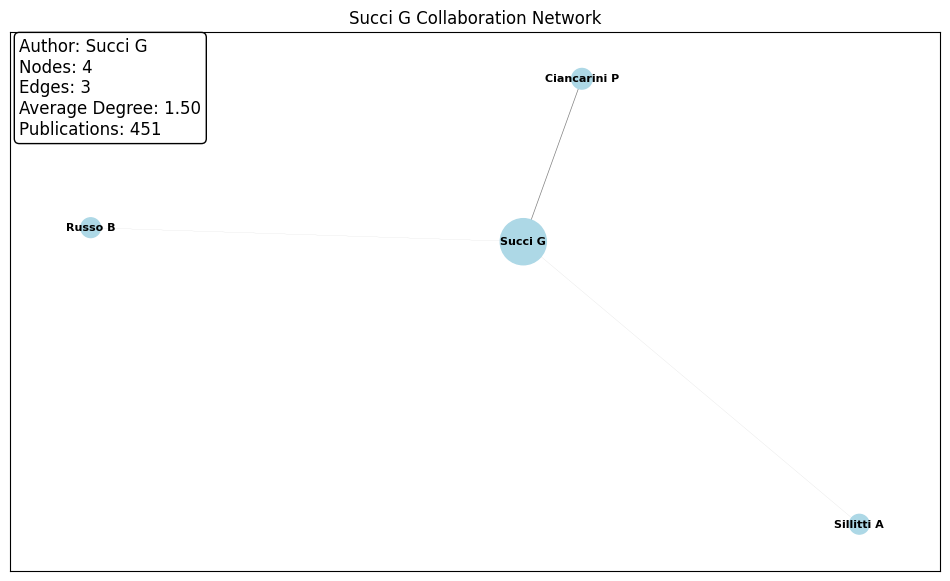

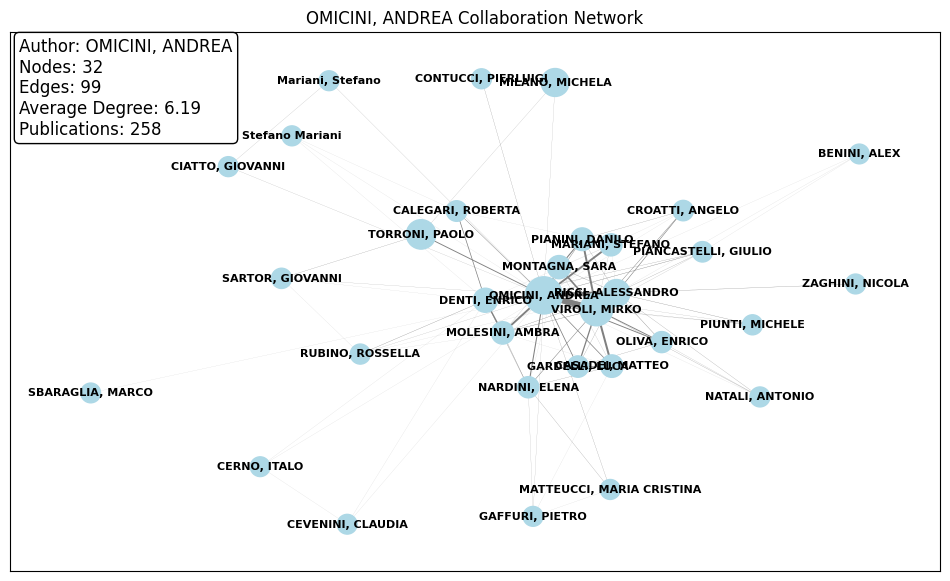

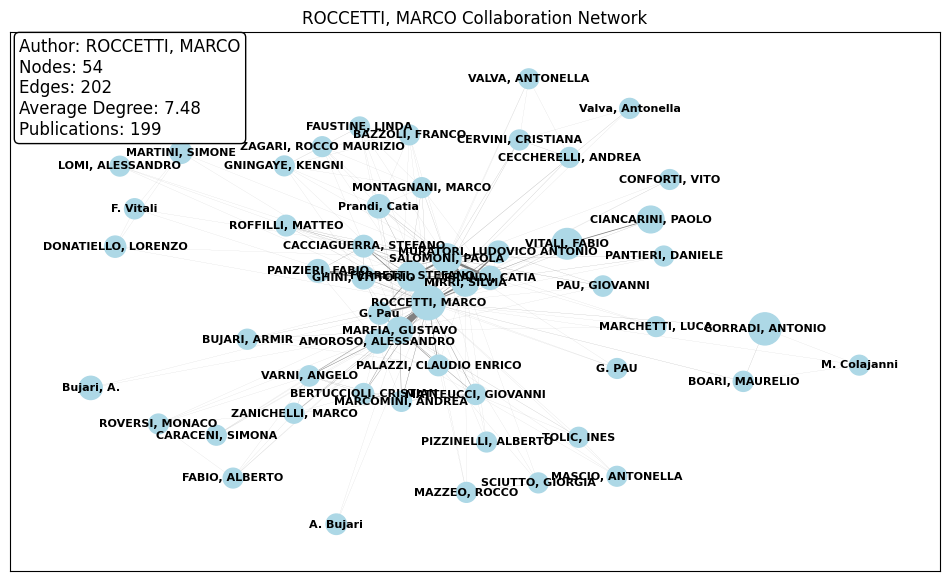

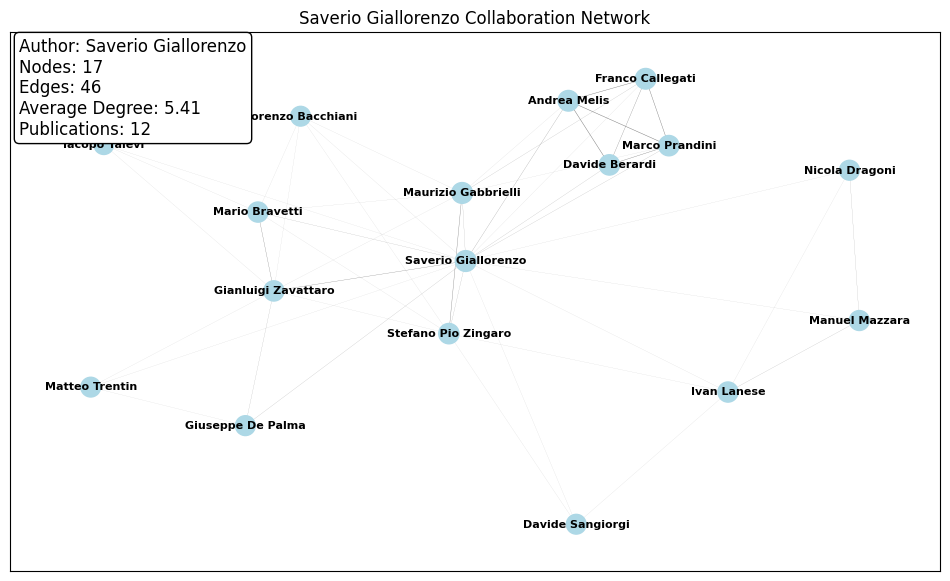

In [5]:
# Creare il grafo
G, author_counts = create_author_collaboration_graph(filename)

# 3 professori con più pubblicazioni
top_authors = sorted(author_counts.items(), key=lambda x: x[1], reverse=True)[:3]

# Calcolo della centralità
degree_centrality = nx.degree_centrality(G)

# Visualizzare i nodi più centrali
top_central_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

subgraphs = {}

subgraphs["Saverio Giallorenzo"] = filter_graph(G, "Saverio Giallorenzo")

for author, publications in top_authors:
    subgraphs[author] = filter_graph(G, author)
    
for author, publications in top_authors:
    draw_graph(subgraphs[author], author_counts, author)  # Disegna il sotto-grafo

draw_graph(subgraphs["Saverio Giallorenzo"], author_counts, "Saverio Giallorenzo")

In [6]:
subgraph_data = {}  # Dizionario per memorizzare DataFrame di nodi e archi per ogni sotto-grafo

for author, subgraph in subgraphs.items():
    # Creare DataFrame per i nodi
    df_nodes = pd.DataFrame(subgraph.nodes(), columns=['Nodes'])
    
    # Creare DataFrame per gli archi
    df_edges = pd.DataFrame(list(subgraph.edges(data=True)), columns=['Source', 'Target', 'Attributes'])
    
    # Salvare i DataFrame in un dizionario
    subgraph_data[author] = {
        "nodes": df_nodes,
        "edges": df_edges
    }

    # Stampa informazioni
    print(f"Autore: {author} \nNodi: {df_nodes.shape} \nArchi: {df_edges.shape} \n")

    # Creare le directory solo se non esistono
    os.makedirs("nodes_gephi", exist_ok=True)
    os.makedirs("edges_gephi", exist_ok=True)

    # Salvare i file CSV
    df_nodes.to_csv(f'nodes_gephi/nodes_all_{author}.csv', index=False)
    df_edges.to_csv(f'edges_gephi/edges_all_{author}.csv', index=False)

    nodes_all = df_nodes['Nodes'].unique()

Autore: Saverio Giallorenzo 
Nodi: (17, 1) 
Archi: (46, 3) 

Autore: Succi G 
Nodi: (4, 1) 
Archi: (3, 3) 

Autore: OMICINI, ANDREA 
Nodi: (32, 1) 
Archi: (99, 3) 

Autore: ROCCETTI, MARCO 
Nodi: (54, 1) 
Archi: (202, 3) 



# Measures

Centralità di grado: misura l'importanza di un nodo in base al numero di connessioni dirette che ha con altri nodi, normalizzata sul numero massimo possibile di connessioni in un grafo.

In [7]:
degree_centrality_subgraphs = {}

for author, subgraph in subgraphs.items():
    degree_centrality_subgraphs[author] = nx.degree_centrality(subgraph)

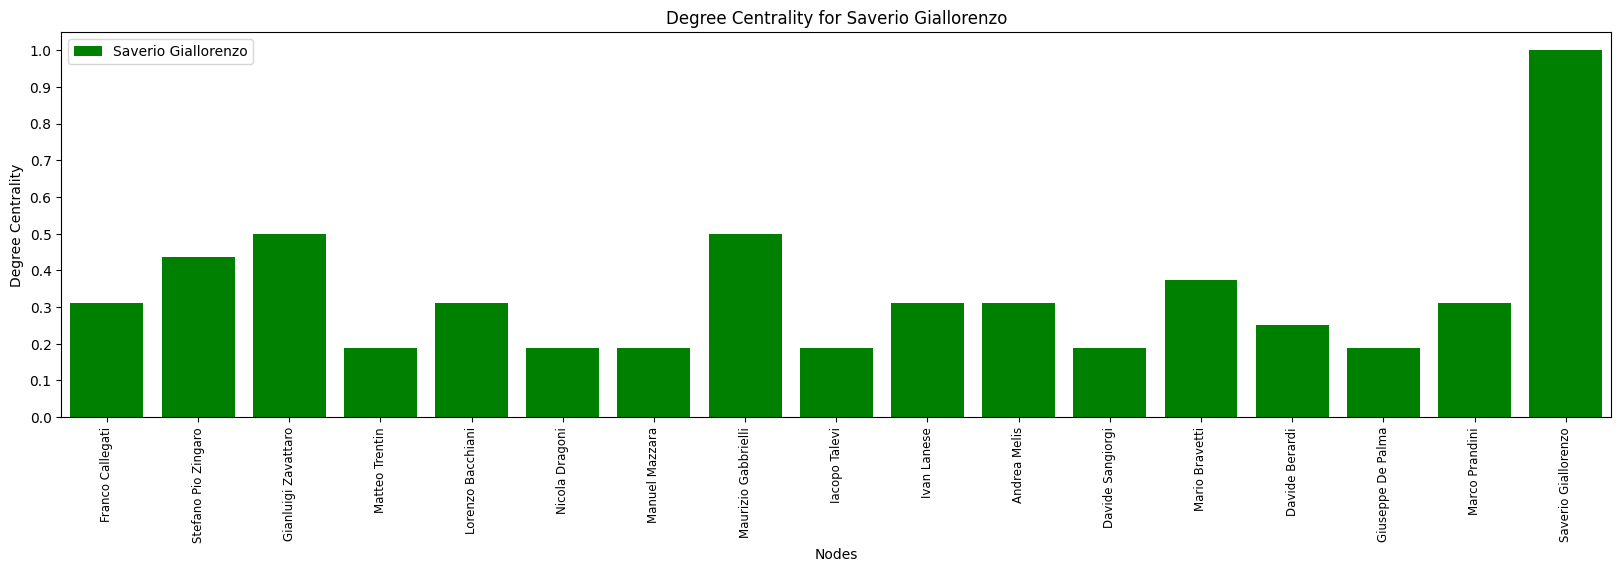

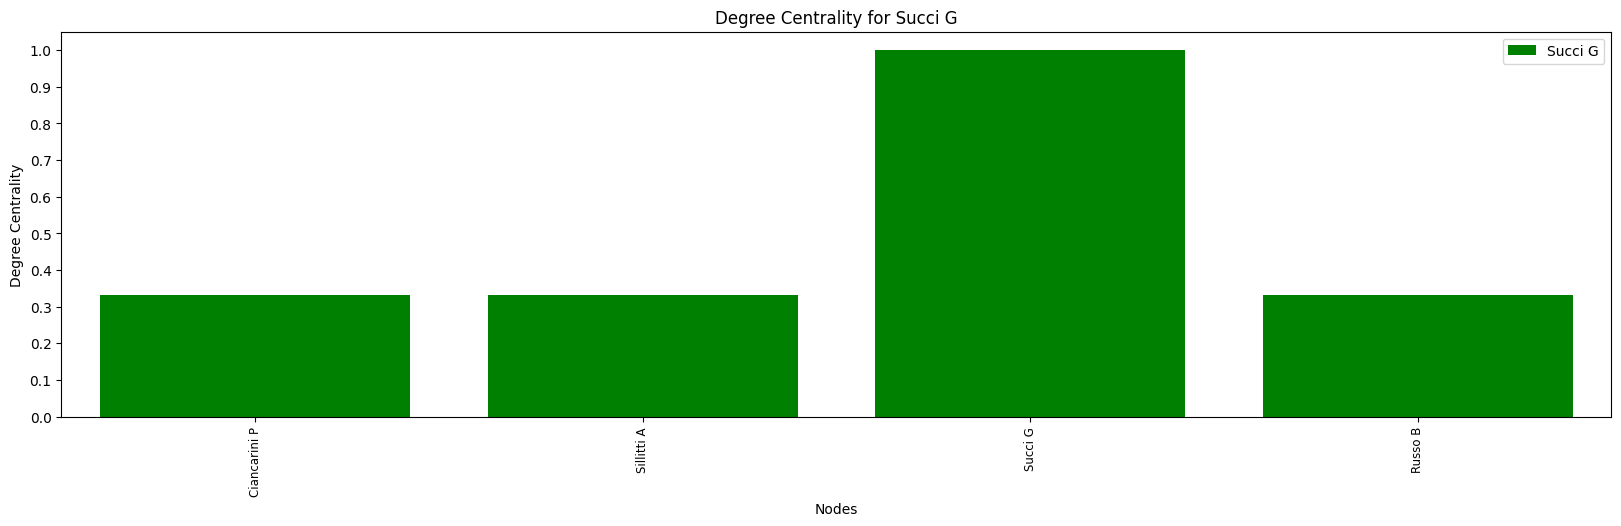

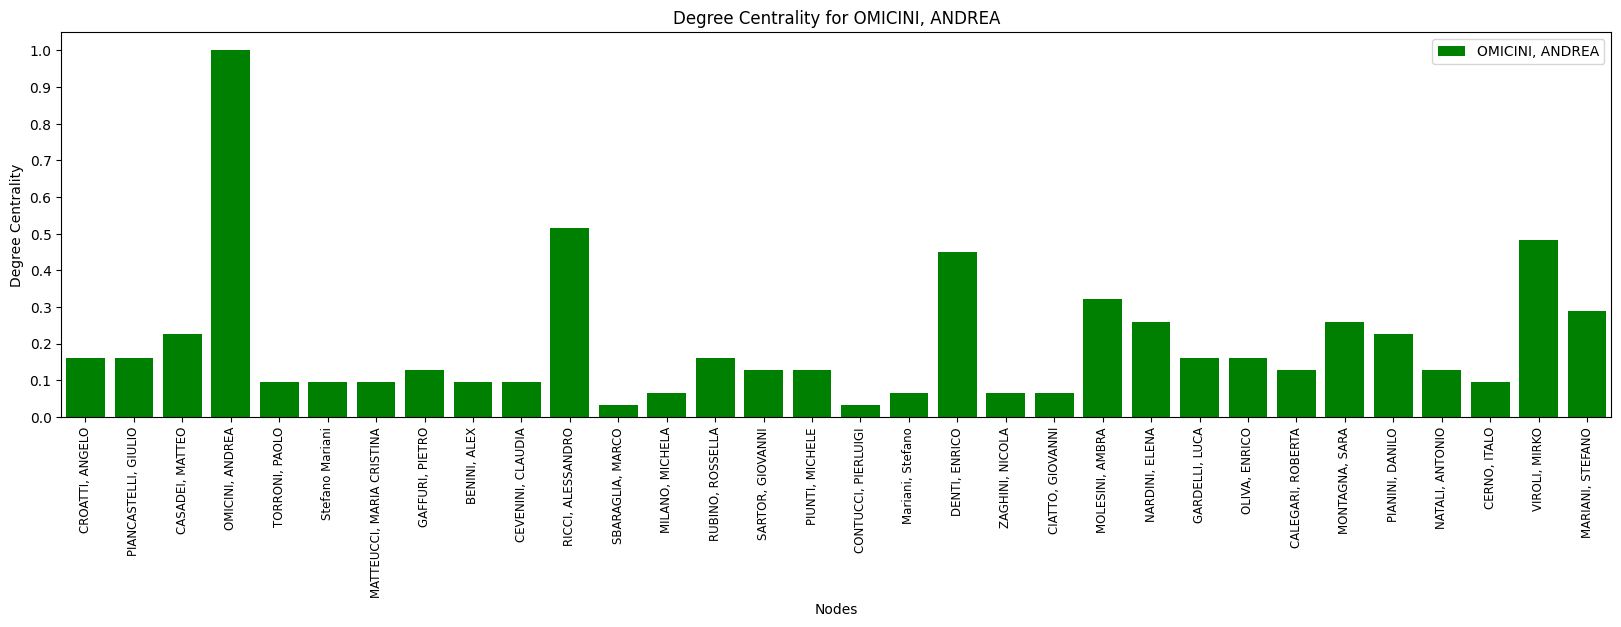

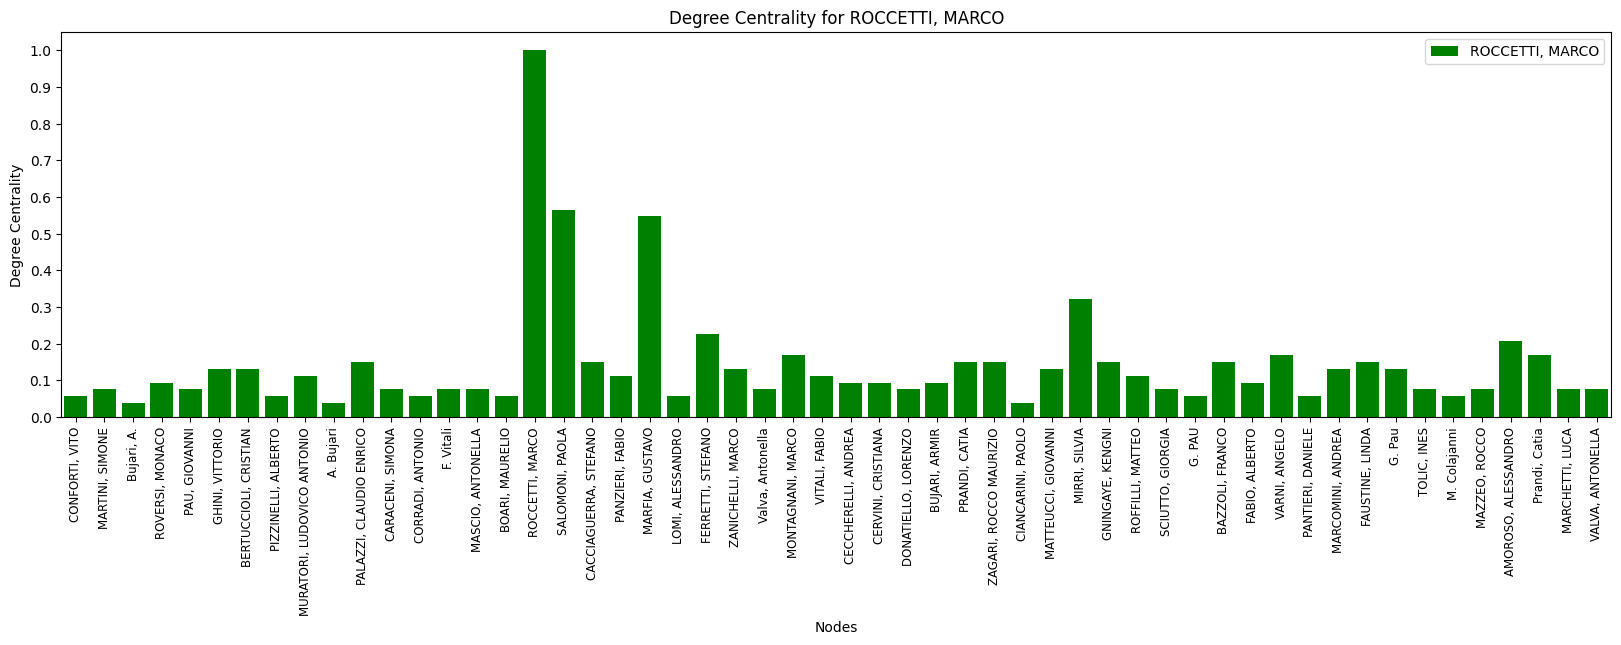

In [8]:
# Show the histogram of degree centrality values for each node
for author, centrality in degree_centrality_subgraphs.items():
    degree_nodes = centrality.keys()
    degree_centralities = centrality.values()

    plt.figure(figsize=(20, 5))
    plt.bar(degree_nodes, degree_centralities, color='g', label=f'{author}')
    plt.xlabel('Nodes')
    plt.ylabel('Degree Centrality')
    plt.legend()
    plt.xticks(rotation=90, fontsize=8.5)
    plt.yticks(np.arange(0, max(degree_centralities) + 0.05, 0.1))
    plt.xlim(-0.5, len(degree_nodes) - 0.5)
    plt.title(f'Degree Centrality for {author}')
    plt.show()


Find nodes with degree centrality above a certain threshold: they are the most important nodes (with more edges)

In [9]:
threshold = 0.7  # Soglia per la centralità di grado

# Dizionario per memorizzare i nodi con centralità superiore alla soglia
high_degree_nodes_subgraphs = {}

for author, centrality in degree_centrality_subgraphs.items():
    # Filtra i nodi con centralità superiore alla soglia
    high_degree_nodes_subgraphs[author] = [
        node for node, deg in centrality.items() if deg > threshold
    ]

# Stampa i risultati
for author, high_degree_nodes in high_degree_nodes_subgraphs.items():
    print(f"{author} - Nodes with degree centrality above {threshold}: {high_degree_nodes}")


Saverio Giallorenzo - Nodes with degree centrality above 0.7: ['Saverio Giallorenzo']
Succi G - Nodes with degree centrality above 0.7: ['Succi G']
OMICINI, ANDREA - Nodes with degree centrality above 0.7: ['OMICINI, ANDREA']
ROCCETTI, MARCO - Nodes with degree centrality above 0.7: ['ROCCETTI, MARCO']


## Degree centrality ***distribution***
---

### **Centralità di grado**
- **Definizione**: La centralità di grado misura il numero di connessioni dirette che un nodo ha in una rete.
    - **Reti dirette**: Si distingue tra **in-degree** (connessioni in entrata) e **out-degree** (connessioni in uscita).
    - **Reti non dirette**: Ogni connessione è contata come bidirezionale.

- **Interpretazione nella rete sociale**:
    - Un nodo con alto grado è un "hub", cioè è molto connesso rispetto ad altri nodi.
    - Misurare la **centralità di grado relativa** (normalizzata) consente di confrontare nodi in reti di dimensioni diverse.

---

### **Distribuzione della centralità di grado**
- Analizzare come i gradi dei nodi si distribuiscono è fondamentale per capire la struttura della rete:
    - **Scale-free networks** (reti senza scala):
        - Hanno molti nodi con pochi collegamenti e pochi nodi con tantissimi collegamenti (es., reti sociali, Internet).
        - Segue una legge di potenza.
    - **Distribuzione uniforme**: Ogni nodo ha un grado simile.
    - **Distribuzione casuale**: I gradi seguono una distribuzione normale o poissoniana.

---

### **Cosa rappresenta il grafico**
- L'asse x: Logaritmo della centralità di grado.
- L'asse y: Logaritmo della frequenza di nodi con una determinata centralità di grado.
- **Punti rossi**: Valori effettivi della distribuzione.
- **Linea blu**: Linea retta che rappresenta il modello di legge di potenza.

---
     - Una pendenza molto ripida indica pochi hub dominanti.
     - Una pendenza meno ripida suggerisce una rete più distribuita.

Author Saverio Giallorenzo
Centrality {'Franco Callegati': 0.3125, 'Stefano Pio Zingaro': 0.4375, 'Gianluigi Zavattaro': 0.5, 'Matteo Trentin': 0.1875, 'Lorenzo Bacchiani': 0.3125, 'Nicola Dragoni': 0.1875, 'Manuel Mazzara': 0.1875, 'Maurizio Gabbrielli': 0.5, 'Iacopo Talevi': 0.1875, 'Ivan Lanese': 0.3125, 'Andrea Melis': 0.3125, 'Davide Sangiorgi': 0.1875, 'Mario Bravetti': 0.375, 'Davide Berardi': 0.25, 'Giuseppe De Palma': 0.1875, 'Marco Prandini': 0.3125, 'Saverio Giallorenzo': 1.0}
The slope of the line is: -0.80053930842657


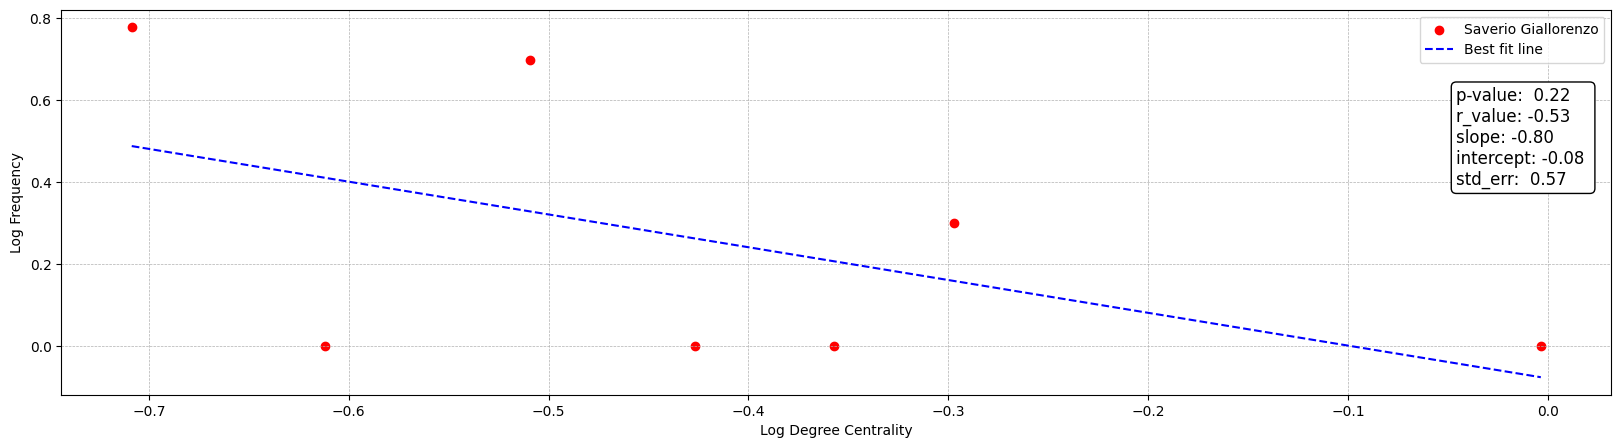

Author Succi G
Centrality {'Ciancarini P': 0.3333333333333333, 'Sillitti A': 0.3333333333333333, 'Succi G': 1.0, 'Russo B': 0.3333333333333333}
The slope of the line is: -1.024709546330623


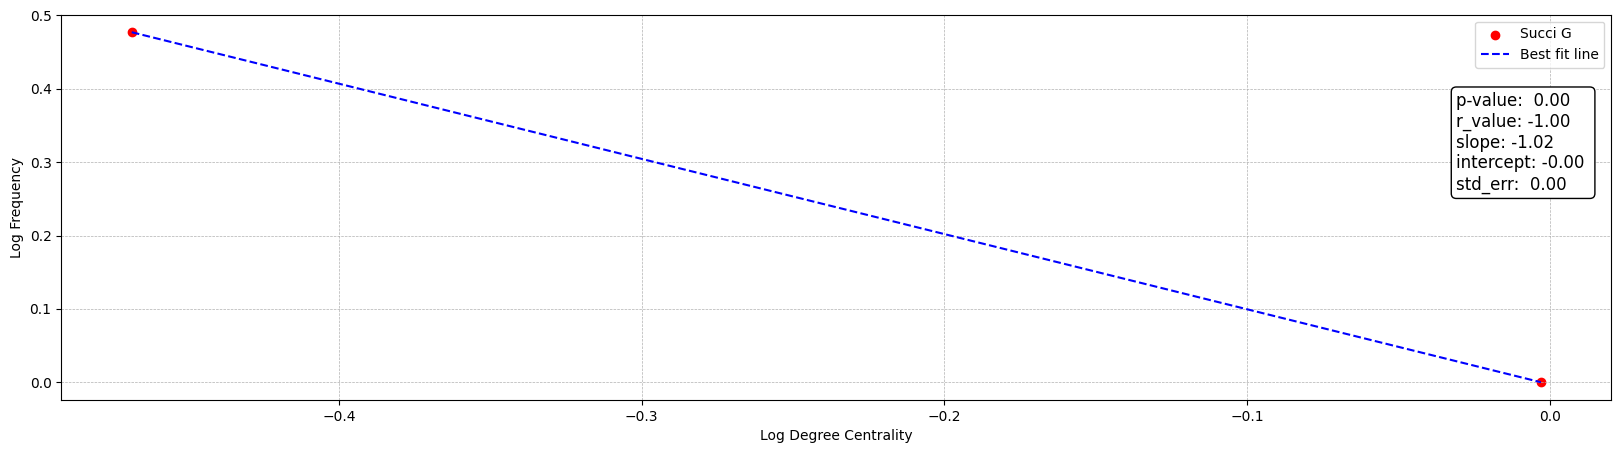

Author OMICINI, ANDREA
Centrality {'CROATTI, ANGELO': 0.16129032258064516, 'PIANCASTELLI, GIULIO': 0.16129032258064516, 'CASADEI, MATTEO': 0.22580645161290322, 'OMICINI, ANDREA': 1.0, 'TORRONI, PAOLO': 0.0967741935483871, 'Stefano Mariani': 0.0967741935483871, 'MATTEUCCI, MARIA CRISTINA': 0.0967741935483871, 'GAFFURI, PIETRO': 0.12903225806451613, 'BENINI, ALEX': 0.0967741935483871, 'CEVENINI, CLAUDIA': 0.0967741935483871, 'RICCI, ALESSANDRO': 0.5161290322580645, 'SBARAGLIA, MARCO': 0.03225806451612903, 'MILANO, MICHELA': 0.06451612903225806, 'RUBINO, ROSSELLA': 0.16129032258064516, 'SARTOR, GIOVANNI': 0.12903225806451613, 'PIUNTI, MICHELE': 0.12903225806451613, 'CONTUCCI, PIERLUIGI': 0.03225806451612903, 'Mariani, Stefano': 0.06451612903225806, 'DENTI, ENRICO': 0.45161290322580644, 'ZAGHINI, NICOLA': 0.06451612903225806, 'CIATTO, GIOVANNI': 0.06451612903225806, 'MOLESINI, AMBRA': 0.3225806451612903, 'NARDINI, ELENA': 0.25806451612903225, 'GARDELLI, LUCA': 0.16129032258064516, 'OLIVA, 

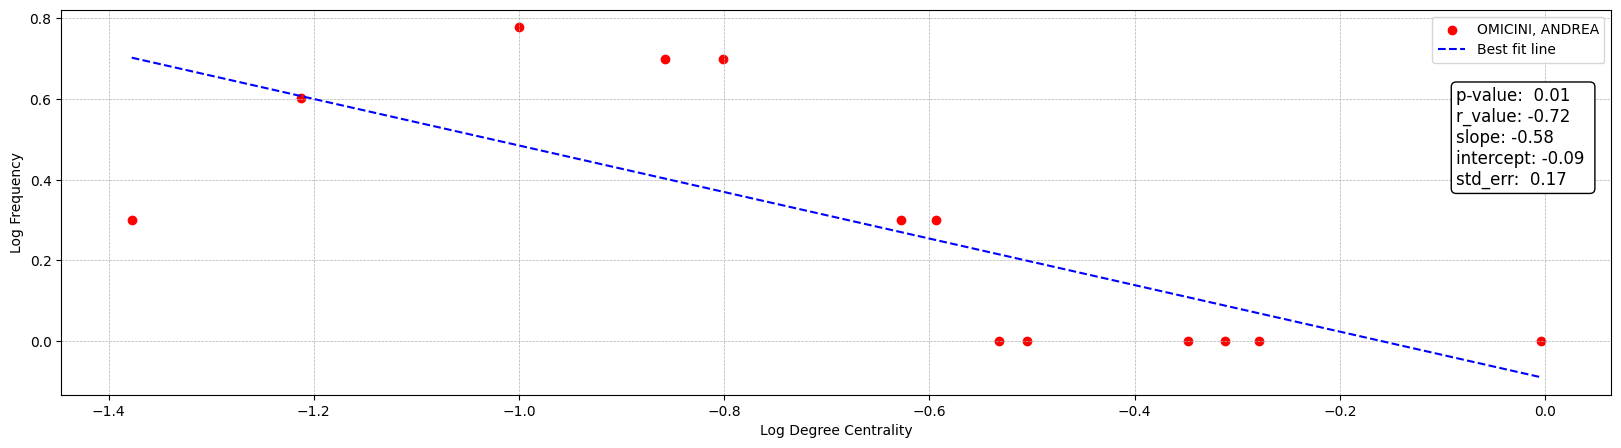

Author ROCCETTI, MARCO
Centrality {'CONFORTI, VITO': 0.05660377358490566, 'MARTINI, SIMONE': 0.07547169811320754, 'Bujari, A.': 0.03773584905660377, 'ROVERSI, MONACO': 0.09433962264150943, 'PAU, GIOVANNI': 0.07547169811320754, 'GHINI, VITTORIO': 0.1320754716981132, 'BERTUCCIOLI, CRISTIAN': 0.1320754716981132, 'PIZZINELLI, ALBERTO': 0.05660377358490566, 'MURATORI, LUDOVICO ANTONIO': 0.11320754716981132, 'A. Bujari': 0.03773584905660377, 'PALAZZI, CLAUDIO ENRICO': 0.1509433962264151, 'CARACENI, SIMONA': 0.07547169811320754, 'CORRADI, ANTONIO': 0.05660377358490566, 'F. Vitali': 0.07547169811320754, 'MASCIO, ANTONELLA': 0.07547169811320754, 'BOARI, MAURELIO': 0.05660377358490566, 'ROCCETTI, MARCO': 1.0, 'SALOMONI, PAOLA': 0.5660377358490566, 'CACCIAGUERRA, STEFANO': 0.1509433962264151, 'PANZIERI, FABIO': 0.11320754716981132, 'MARFIA, GUSTAVO': 0.5471698113207547, 'LOMI, ALESSANDRO': 0.05660377358490566, 'FERRETTI, STEFANO': 0.22641509433962265, 'ZANICHELLI, MARCO': 0.1320754716981132, 'Val

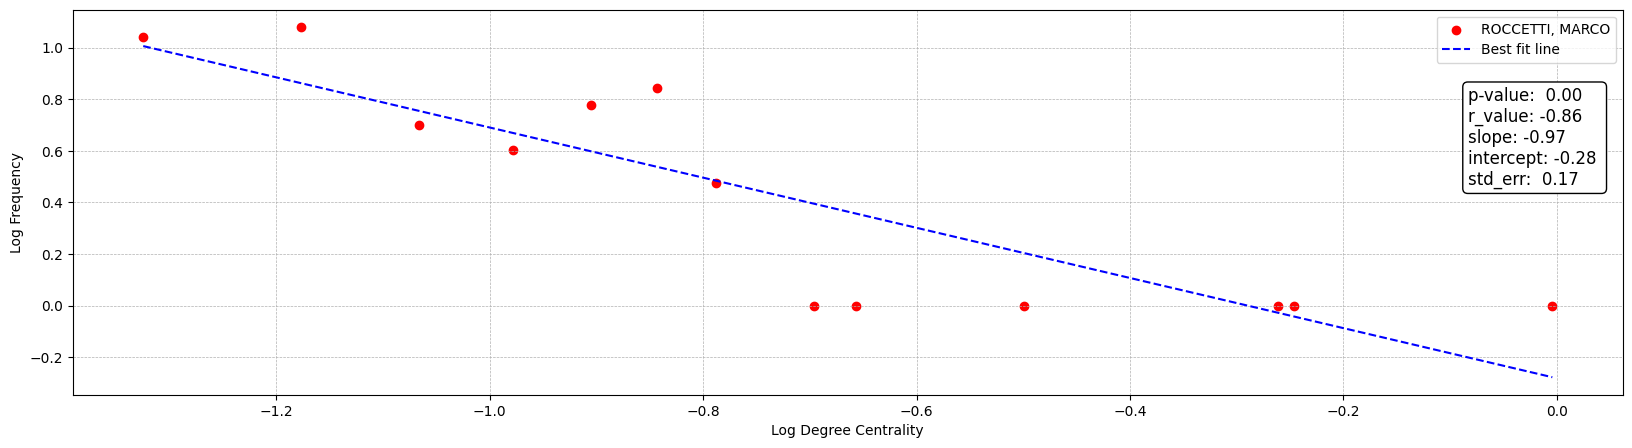

In [10]:
for author, centrality in degree_centrality_subgraphs.items():
    print(f"Author {author}")
    print(f"Centrality {centrality}")
    
    values_all = list(centrality.values())
    freq, bins = np.histogram(values_all, bins=50)

    # Calculate bin centers
    x = (bins[:-1] + bins[1:]) / 2  # x = center value of each bin
    y = freq  # y = occurrence

    # Filter out zero values (they are values it added, not ours)
    non_zero_indices = np.where(y > 0)
    x_display = x[non_zero_indices]
    y_display = y[non_zero_indices]

    # Exclude the last value for the fit
    # fit_points = np.where(x_display < np.max(x_display))
    x_fit = x_display
    y_fit = y_display

    # Take the logarithm of x and y
    log_x_display = np.log10(x_display)
    log_y_display = np.log10(y_display)
    log_x_fit = np.log10(x_fit)
    log_y_fit = np.log10(y_fit)

    # Fit a straight line to the data
    coeffs = np.polyfit(log_x_fit, log_y_fit, 1)

    # Generate y-values for the fitted line
    fitted_y = coeffs[0] * log_x_fit + coeffs[1]

    # Perform linear regression and get p-value
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_fit, log_y_fit) # r_value -> is the pearson correlation coefficient
                                                                                         # p_value -> degree of confidence in rejecting the null hypothesis (the lower the better)
    plt.figure(figsize=(20, 5))
    plt.scatter(log_x_display, log_y_display, color='r', label=f'{author}')
    plt.plot(log_x_fit, fitted_y, 'b--', label='Best fit line')  # Plot fitted line
    plt.legend()
    plt.xlabel('Log Degree Centrality')
    plt.ylabel('Log Frequency')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    plt.text(
        0.90, 0.80,
        f'p-value: {p_value: .2f} \nr_value: {r_value: .2f} \nslope: {slope: .2f} \nintercept: {intercept: .2f} \nstd_err: {std_err: .2f}',
        fontsize=12,
        ha='left',
        va='top',
        transform=plt.gca().transAxes, 
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
    )

    print(f"The slope of the line is: {slope}")
    plt.show()

### Cumulative Distribution for Degree Centrality (CDF)
Reti sociali:
La maggior parte dei nodi (persone) ha poche connessioni.
Pochi nodi (influencer) hanno moltissime connessioni.

Comprensione globale:
Ti permette di vedere la struttura della rete senza analizzare singoli nodi.
La CDF fornisce una misura cumulativa più intuitiva rispetto all'istogramma.

Interpretazione

Lineare (sinistra): Mostra come i nodi con bassa centralità di grado costituiscono la maggior parte della rete.
Una curva ripida significa che molti nodi hanno centralità bassa.

Log-log (destra): Se i punti formano una linea retta, la rete probabilmente segue una distribuzione a legge di potenza.
Questo grafico è usato per rilevare proprietà scale-free.

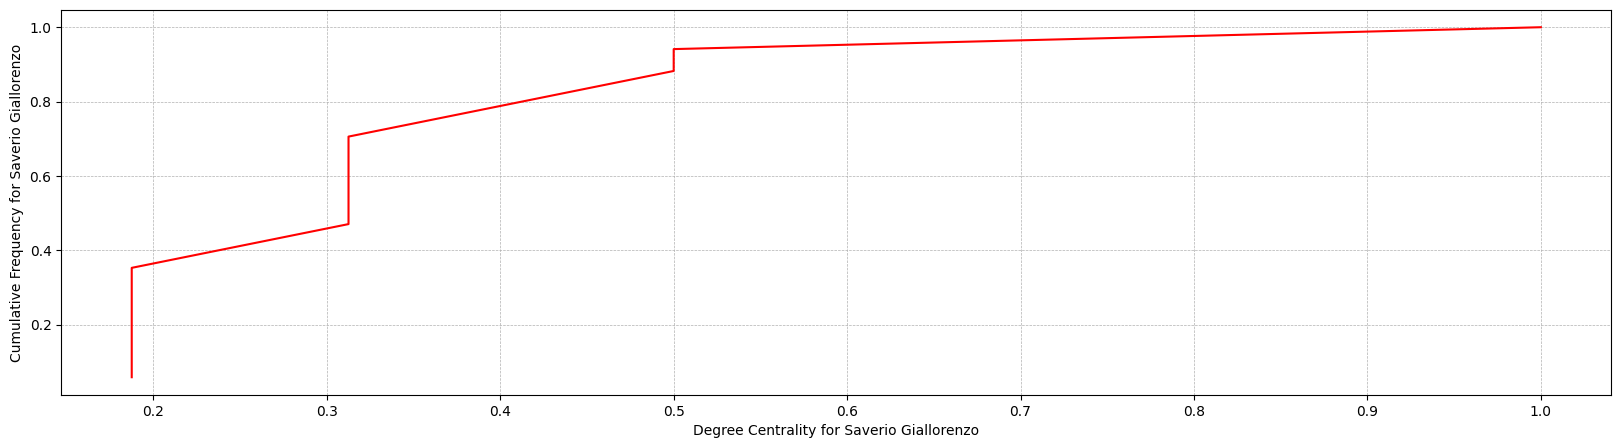

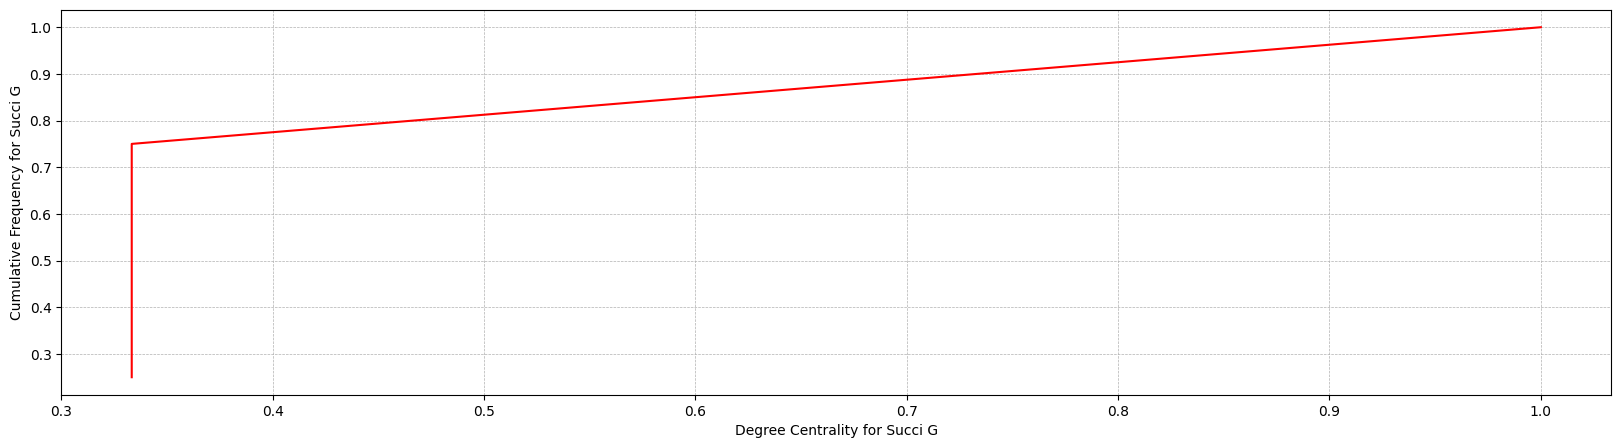

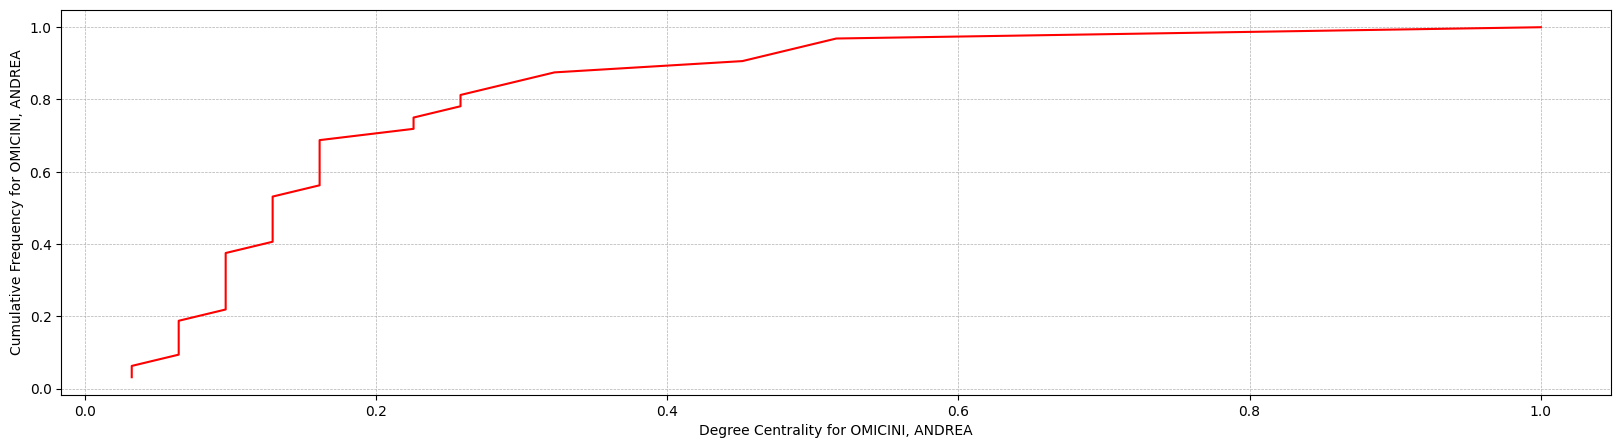

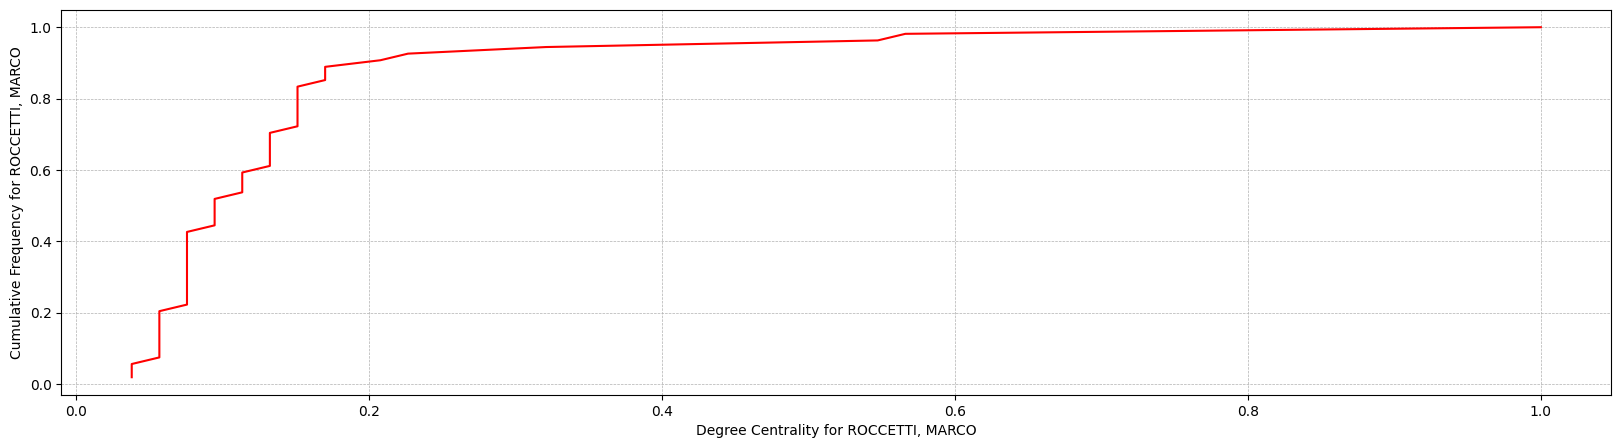

In [11]:
for author, centrality in degree_centrality_subgraphs.items():
    values_all = list(centrality.values())
    values_all.sort()

    # Compute the cumulative frequencies
    cumulative_frequencies_all = np.cumsum(np.ones(len(values_all)) / len(values_all))

    plt.figure(figsize=(20,5))

    plt.plot(values_all, cumulative_frequencies_all, color = 'r')
    plt.xlabel(f'Degree Centrality for {author}')
    plt.ylabel(f'Cumulative Frequency for {author}')
    plt.grid(True, ls="--", linewidth=0.5)

    # Show the plot
    plt.show()

## Eigenvector centrality

Centralità dell'autovettore (eigenvector centrality) per ciascun nodo della rete rappresentata dal sottografo.

La eigenvector centrality misura l'importanza di un nodo in base all'importanza dei nodi a cui è connesso.
È un'estensione della degree centrality, che tiene conto della qualità delle connessioni, non solo della quantità.
Nodi con connessioni a nodi altamente connessi otterranno un punteggio maggiore.

Interpretazione dei risultati

Nodi con centralità elevata:
Hanno connessioni con nodi influenti.
Sono centrali nella struttura globale della rete.

Confronto con altre misure:
Rispetto alla degree centrality, questa metrica premia nodi che non solo sono ben connessi, ma che sono collegati a nodi altrettanto centrali.

Applicazioni della eigenvector centrality

Identificazione di leader o hub in una rete.

Analisi delle reti sociali (influenza di persone chiave).

Ranking di pagine web (PageRank è una variante della eigenvector centrality).

In [12]:
eig_centrality_subgraphs = {}

for author, subgraph in subgraphs.items():
    eig_centrality_subgraphs[author] = nx.eigenvector_centrality(subgraph)

C:\Users\valde\AppData\Local\Temp\ipykernel_13908\2758727522.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


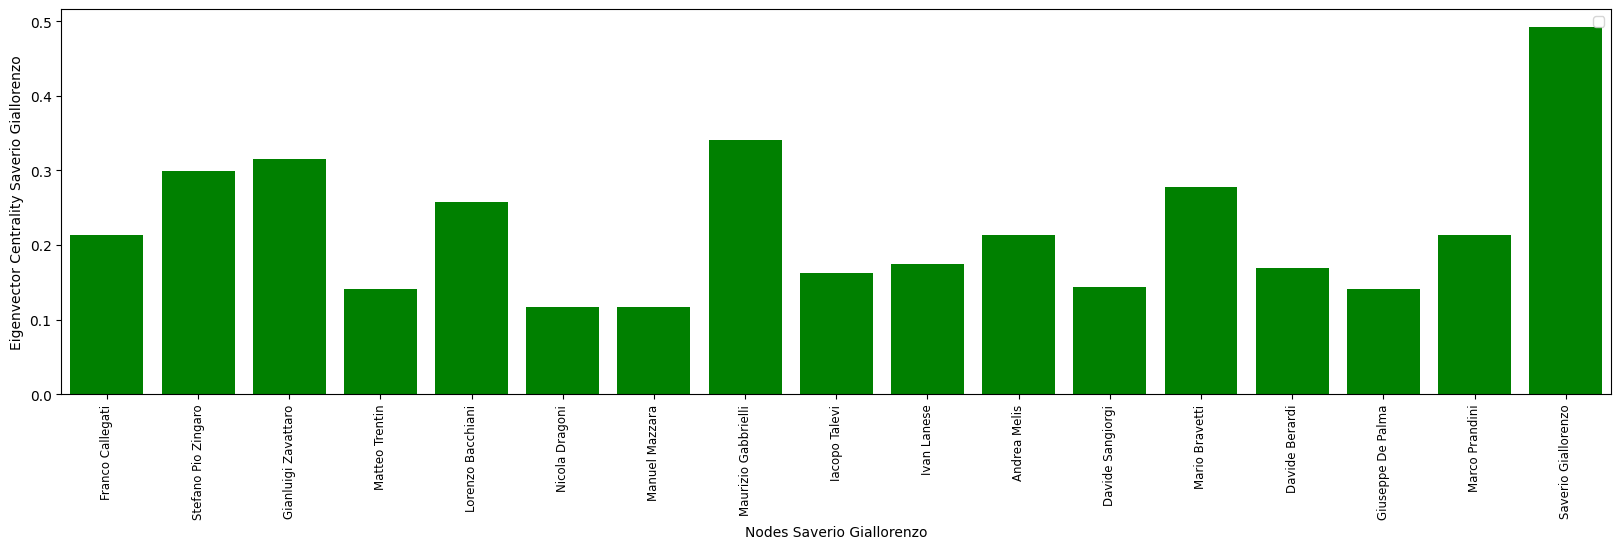

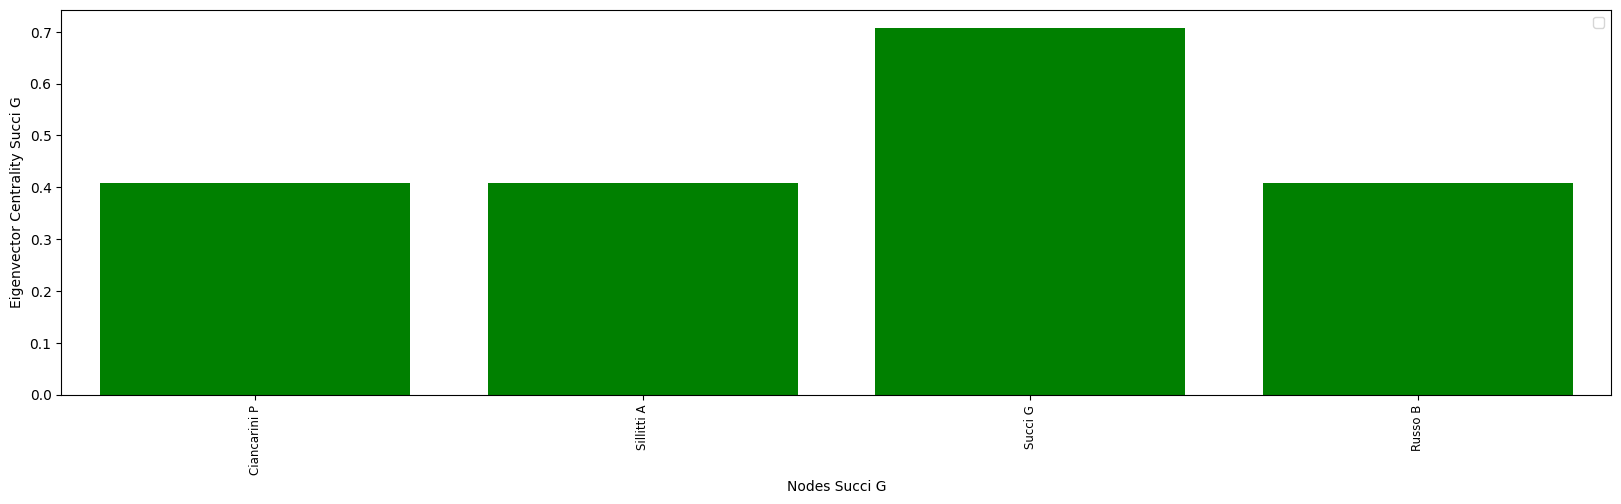

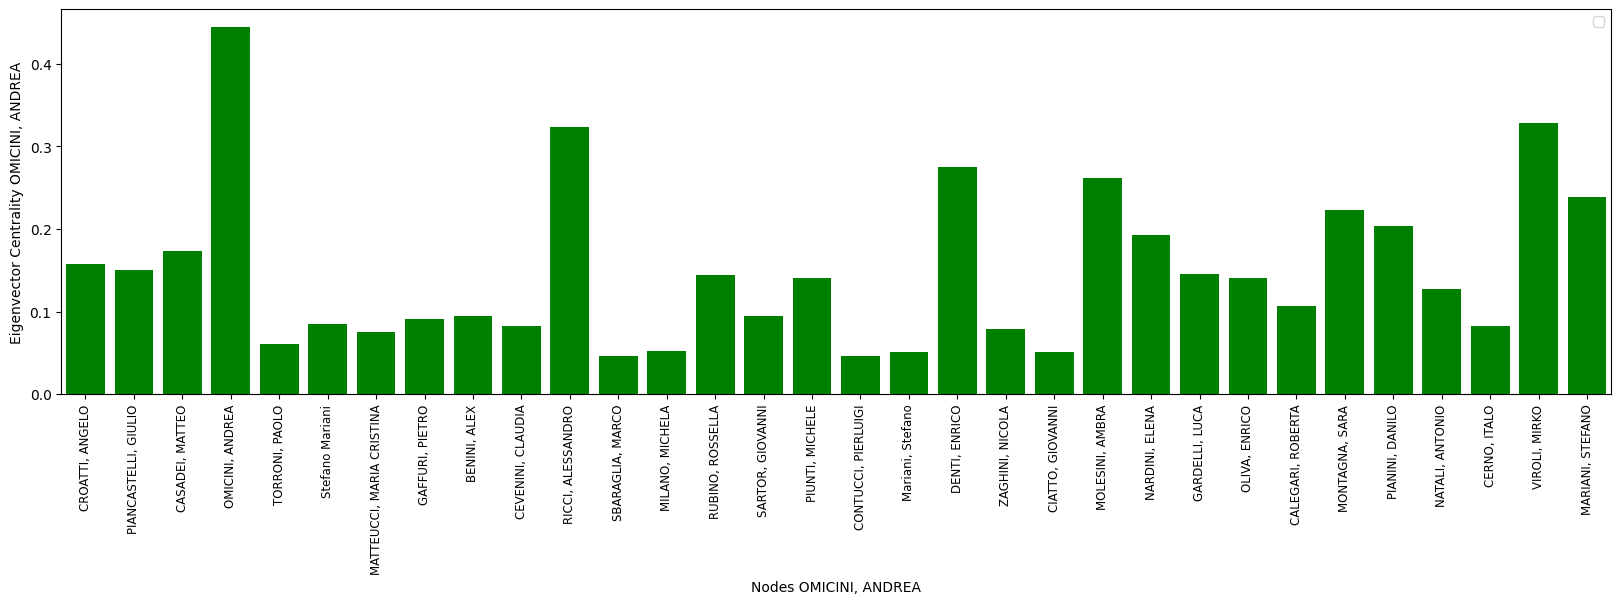

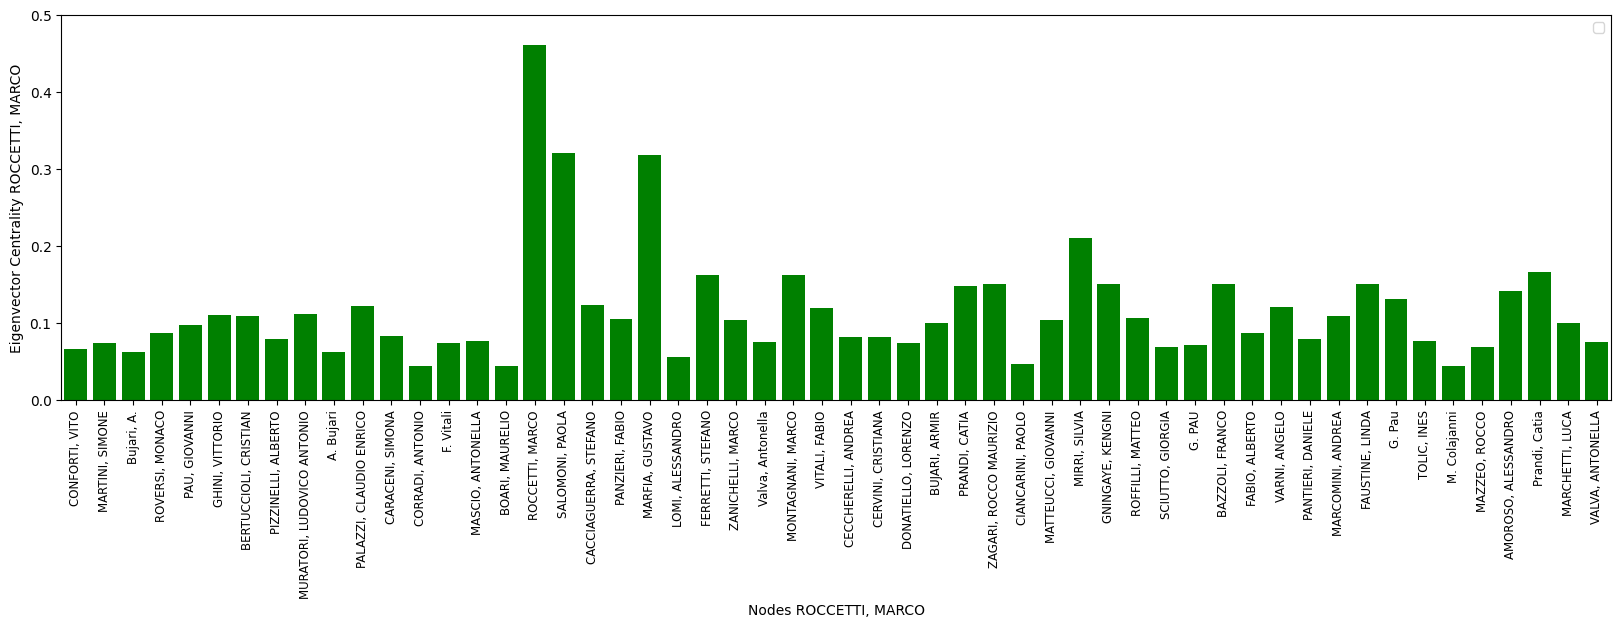

In [13]:
for author, centrality in eig_centrality_subgraphs.items():
    eig_nodes = centrality.keys()
    eig_centralities = centrality.values()

    plt.figure(figsize=(20,5))
    plt.bar(eig_nodes, eig_centralities, color = 'g')
    plt.xlabel(f'Nodes {author}')
    plt.ylabel(f'Eigenvector Centrality {author}')
    plt.xticks(rotation=90, fontsize = 8.5)
    plt.yticks(np.arange(0, max(eig_centralities)+ 0.05, 0.1))
    plt.xlim(-0.5, len(eig_nodes)-0.5)
    plt.legend()
    plt.show()

In [14]:
threshold = 0.3

# Dizionario per memorizzare i nodi con alta centralità per ogni autore
high_eig_nodes_all = {}

for author, centrality in eig_centrality_subgraphs.items():
    high_eig_nodes_all[author] = [
        node for node, eig in centrality.items() if eig > threshold
    ]

# Stampa dei nodi con alta centralità per ciascun autore
for author, high_eig_nodes in high_eig_nodes_all.items():
    print(f"{author} - Nodes with eigenvector centrality above {threshold}: {high_eig_nodes}")


Saverio Giallorenzo - Nodes with eigenvector centrality above 0.3: ['Gianluigi Zavattaro', 'Maurizio Gabbrielli', 'Saverio Giallorenzo']
Succi G - Nodes with eigenvector centrality above 0.3: ['Ciancarini P', 'Sillitti A', 'Succi G', 'Russo B']
OMICINI, ANDREA - Nodes with eigenvector centrality above 0.3: ['OMICINI, ANDREA', 'RICCI, ALESSANDRO', 'VIROLI, MIRKO']
ROCCETTI, MARCO - Nodes with eigenvector centrality above 0.3: ['ROCCETTI, MARCO', 'SALOMONI, PAOLA', 'MARFIA, GUSTAVO']


#### Eigenvector centrality *distribution*

Author Saverio Giallorenzo
Centrality {'Franco Callegati': 0.2130230275051989, 'Stefano Pio Zingaro': 0.29882695165800616, 'Gianluigi Zavattaro': 0.3152951259551093, 'Matteo Trentin': 0.14161901793244308, 'Lorenzo Bacchiani': 0.25746596307678216, 'Nicola Dragoni': 0.11690556934134928, 'Manuel Mazzara': 0.11690556934134928, 'Maurizio Gabbrielli': 0.34046209920021486, 'Iacopo Talevi': 0.16205041395835526, 'Ivan Lanese': 0.1744226790544821, 'Andrea Melis': 0.2130230275051989, 'Davide Sangiorgi': 0.14405752912578726, 'Mario Bravetti': 0.27851126844654955, 'Davide Berardi': 0.1688074024640669, 'Giuseppe De Palma': 0.14161901793244308, 'Marco Prandini': 0.21302302750519891, 'Saverio Giallorenzo': 0.4919405256321706}


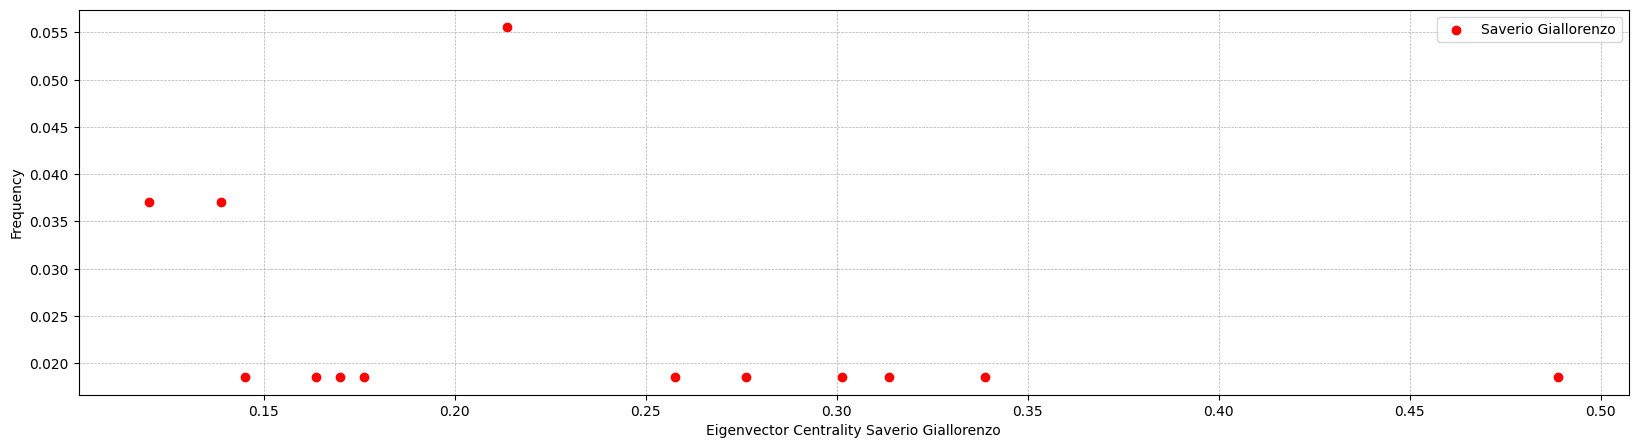

Author Succi G
Centrality {'Ciancarini P': 0.40824823454557924, 'Sillitti A': 0.40824823454557924, 'Succi G': 0.707106878039843, 'Russo B': 0.40824823454557924}


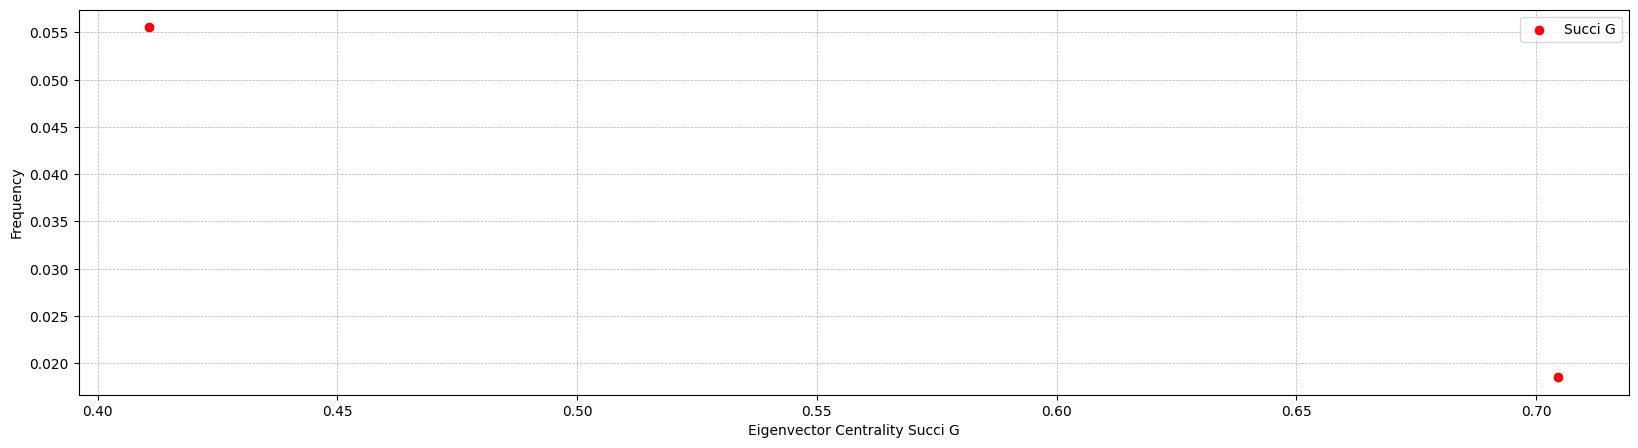

Author OMICINI, ANDREA
Centrality {'CROATTI, ANGELO': 0.1581057075807378, 'PIANCASTELLI, GIULIO': 0.1506429439833139, 'CASADEI, MATTEO': 0.1731054245169066, 'OMICINI, ANDREA': 0.4440477601873563, 'TORRONI, PAOLO': 0.060712677274895134, 'Stefano Mariani': 0.0849004681790248, 'MATTEUCCI, MARIA CRISTINA': 0.07471439360071491, 'GAFFURI, PIETRO': 0.0908449814026927, 'BENINI, ALEX': 0.09440573775377936, 'CEVENINI, CLAUDIA': 0.0823517462921066, 'RICCI, ALESSANDRO': 0.3240192940229751, 'SBARAGLIA, MARCO': 0.0456299323195086, 'MILANO, MICHELA': 0.051868834832258306, 'RUBINO, ROSSELLA': 0.14381391356576517, 'SARTOR, GIOVANNI': 0.09490641527458317, 'PIUNTI, MICHELE': 0.1409418365965288, 'CONTUCCI, PIERLUIGI': 0.0456299323195086, 'Mariani, Stefano': 0.05085593069849237, 'DENTI, ENRICO': 0.2750041594169128, 'ZAGHINI, NICOLA': 0.07892572793116288, 'CIATTO, GIOVANNI': 0.05085593069849237, 'MOLESINI, AMBRA': 0.261546485508975, 'NARDINI, ELENA': 0.19218916395670146, 'GARDELLI, LUCA': 0.1449226263605059

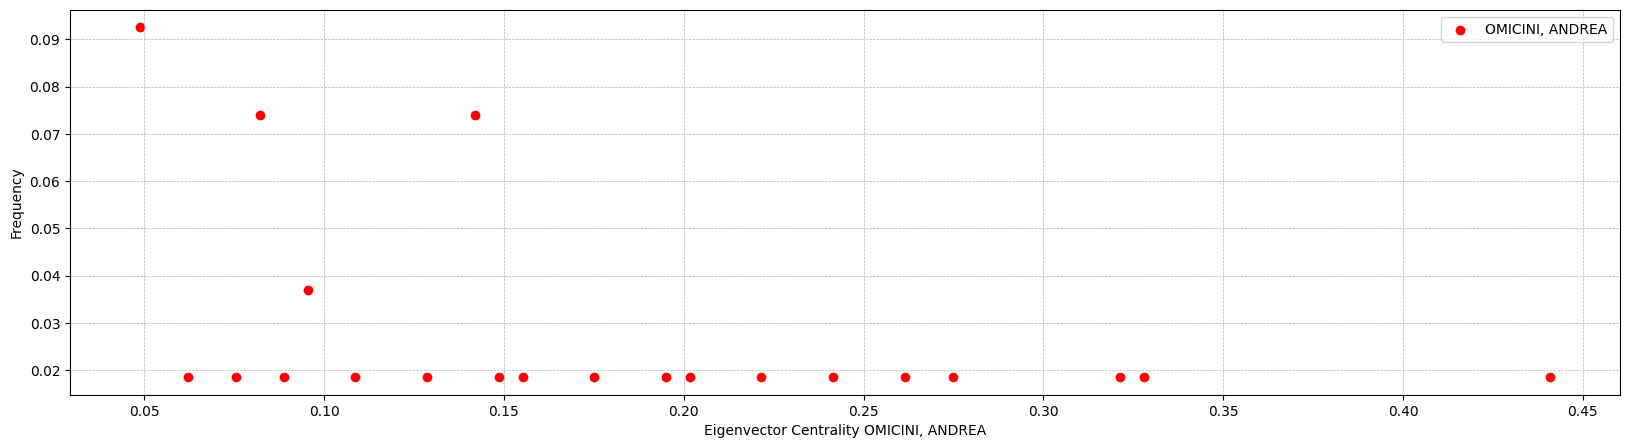

Author ROCCETTI, MARCO
Centrality {'CONFORTI, VITO': 0.06687268956416974, 'MARTINI, SIMONE': 0.07475745723144138, 'Bujari, A.': 0.06251109954993889, 'ROVERSI, MONACO': 0.08747977246890384, 'PAU, GIOVANNI': 0.09728987434311562, 'GHINI, VITTORIO': 0.11036266372245492, 'BERTUCCIOLI, CRISTIAN': 0.10882968404334468, 'PIZZINELLI, ALBERTO': 0.0796597673882734, 'MURATORI, LUDOVICO ANTONIO': 0.11232575562428715, 'A. Bujari': 0.06251109954993889, 'PALAZZI, CLAUDIO ENRICO': 0.12206636892211632, 'CARACENI, SIMONA': 0.08348690000116467, 'CORRADI, ANTONIO': 0.04406233375634659, 'F. Vitali': 0.07475745723144138, 'MASCIO, ANTONELLA': 0.07699268014319283, 'BOARI, MAURELIO': 0.04406233375634659, 'ROCCETTI, MARCO': 0.46147337339080724, 'SALOMONI, PAOLA': 0.321476877575984, 'CACCIAGUERRA, STEFANO': 0.12299466471920516, 'PANZIERI, FABIO': 0.10579491326621471, 'MARFIA, GUSTAVO': 0.3182407980920178, 'LOMI, ALESSANDRO': 0.05543244661299651, 'FERRETTI, STEFANO': 0.1619794064794686, 'ZANICHELLI, MARCO': 0.10363

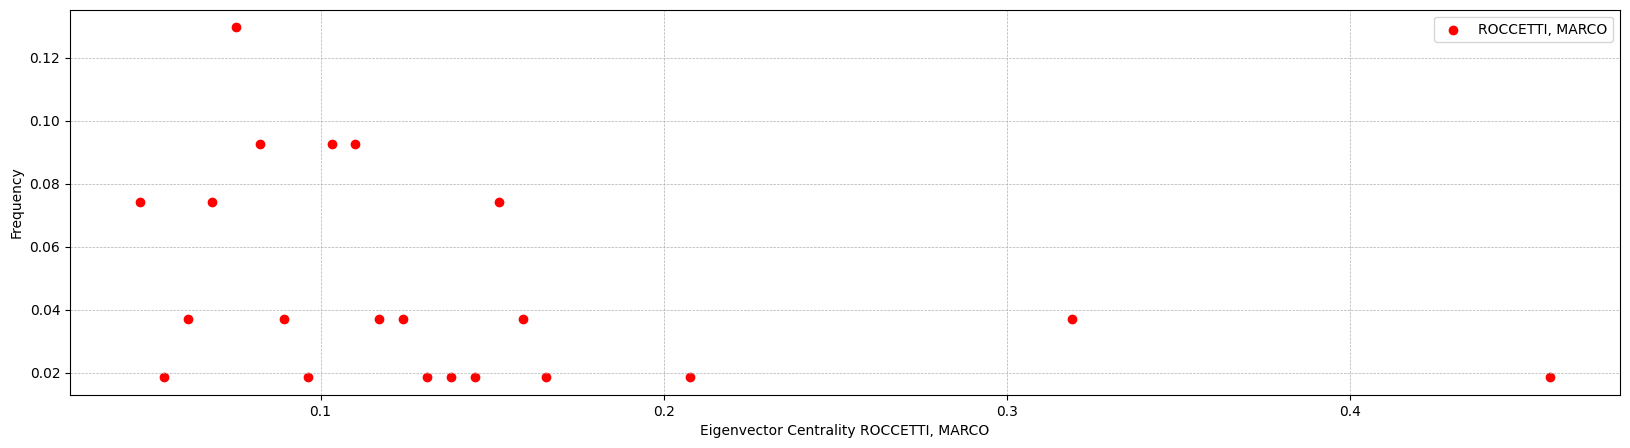

In [15]:
for author, centrality in eig_centrality_subgraphs.items():
    print(f"Author {author}")
    print(f"Centrality {centrality}")
    values_all = list(centrality.values())
    tot_nodes_all = pd.DataFrame(subgraph.nodes(), columns=['Nodes']).shape[0]
    freq, bins = np.histogram(values_all, bins=60)

    bins = (bins[:-1] + bins[1:]) / 2  # x = center value of each bin
    freq = [i/tot_nodes_all for i in freq] # find the frequency by divinding freq list by the tot nodes
    freq = np.array(freq, dtype='float32')  # convert freq from list to numpy array

    #Filter out zero values (they are values it added, not ours)
    non_zero_indices = np.where(freq > 0)
    bins = bins[non_zero_indices]
    freq = freq[non_zero_indices]

    plt.figure(figsize=(20,5))
    plt.scatter(bins, freq, color='r', label = f'{author}')
    plt.xlabel(f'Eigenvector Centrality {author}')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()

### **Distribuzione Cumulativa della Eigenvector Centrality**
1. **Eigenvector Centrality**:
    - Misura l'importanza di un nodo non solo in base al numero di connessioni, ma anche in base all'importanza dei nodi a cui è connesso.

2. **Distribuzione cumulativa**:
    - Mostra la probabilità cumulativa che un valore di centralità sia minore o uguale a un dato valore. 
    - La distribuzione cumulativa cresce monotonamente e arriva a 1 quando si considera l'intero dataset.

3. **Grafico log-log**:
    - La trasformazione logaritmica mette in evidenza le relazioni esponenziali o potenze nella distribuzione dei dati.
    - Se il grafico forma una retta, indica che la distribuzione segue una legge di potenza (Power-law), comune nelle reti complesse.

---

### **Output del grafico**
1. **Crescita cumulativa**:
    - La curva indica come i valori di centralità si distribuiscono nella rete.
    - Valori bassi di Eigenvector Centrality saranno accumulati rapidamente, mentre valori elevati appariranno solo verso la fine.

2. **Log-log lineare**:
    - Se la distribuzione segue una legge di potenza, il grafico apparirà come una linea retta su assi log-log.
    - Una distribuzione che segue una legge di potenza indica che pochi nodi altamente centrali dominano la rete, mentre la maggior parte dei nodi ha centralità bassa.

---

### **Applicazioni**
- **Identificazione di nodi chiave**:
  - Puoi identificare i nodi con alta centralità come i più influenti nella rete.
- **Conferma di proprietà di scala**:
  - Un andamento lineare su assi log-log può confermare che la rete segue una distribuzione a legge di potenza, caratteristica comune in reti complesse come quelle sociali o biologiche.

Author Saverio Giallorenzo
Centrality {'Franco Callegati': 0.2130230275051989, 'Stefano Pio Zingaro': 0.29882695165800616, 'Gianluigi Zavattaro': 0.3152951259551093, 'Matteo Trentin': 0.14161901793244308, 'Lorenzo Bacchiani': 0.25746596307678216, 'Nicola Dragoni': 0.11690556934134928, 'Manuel Mazzara': 0.11690556934134928, 'Maurizio Gabbrielli': 0.34046209920021486, 'Iacopo Talevi': 0.16205041395835526, 'Ivan Lanese': 0.1744226790544821, 'Andrea Melis': 0.2130230275051989, 'Davide Sangiorgi': 0.14405752912578726, 'Mario Bravetti': 0.27851126844654955, 'Davide Berardi': 0.1688074024640669, 'Giuseppe De Palma': 0.14161901793244308, 'Marco Prandini': 0.21302302750519891, 'Saverio Giallorenzo': 0.4919405256321706}


C:\Users\valde\AppData\Local\Temp\ipykernel_13908\1929949988.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


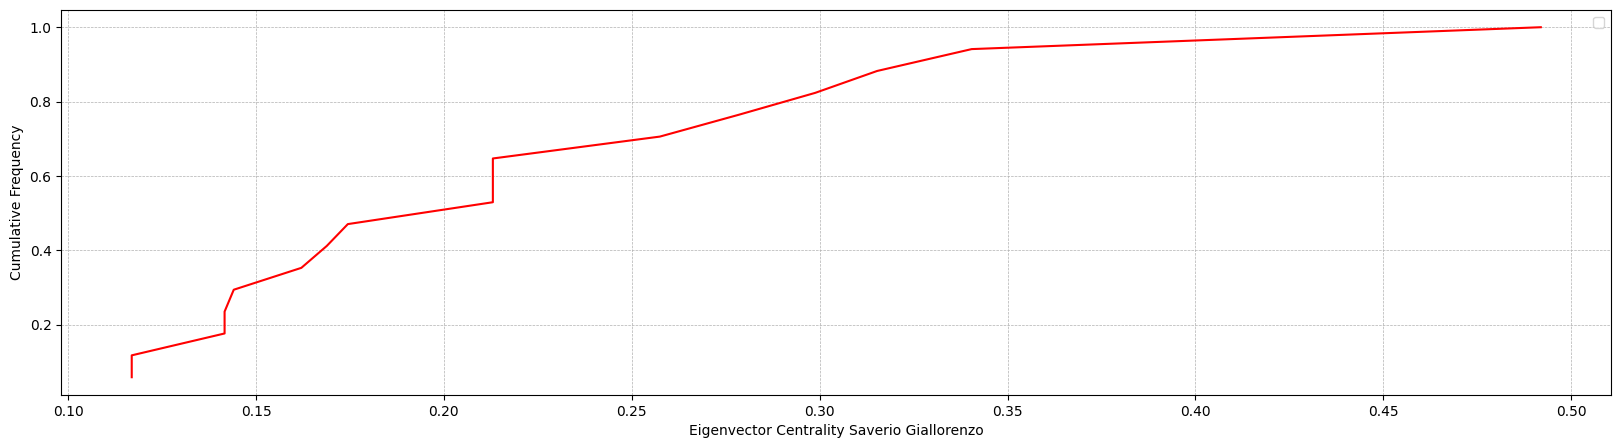

Author Succi G
Centrality {'Ciancarini P': 0.40824823454557924, 'Sillitti A': 0.40824823454557924, 'Succi G': 0.707106878039843, 'Russo B': 0.40824823454557924}


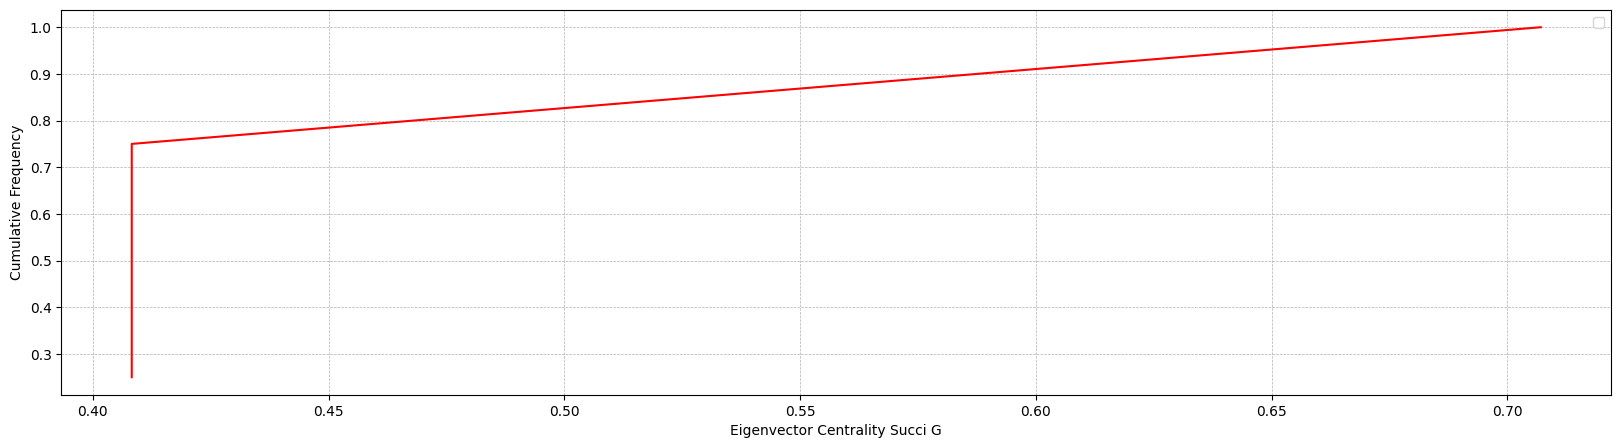

Author OMICINI, ANDREA
Centrality {'CROATTI, ANGELO': 0.1581057075807378, 'PIANCASTELLI, GIULIO': 0.1506429439833139, 'CASADEI, MATTEO': 0.1731054245169066, 'OMICINI, ANDREA': 0.4440477601873563, 'TORRONI, PAOLO': 0.060712677274895134, 'Stefano Mariani': 0.0849004681790248, 'MATTEUCCI, MARIA CRISTINA': 0.07471439360071491, 'GAFFURI, PIETRO': 0.0908449814026927, 'BENINI, ALEX': 0.09440573775377936, 'CEVENINI, CLAUDIA': 0.0823517462921066, 'RICCI, ALESSANDRO': 0.3240192940229751, 'SBARAGLIA, MARCO': 0.0456299323195086, 'MILANO, MICHELA': 0.051868834832258306, 'RUBINO, ROSSELLA': 0.14381391356576517, 'SARTOR, GIOVANNI': 0.09490641527458317, 'PIUNTI, MICHELE': 0.1409418365965288, 'CONTUCCI, PIERLUIGI': 0.0456299323195086, 'Mariani, Stefano': 0.05085593069849237, 'DENTI, ENRICO': 0.2750041594169128, 'ZAGHINI, NICOLA': 0.07892572793116288, 'CIATTO, GIOVANNI': 0.05085593069849237, 'MOLESINI, AMBRA': 0.261546485508975, 'NARDINI, ELENA': 0.19218916395670146, 'GARDELLI, LUCA': 0.1449226263605059

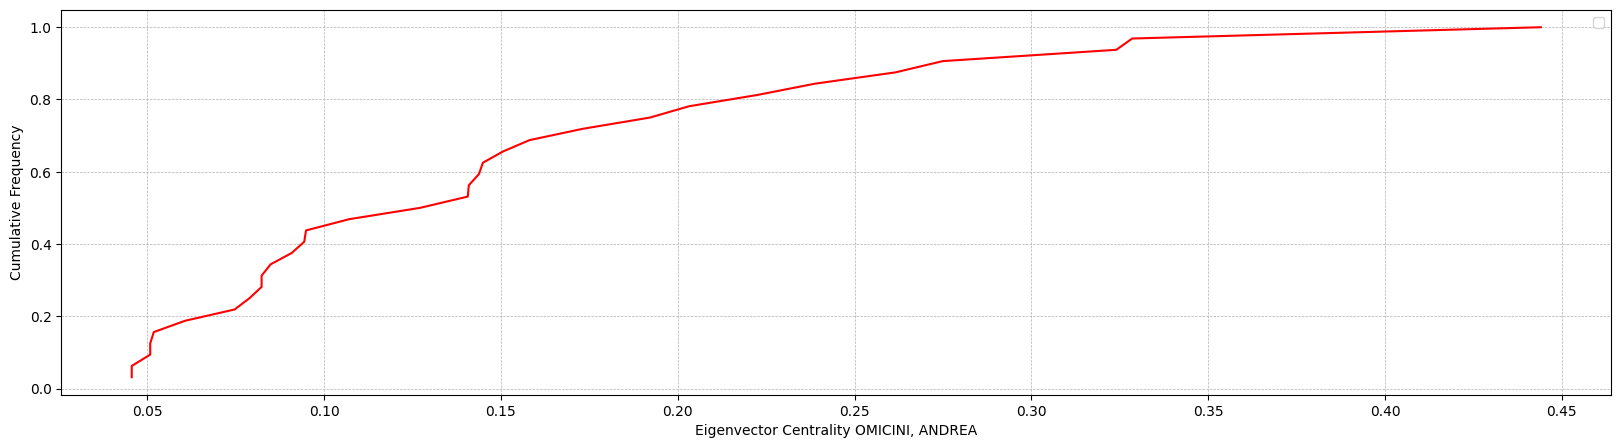

Author ROCCETTI, MARCO
Centrality {'CONFORTI, VITO': 0.06687268956416974, 'MARTINI, SIMONE': 0.07475745723144138, 'Bujari, A.': 0.06251109954993889, 'ROVERSI, MONACO': 0.08747977246890384, 'PAU, GIOVANNI': 0.09728987434311562, 'GHINI, VITTORIO': 0.11036266372245492, 'BERTUCCIOLI, CRISTIAN': 0.10882968404334468, 'PIZZINELLI, ALBERTO': 0.0796597673882734, 'MURATORI, LUDOVICO ANTONIO': 0.11232575562428715, 'A. Bujari': 0.06251109954993889, 'PALAZZI, CLAUDIO ENRICO': 0.12206636892211632, 'CARACENI, SIMONA': 0.08348690000116467, 'CORRADI, ANTONIO': 0.04406233375634659, 'F. Vitali': 0.07475745723144138, 'MASCIO, ANTONELLA': 0.07699268014319283, 'BOARI, MAURELIO': 0.04406233375634659, 'ROCCETTI, MARCO': 0.46147337339080724, 'SALOMONI, PAOLA': 0.321476877575984, 'CACCIAGUERRA, STEFANO': 0.12299466471920516, 'PANZIERI, FABIO': 0.10579491326621471, 'MARFIA, GUSTAVO': 0.3182407980920178, 'LOMI, ALESSANDRO': 0.05543244661299651, 'FERRETTI, STEFANO': 0.1619794064794686, 'ZANICHELLI, MARCO': 0.10363

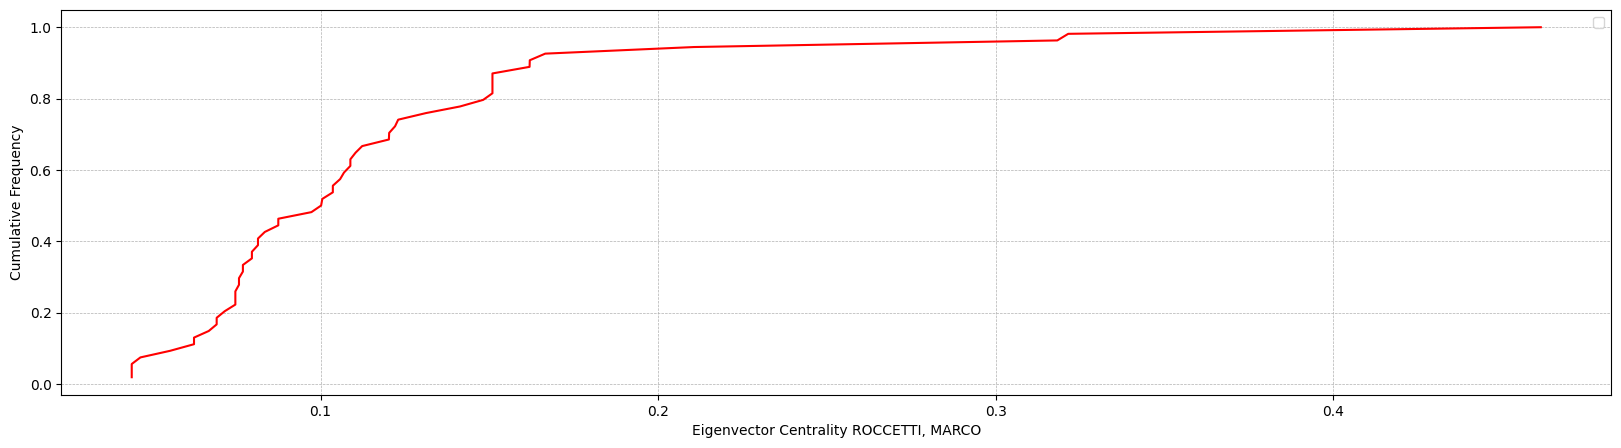

In [16]:
#cumulative
#in log plot should be a line
for author, centrality in eig_centrality_subgraphs.items():
    print(f"Author {author}")
    print(f"Centrality {centrality}")
    
    values = list(centrality.values())
    values.sort()
    cumulative_frequencies_1 = np.cumsum(np.ones(len(values)) / len(values))

    plt.figure(figsize=(20,5))
    plt.plot(values, cumulative_frequencies_1, color = 'r')
    plt.xlabel(f'Eigenvector Centrality {author}')
    plt.ylabel('Cumulative Frequency')
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    # Show the plot
    plt.show()

## Betweenness centrality
### **1. Calcolo della Centralità di Betweenness**

- **Centralità di betweenness** misura l'importanza di un nodo in base a quante volte si trova sul percorso più breve tra altri nodi. I nodi con alta centralità di betweenness sono cruciali per il flusso di informazioni nella rete.
- **`normalized=True`**: Normalizza i valori di centralità, scalandoli tra 0 e 1. Senza la normalizzazione, i valori sono proporzionali al numero di percorsi più brevi nel grafo.

### **2. Estrazione dei Nodi e dei Valori di Centralità**

- **`betweenness_all.keys()`**: Estrae i nodi dal dizionario che contiene i valori di centralità di betweenness.
- **`betweenness_all.values()`**: Estrae i valori di centralità di betweenness associati a ciascun nodo.

---

### **Interpretazione della Centralità di Betweenness nel Grafo**

- I nodi con alta centralità di betweenness sono quelli che fungono da "ponti" tra le diverse parti della rete. Questi nodi sono cruciali per il flusso di informazioni.
- Il grafico a barre permette di confrontare visivamente la centralità di betweenness tra i nodi. Le barre più alte indicano i nodi con un maggiore controllo sul flusso di informazioni o connessioni nella rete.


In [17]:
betweenness_centrality_subgraphs = {}

for author, subgraph in subgraphs.items():
    betweenness_centrality_subgraphs[author] = nx.betweenness_centrality(subgraph)

Author Saverio Giallorenzo
Centrality {'Franco Callegati': 0.0020833333333333333, 'Stefano Pio Zingaro': 0.03333333333333333, 'Gianluigi Zavattaro': 0.04999999999999999, 'Matteo Trentin': 0.0, 'Lorenzo Bacchiani': 0.0, 'Nicola Dragoni': 0.0, 'Manuel Mazzara': 0.0, 'Maurizio Gabbrielli': 0.05, 'Iacopo Talevi': 0.0, 'Ivan Lanese': 0.016666666666666666, 'Andrea Melis': 0.0020833333333333333, 'Davide Sangiorgi': 0.0, 'Mario Bravetti': 0.008333333333333333, 'Davide Berardi': 0.0, 'Giuseppe De Palma': 0.0, 'Marco Prandini': 0.0020833333333333333, 'Saverio Giallorenzo': 0.5854166666666667}


C:\Users\valde\AppData\Local\Temp\ipykernel_13908\1679924906.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


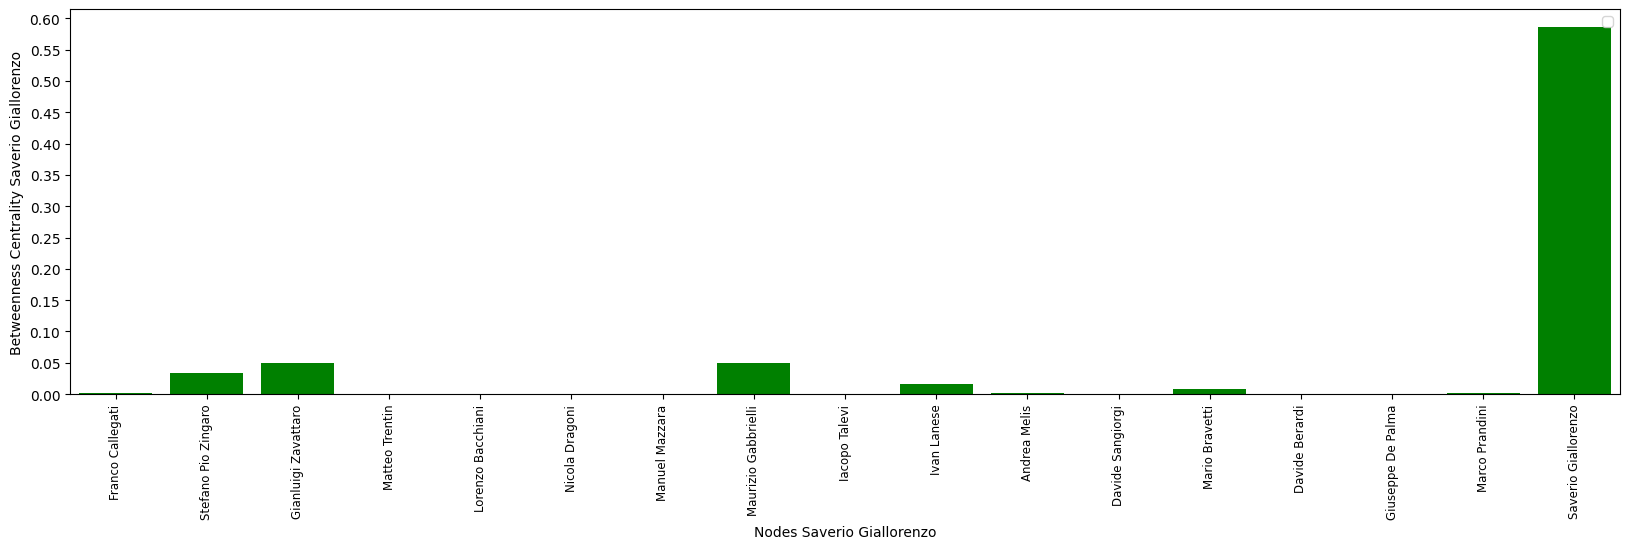

Author Succi G
Centrality {'Ciancarini P': 0.0, 'Sillitti A': 0.0, 'Succi G': 1.0, 'Russo B': 0.0}


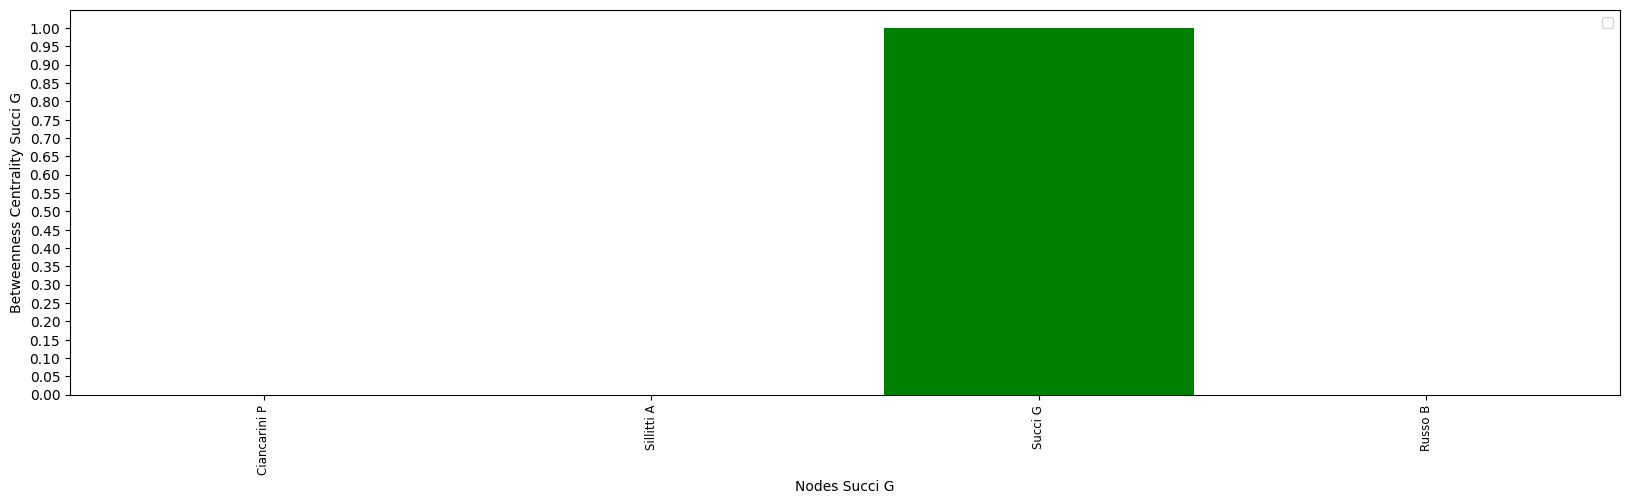

Author OMICINI, ANDREA
Centrality {'CROATTI, ANGELO': 0.0, 'PIANCASTELLI, GIULIO': 0.0014336917562724014, 'CASADEI, MATTEO': 0.005017921146953404, 'OMICINI, ANDREA': 0.6525806451612903, 'TORRONI, PAOLO': 0.001075268817204301, 'Stefano Mariani': 0.0, 'MATTEUCCI, MARIA CRISTINA': 0.0, 'GAFFURI, PIETRO': 0.0007168458781362007, 'BENINI, ALEX': 0.0, 'CEVENINI, CLAUDIA': 0.0, 'RICCI, ALESSANDRO': 0.062043010752688164, 'SBARAGLIA, MARCO': 0.0, 'MILANO, MICHELA': 0.0, 'RUBINO, ROSSELLA': 0.0014336917562724014, 'SARTOR, GIOVANNI': 0.002150537634408602, 'PIUNTI, MICHELE': 0.0, 'CONTUCCI, PIERLUIGI': 0.0, 'Mariani, Stefano': 0.0, 'DENTI, ENRICO': 0.05551971326164874, 'ZAGHINI, NICOLA': 0.0, 'CIATTO, GIOVANNI': 0.0, 'MOLESINI, AMBRA': 0.008530465949820789, 'NARDINI, ELENA': 0.00913978494623656, 'GARDELLI, LUCA': 0.0011469534050179211, 'OLIVA, ENRICO': 0.0005376344086021505, 'CALEGARI, ROBERTA': 0.0007168458781362007, 'MONTAGNA, SARA': 0.002903225806451613, 'PIANINI, DANILO': 0.0008602150537634409,

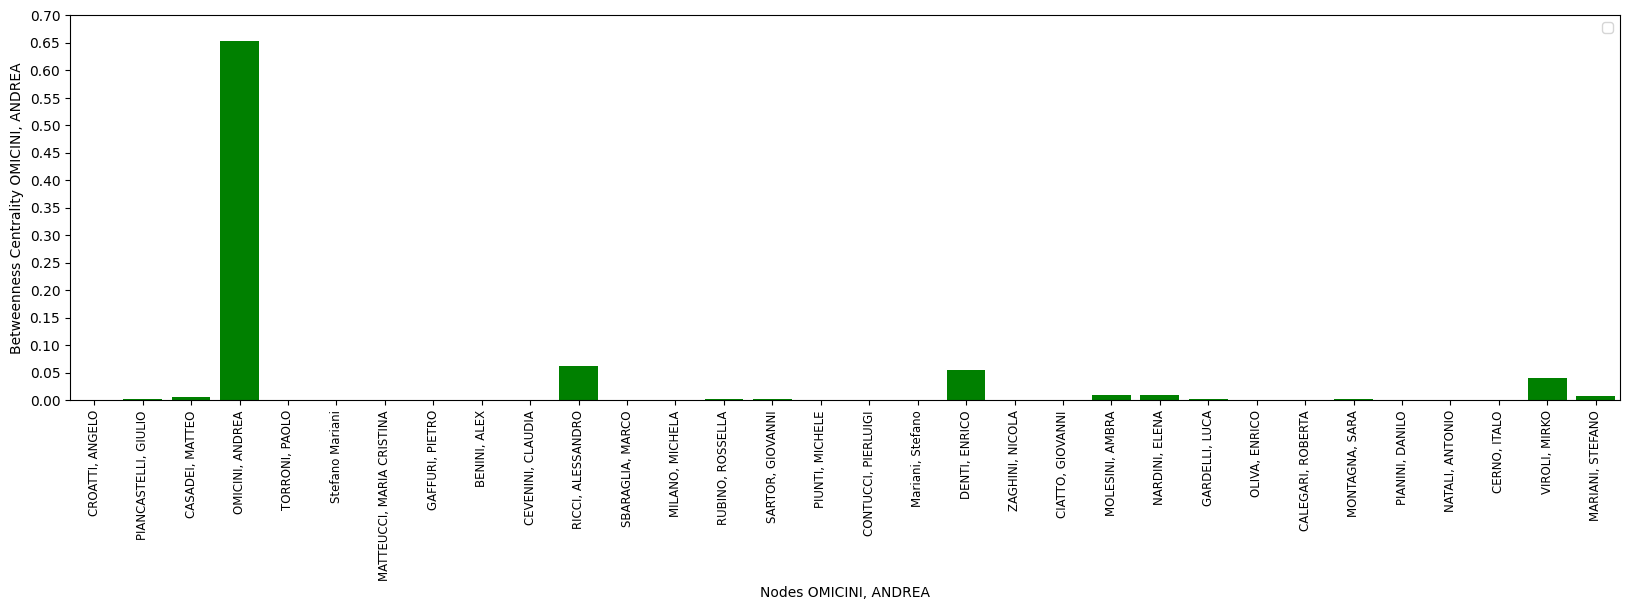

Author ROCCETTI, MARCO
Centrality {'CONFORTI, VITO': 0.0, 'MARTINI, SIMONE': 0.0, 'Bujari, A.': 0.0, 'ROVERSI, MONACO': 0.0, 'PAU, GIOVANNI': 0.0001451378809869376, 'GHINI, VITTORIO': 0.00129414610546686, 'BERTUCCIOLI, CRISTIAN': 0.0004716981132075472, 'PIZZINELLI, ALBERTO': 0.0, 'MURATORI, LUDOVICO ANTONIO': 0.0006047411707789065, 'A. Bujari': 0.0, 'PALAZZI, CLAUDIO ENRICO': 0.0028664731494920173, 'CARACENI, SIMONA': 0.0, 'CORRADI, ANTONIO': 0.0, 'F. Vitali': 0.0, 'MASCIO, ANTONELLA': 0.0, 'BOARI, MAURELIO': 0.0, 'ROCCETTI, MARCO': 0.6171746492501208, 'SALOMONI, PAOLA': 0.11042573778422834, 'CACCIAGUERRA, STEFANO': 0.0021770682148040637, 'PANZIERI, FABIO': 0.0009917755200774068, 'MARFIA, GUSTAVO': 0.10128205128205128, 'LOMI, ALESSANDRO': 0.0, 'FERRETTI, STEFANO': 0.007752781809385582, 'ZANICHELLI, MARCO': 0.000725689404934688, 'Valva, Antonella': 0.0, 'MONTAGNANI, MARCO': 0.0008708272859216257, 'VITALI, FABIO': 0.0017779390420899857, 'CECCHERELLI, ANDREA': 0.000181422351233672, 'CERVI

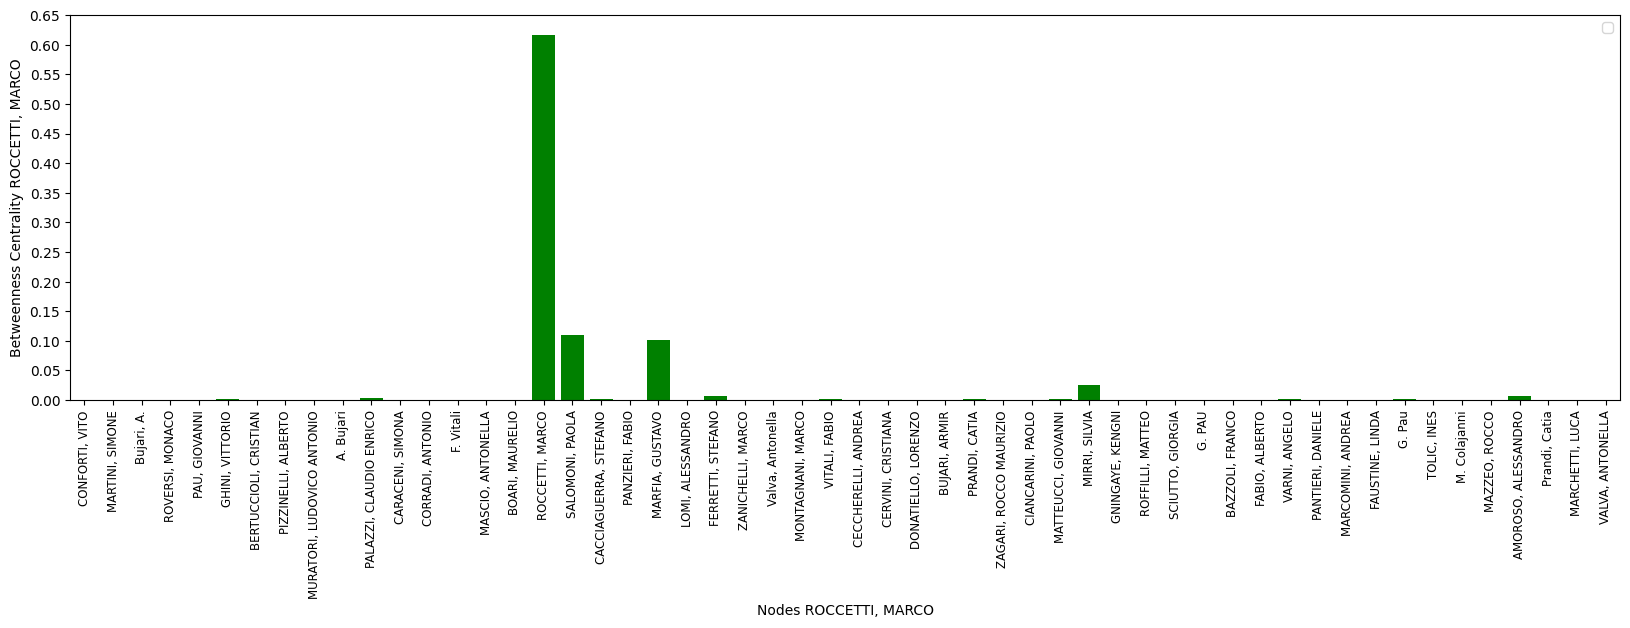

In [18]:
for author, centrality in betweenness_centrality_subgraphs.items():
    print(f"Author {author}")
    print(f"Centrality {centrality}")
    
    betweenness_nodes = centrality.keys()
    betweenness_centralities = centrality.values()

    plt.figure(figsize=(20,5))
    plt.bar(betweenness_nodes, betweenness_centralities, color='g')
    plt.xlabel(f'Nodes {author}')
    plt.ylabel(f'Betweenness Centrality {author}')
    plt.legend()
    plt.xticks(rotation=90, fontsize = 8.5)
    plt.yticks(np.arange(0, max(betweenness_centralities)+ 0.05, 0.05))
    plt.xlim(-0.5, len(betweenness_nodes)-0.5)
    plt.show()

In [19]:
threshold = 0.01  # Definisci la soglia per la centralità di betweenness

high_betweenness_nodes_subgraphs = {}

# Itera sui sottografi e calcola la centralità di betweenness
for author, subgraph in betweenness_centrality_subgraphs.items():
    # Filtra i nodi con centralità di betweenness superiore alla soglia
    high_betweenness_nodes_subgraphs[author] = [
        node for node, bet in subgraph.items() if bet > threshold
    ]

# Stampa i nodi con centralità di betweenness superiore alla soglia per ciascun autore
for author, high_betweenness_nodes in high_betweenness_nodes_subgraphs.items():
    print(f"{author} - Nodes with betweenness centrality above {threshold}: {high_betweenness_nodes}")


Saverio Giallorenzo - Nodes with betweenness centrality above 0.01: ['Stefano Pio Zingaro', 'Gianluigi Zavattaro', 'Maurizio Gabbrielli', 'Ivan Lanese', 'Saverio Giallorenzo']
Succi G - Nodes with betweenness centrality above 0.01: ['Succi G']
OMICINI, ANDREA - Nodes with betweenness centrality above 0.01: ['OMICINI, ANDREA', 'RICCI, ALESSANDRO', 'DENTI, ENRICO', 'VIROLI, MIRKO']
ROCCETTI, MARCO - Nodes with betweenness centrality above 0.01: ['ROCCETTI, MARCO', 'SALOMONI, PAOLA', 'MARFIA, GUSTAVO', 'MIRRI, SILVIA']


#### Betweenness Centrality ***distribution***



Author Saverio Giallorenzo
Centrality {'Franco Callegati': 0.0020833333333333333, 'Stefano Pio Zingaro': 0.03333333333333333, 'Gianluigi Zavattaro': 0.04999999999999999, 'Matteo Trentin': 0.0, 'Lorenzo Bacchiani': 0.0, 'Nicola Dragoni': 0.0, 'Manuel Mazzara': 0.0, 'Maurizio Gabbrielli': 0.05, 'Iacopo Talevi': 0.0, 'Ivan Lanese': 0.016666666666666666, 'Andrea Melis': 0.0020833333333333333, 'Davide Sangiorgi': 0.0, 'Mario Bravetti': 0.008333333333333333, 'Davide Berardi': 0.0, 'Giuseppe De Palma': 0.0, 'Marco Prandini': 0.0020833333333333333, 'Saverio Giallorenzo': 0.5854166666666667}


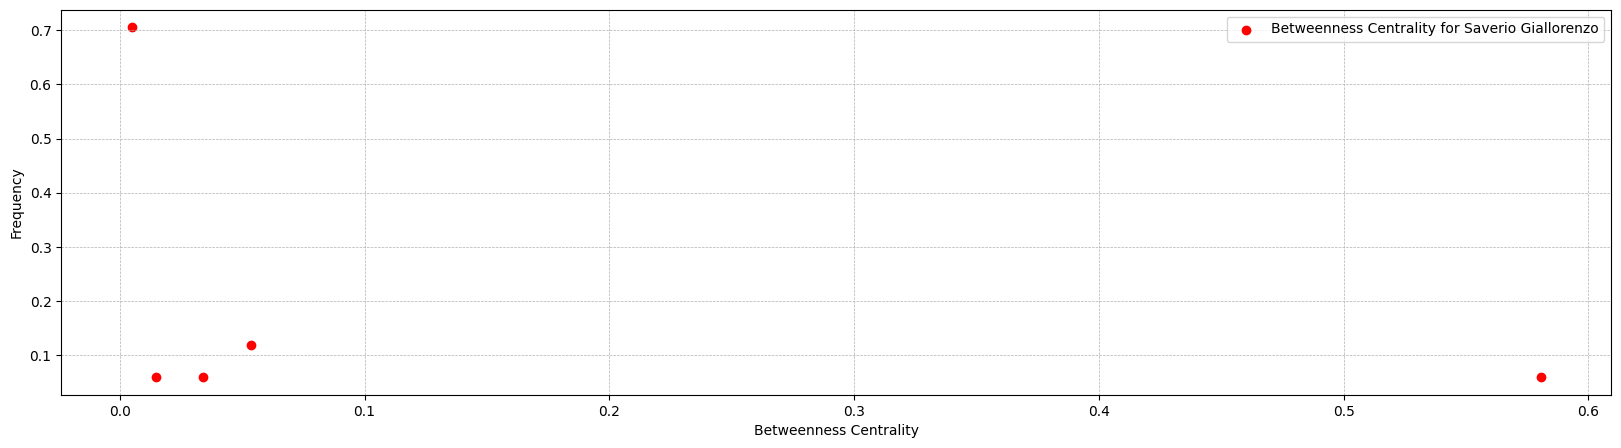

Author Succi G
Centrality {'Ciancarini P': 0.0, 'Sillitti A': 0.0, 'Succi G': 1.0, 'Russo B': 0.0}


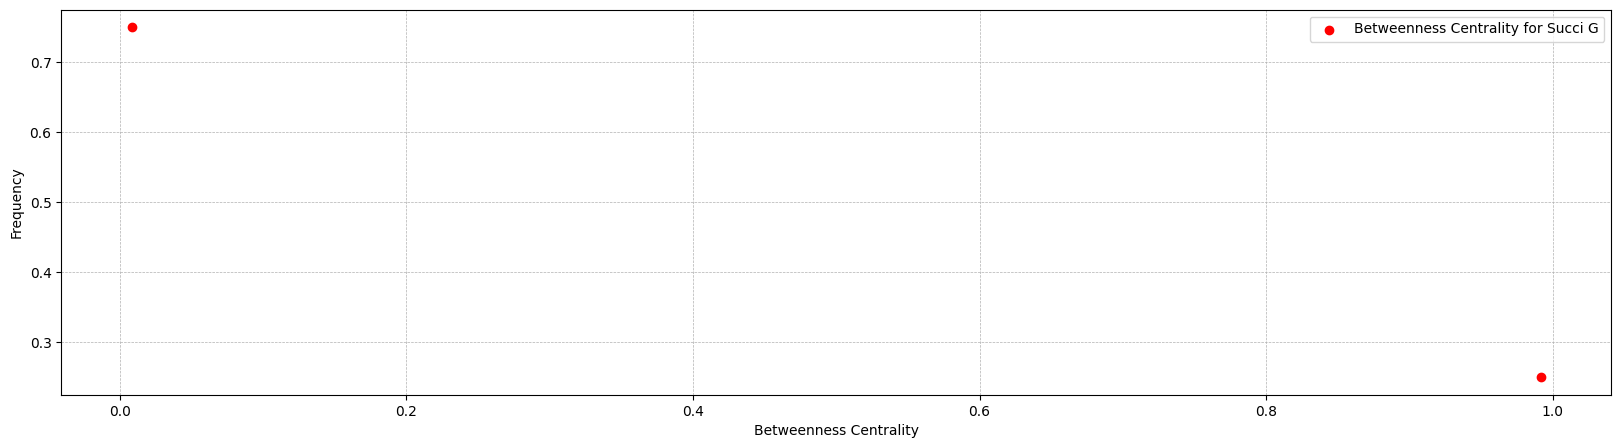

Author OMICINI, ANDREA
Centrality {'CROATTI, ANGELO': 0.0, 'PIANCASTELLI, GIULIO': 0.0014336917562724014, 'CASADEI, MATTEO': 0.005017921146953404, 'OMICINI, ANDREA': 0.6525806451612903, 'TORRONI, PAOLO': 0.001075268817204301, 'Stefano Mariani': 0.0, 'MATTEUCCI, MARIA CRISTINA': 0.0, 'GAFFURI, PIETRO': 0.0007168458781362007, 'BENINI, ALEX': 0.0, 'CEVENINI, CLAUDIA': 0.0, 'RICCI, ALESSANDRO': 0.062043010752688164, 'SBARAGLIA, MARCO': 0.0, 'MILANO, MICHELA': 0.0, 'RUBINO, ROSSELLA': 0.0014336917562724014, 'SARTOR, GIOVANNI': 0.002150537634408602, 'PIUNTI, MICHELE': 0.0, 'CONTUCCI, PIERLUIGI': 0.0, 'Mariani, Stefano': 0.0, 'DENTI, ENRICO': 0.05551971326164874, 'ZAGHINI, NICOLA': 0.0, 'CIATTO, GIOVANNI': 0.0, 'MOLESINI, AMBRA': 0.008530465949820789, 'NARDINI, ELENA': 0.00913978494623656, 'GARDELLI, LUCA': 0.0011469534050179211, 'OLIVA, ENRICO': 0.0005376344086021505, 'CALEGARI, ROBERTA': 0.0007168458781362007, 'MONTAGNA, SARA': 0.002903225806451613, 'PIANINI, DANILO': 0.0008602150537634409,

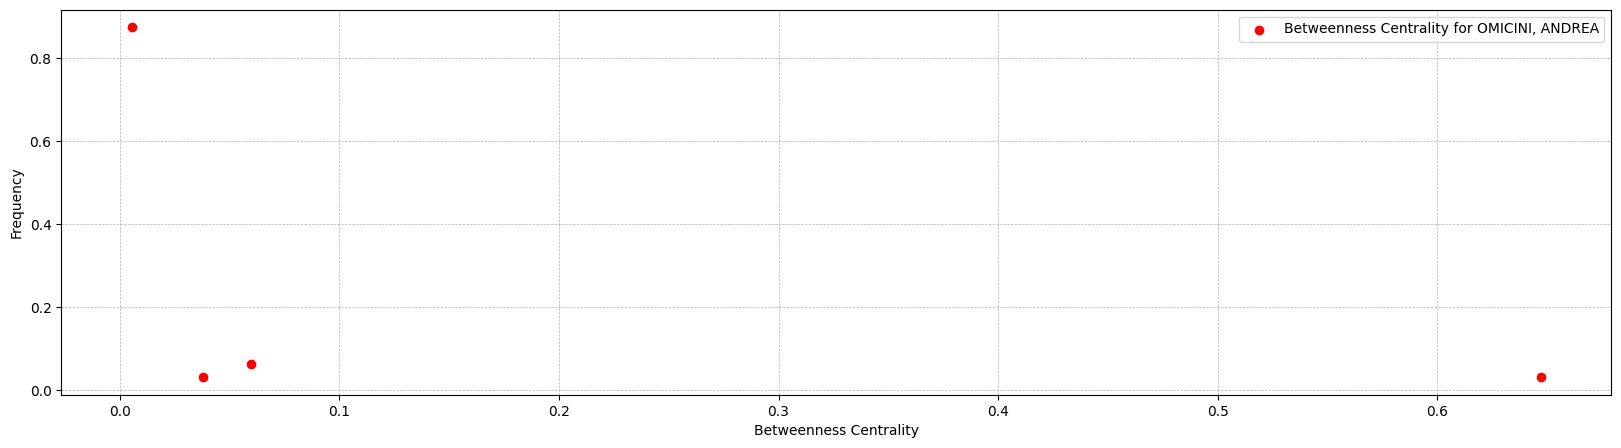

Author ROCCETTI, MARCO
Centrality {'CONFORTI, VITO': 0.0, 'MARTINI, SIMONE': 0.0, 'Bujari, A.': 0.0, 'ROVERSI, MONACO': 0.0, 'PAU, GIOVANNI': 0.0001451378809869376, 'GHINI, VITTORIO': 0.00129414610546686, 'BERTUCCIOLI, CRISTIAN': 0.0004716981132075472, 'PIZZINELLI, ALBERTO': 0.0, 'MURATORI, LUDOVICO ANTONIO': 0.0006047411707789065, 'A. Bujari': 0.0, 'PALAZZI, CLAUDIO ENRICO': 0.0028664731494920173, 'CARACENI, SIMONA': 0.0, 'CORRADI, ANTONIO': 0.0, 'F. Vitali': 0.0, 'MASCIO, ANTONELLA': 0.0, 'BOARI, MAURELIO': 0.0, 'ROCCETTI, MARCO': 0.6171746492501208, 'SALOMONI, PAOLA': 0.11042573778422834, 'CACCIAGUERRA, STEFANO': 0.0021770682148040637, 'PANZIERI, FABIO': 0.0009917755200774068, 'MARFIA, GUSTAVO': 0.10128205128205128, 'LOMI, ALESSANDRO': 0.0, 'FERRETTI, STEFANO': 0.007752781809385582, 'ZANICHELLI, MARCO': 0.000725689404934688, 'Valva, Antonella': 0.0, 'MONTAGNANI, MARCO': 0.0008708272859216257, 'VITALI, FABIO': 0.0017779390420899857, 'CECCHERELLI, ANDREA': 0.000181422351233672, 'CERVI

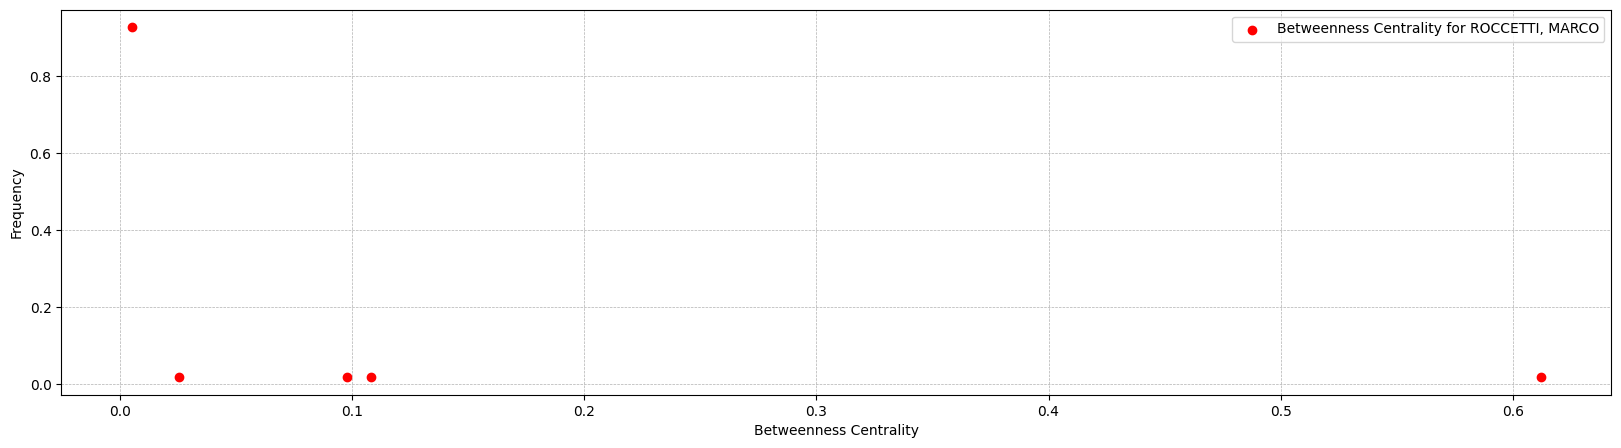

In [20]:
for author, centrality in betweenness_centrality_subgraphs.items():
    print(f"Author {author}")
    print(f"Centrality {centrality}")
    
    # Ottieni i valori della centralità di betweenness
    values = list(centrality.values())

    # Calcola l'istogramma
    freq, bins = np.histogram(values, bins=60)

    # Trova il centro di ciascun bin
    bins = (bins[:-1] + bins[1:]) / 2

    # Calcola la frequenza normalizzata in base al numero di nodi nel sottografo
    num_nodes = len(subgraphs[author].nodes())  # Numero di nodi nel sottografo
    freq = [i / num_nodes for i in freq]  # Normalizza la frequenza

    # Converti la frequenza in un array numpy
    freq = np.array(freq, dtype='float32')

    # Filtra i valori non nulli
    non_zero_indices = np.where(freq > 0)
    bins = bins[non_zero_indices]
    freq = freq[non_zero_indices]

    # Crea il grafico a dispersione
    plt.figure(figsize=(20, 5))
    plt.scatter(bins, freq, color='r', label=f'Betweenness Centrality for {author}')
    plt.legend()
    plt.xlabel('Betweenness Centrality')
    plt.ylabel('Frequency')
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    plt.show()


### Estrazione dei valori di centralità di betweenness

Il grafico logaritmico sui due assi viene spesso utilizzato quando si sospetta che la distribuzione dei dati segua una legge di potenza (ad esempio, una distribuzione di tipo Pareto o Zipf). Se la distribuzione cumulativa segue una retta nel grafico log-log, significa che i dati seguono effettivamente una legge di potenza, il che implica che una piccola percentuale di nodi (con alta centralità di betweenness) controlla la maggior parte delle connessioni nella rete.

- Il grafico lineare mostra la distribuzione cumulativa normale.
- Il grafico log-log è utile per identificare la presenza di una legge di potenza o per analizzare la distribuzione in modo che le differenze tra valori estremamente grandi e piccoli siano più chiare.
- La centralità di betweenness è utile per identificare i nodi che svolgono un ruolo cruciale nel flusso di informazioni o nel controllo della rete.

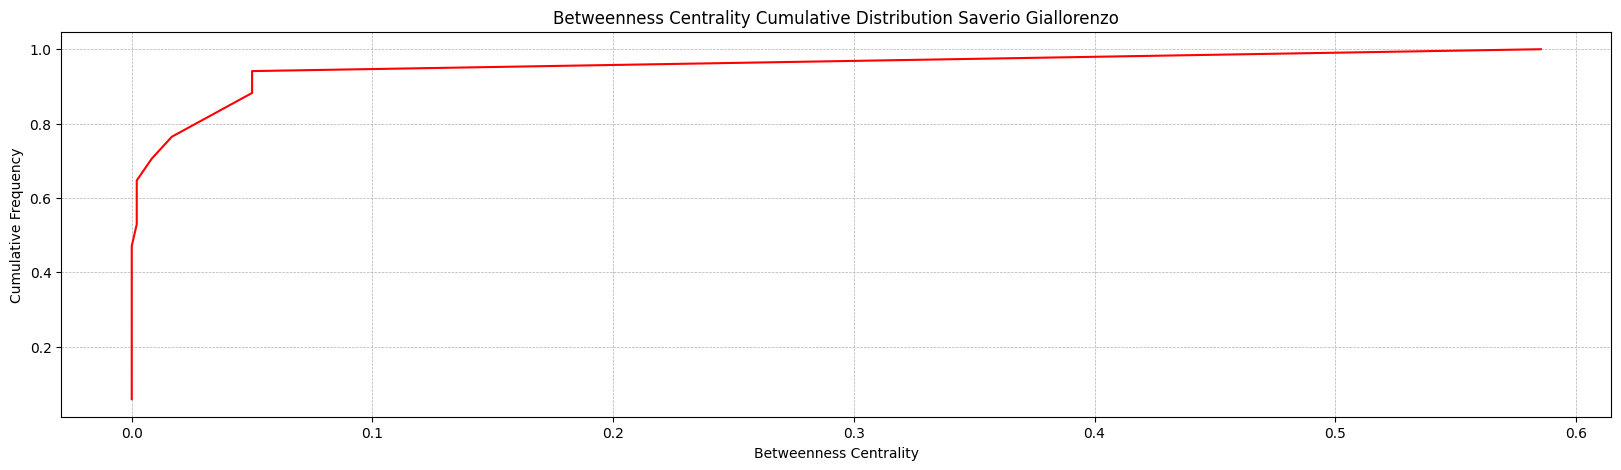

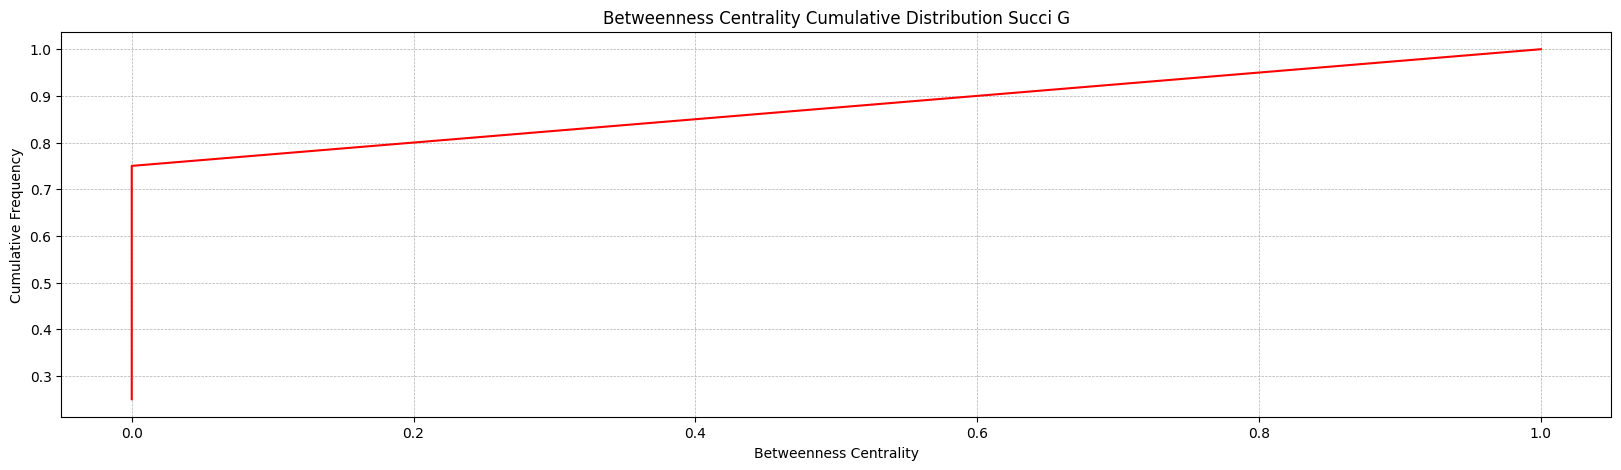

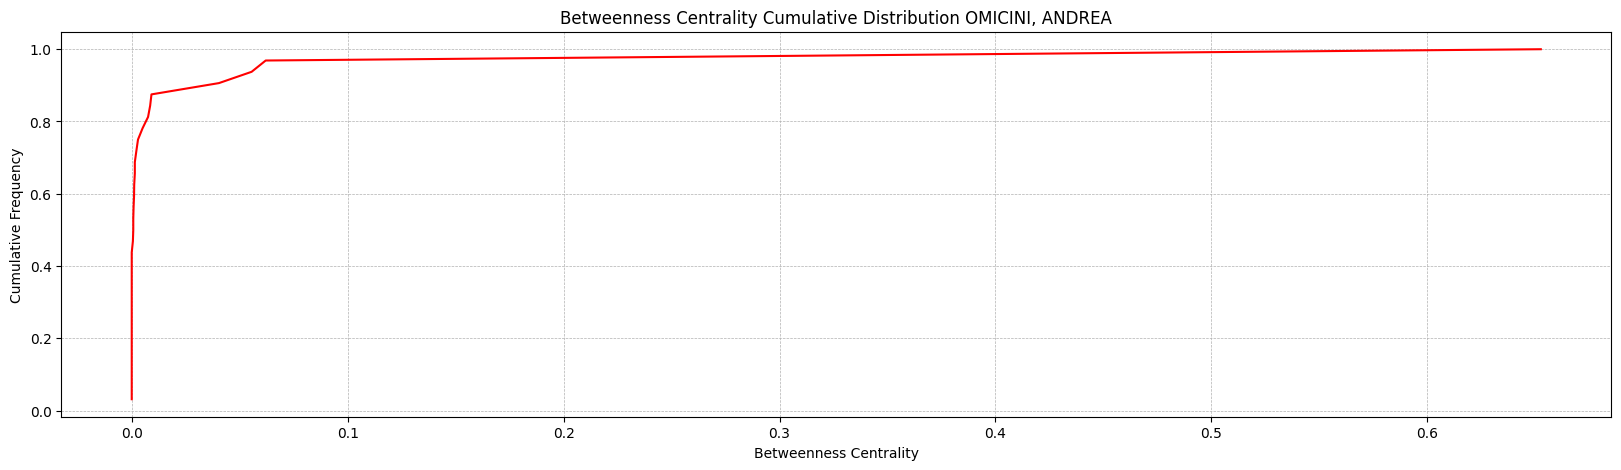

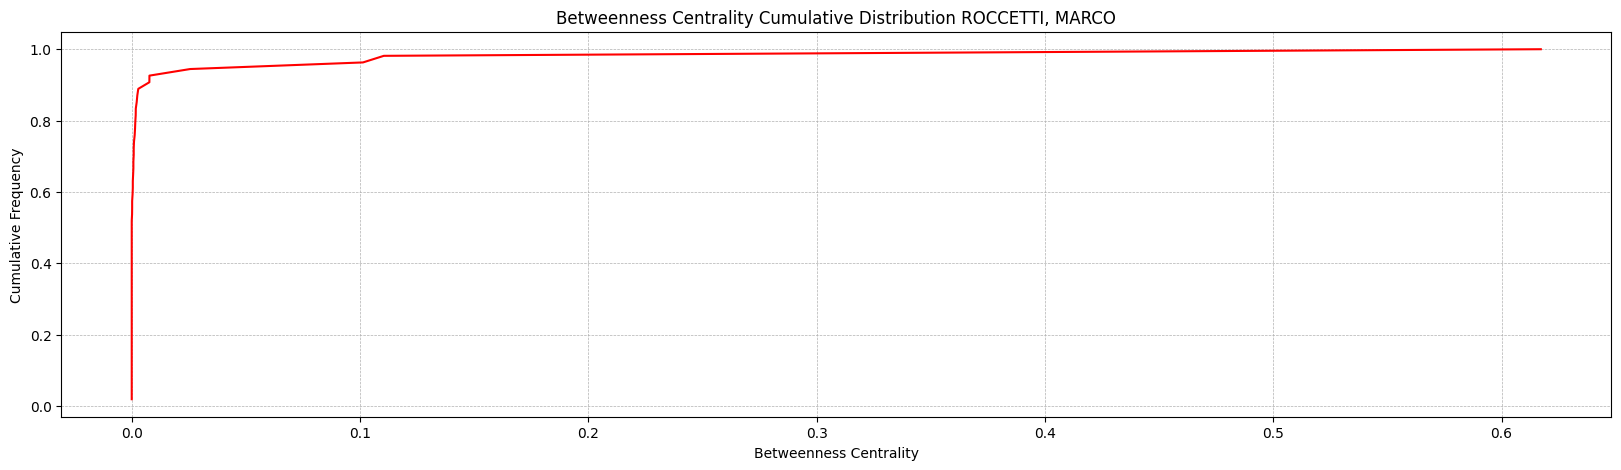

In [21]:
for author, centrality in betweenness_centrality_subgraphs.items():
    values = list(centrality.values())
    values.sort()

    # Compute the cumulative frequencies
    cumulative_frequencies = np.cumsum(np.ones(len(values)) / len(values))

    plt.figure(figsize=(20,5))

    plt.plot(values, cumulative_frequencies, color = 'r')
    plt.xlabel('Betweenness Centrality')
    plt.ylabel('Cumulative Frequency')
    plt.title(f'Betweenness Centrality Cumulative Distribution {author}')
    plt.grid(True, ls="--", linewidth=0.5)
    
    plt.show()

## Closeness centrality

In [22]:
closeness_centrality_subgraphs = {}

for author, subgraph in subgraphs.items():
    closeness_centrality_subgraphs[author] = nx.closeness_centrality(subgraph)

C:\Users\valde\AppData\Local\Temp\ipykernel_13908\2584844392.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


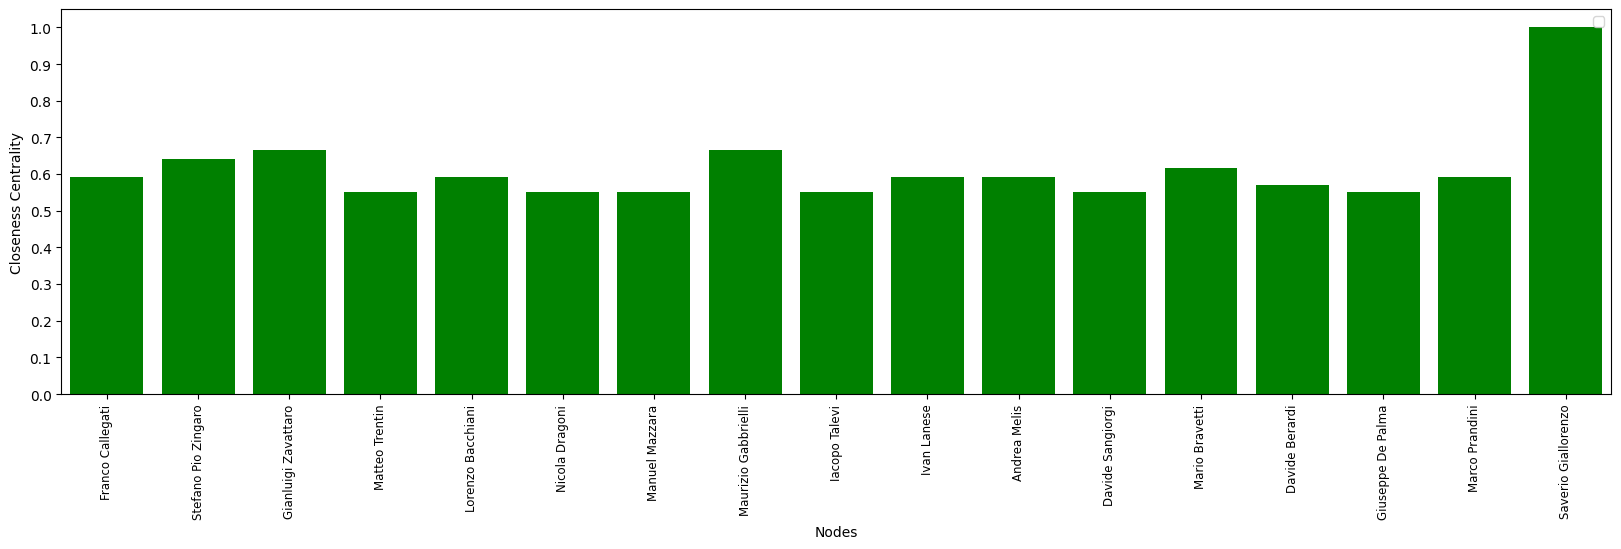

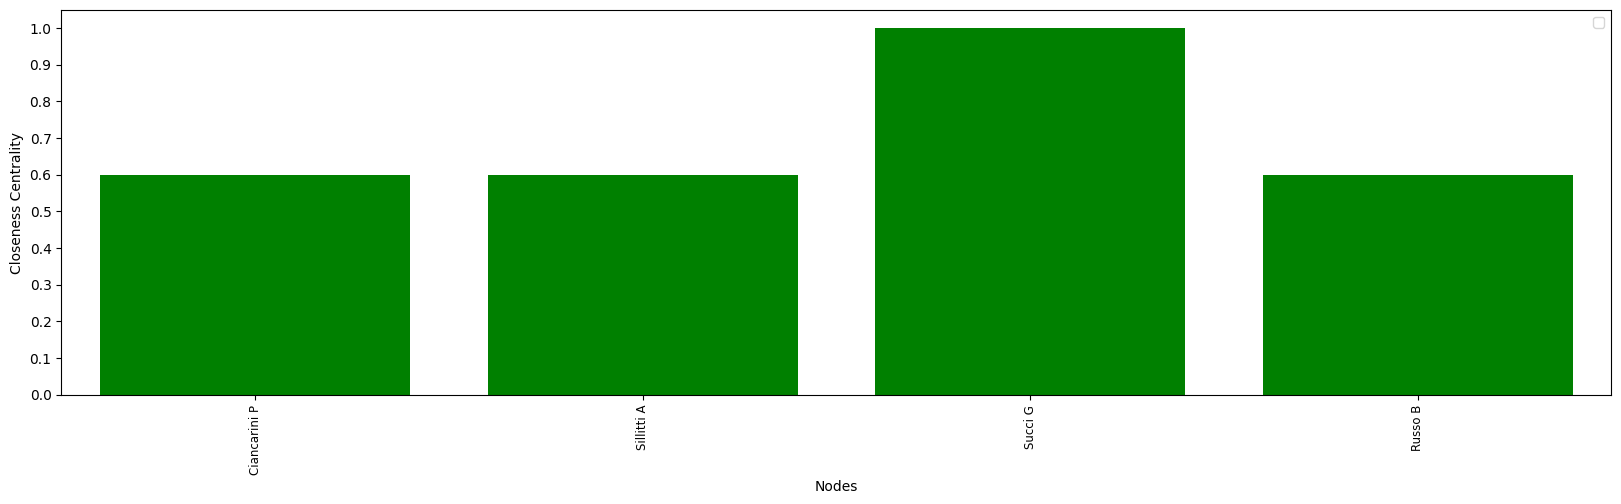

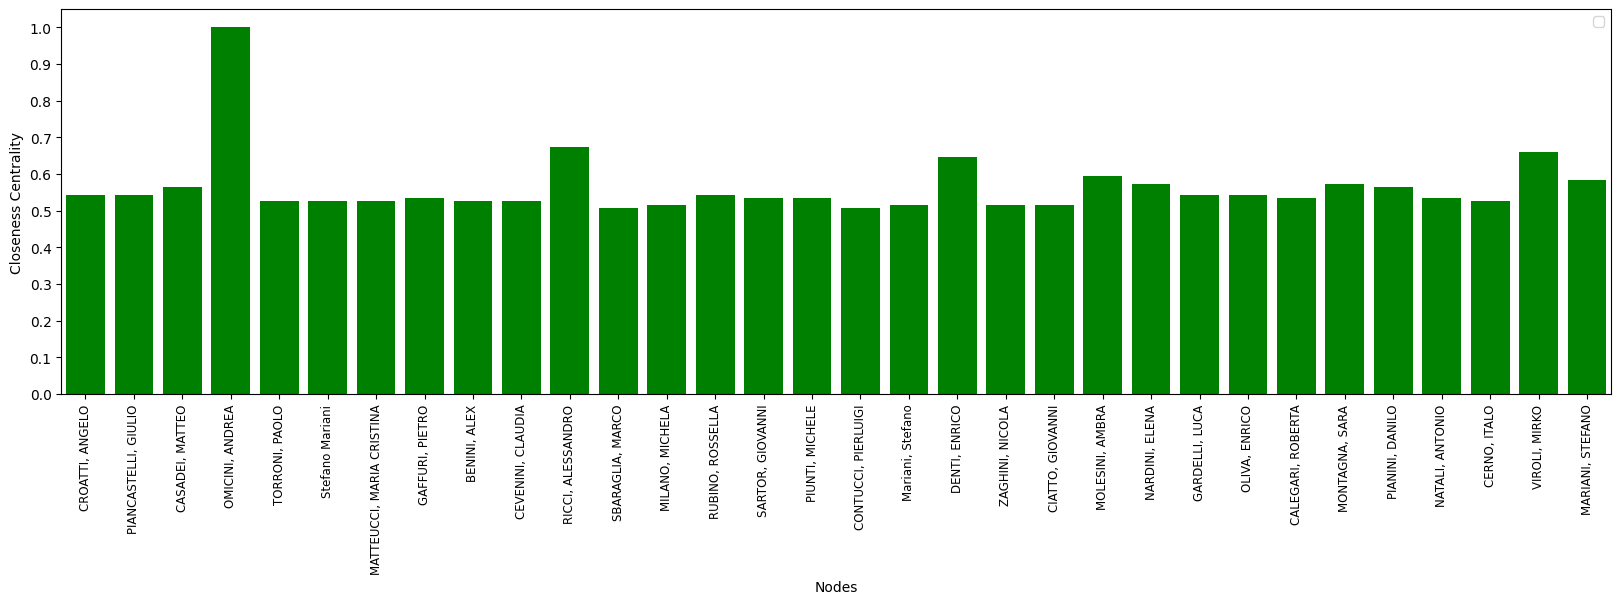

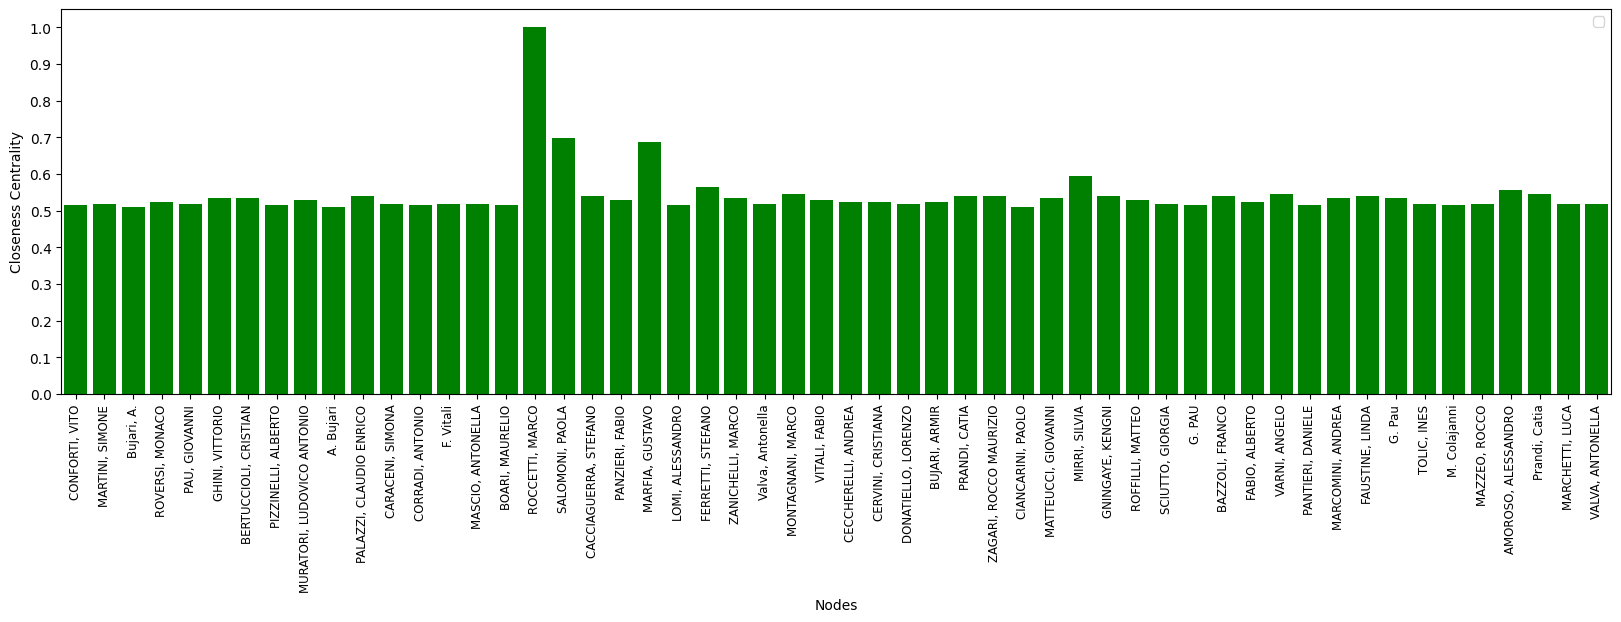

In [23]:
for author, centrality in closeness_centrality_subgraphs.items():
    closeness_nodes = centrality.keys()
    closeness_centralities = centrality.values()

    plt.figure(figsize=(20,5))
    plt.bar(closeness_nodes, closeness_centralities, color='g')
    plt.xlabel('Nodes')
    plt.ylabel('Closeness Centrality')
    plt.legend()
    plt.xticks(rotation=90, fontsize = 8.5)
    plt.yticks(np.arange(0, max(closeness_centralities)+ 0.05, 0.1))
    plt.xlim(-0.5, len(closeness_nodes)-0.5)
    plt.show()

### Centralità di prossimità
Calcolo della **centralità di prossimità** (closeness centrality) per ogni nodo in ogni sottografo e visualizza i risultati tramite un grafico a barre.

- **Centralità di prossimità (Closeness Centrality)**: Misura quanto un nodo è "centrale" in una rete. Un nodo con alta centralità di prossimità è vicino a tutti gli altri nodi, quindi può raggiungere rapidamente altri nodi.
- **Grafico a barre**: Questo tipo di grafico è utile per visualizzare la centralità di ciascun nodo individualmente, mostrando la "forza" della centralità di ciascun nodo rispetto agli altri.

C:\Users\valde\AppData\Local\Temp\ipykernel_13908\1692082524.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


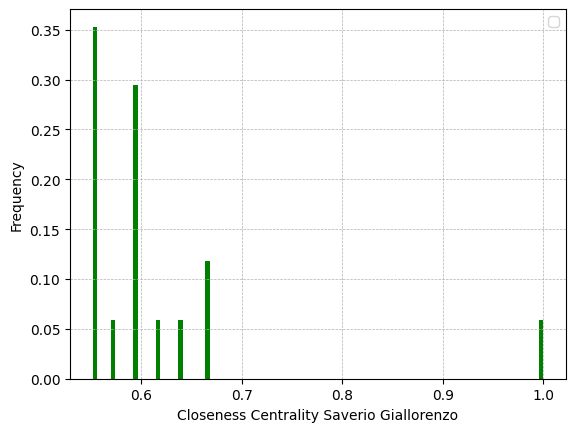

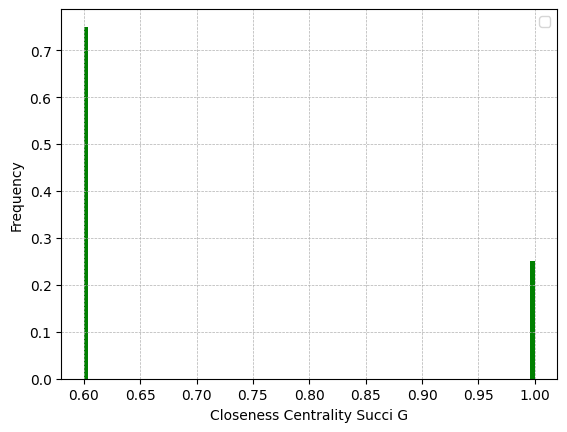

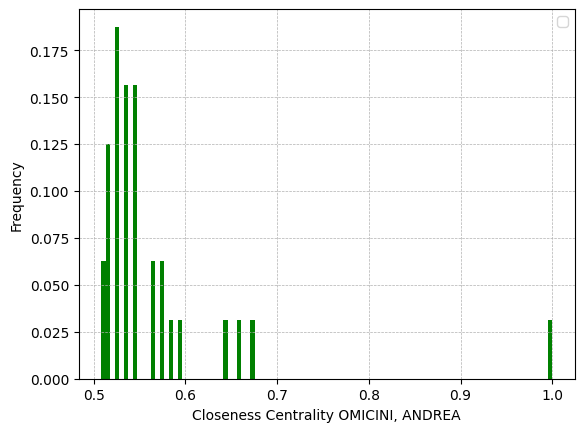

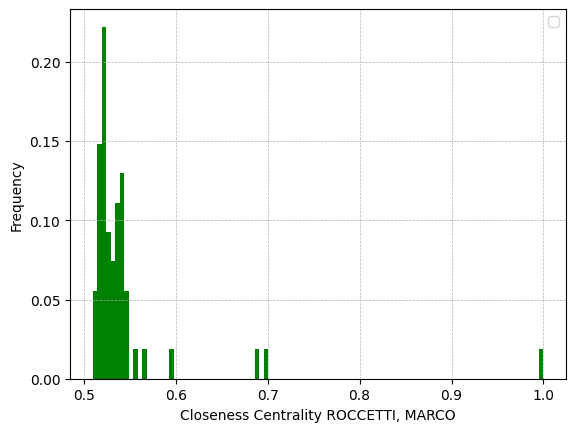

In [24]:
for author, centrality in closeness_centrality_subgraphs.items():
    values_all = list(centrality.values())

    plt.hist(values_all, bins=100, color = 'g', weights=np.ones(len(values_all)) / len(values_all))
    plt.xlabel(f'Closeness Centrality {author}')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()

Calcolo della media delle centralità di prossimità di tutti i nodi nei sottografi. La centralità di prossimità misura quanto un nodo sia vicino a tutti gli altri nodi del grafo, ed è un indicatore importante di "accessibilità" o "influenza" di un nodo all'interno di una rete.

In [25]:
for author, centrality in closeness_centrality_subgraphs.items():
    # Estrai i valori delle centralità di prossimità
    values_all = list(centrality.values())

    # Calcola il valore medio
    mean = np.mean(values_all)

    print(f"The mean value of the closeness centralityfor the author {author} is: {mean}")

The mean value of the closeness centralityfor the author Saverio Giallorenzo is: 0.6137326065115112
The mean value of the closeness centralityfor the author Succi G is: 0.7000000000000001
The mean value of the closeness centralityfor the author OMICINI, ANDREA is: 0.5644723671167886
The mean value of the closeness centralityfor the author ROCCETTI, MARCO is: 0.5437838612793561


### Calcolo del **coefficiente di clustering** 
Effettuato per ciascun nodo in ogni sottografo.

1. **Calcolo del coefficiente di clustering**:

    - Il coefficiente di clustering misura quanto un nodo è "ben collegato" ai suoi vicini. In altre parole, indica quanto i vicini di un nodo siano anche tra di loro connessi.

### Che cosa rappresenta il coefficiente di clustering?

Il coefficiente di clustering di un nodo in un grafo misura la **densità di collegamenti** tra i suoi vicini. Se i vicini di un nodo sono molto connessi tra loro, il coefficiente di clustering sarà alto. Se i vicini non sono connessi tra loro, il coefficiente sarà basso.

I valori ottenuti danno una misura di quanto ogni nodo sia "centrale" in termini di connessione ai suoi vicini. Un valore alto suggerisce che il nodo è ben integrato nella sua comunità, mentre un valore basso suggerisce che i vicini del nodo non sono ben connessi tra di loro.


In [26]:
clustering_coefficient_subgraphs = {}

for author, subgraph in subgraphs.items():
    clustering_coefficient_subgraphs[author] = nx.clustering(subgraph)

#Print the clustering coefficient for each node
for node, coeff in clustering_coefficient_subgraphs.items():
    print(f"Node {node} has clustering coefficient {coeff}")

Node Saverio Giallorenzo has clustering coefficient {'Franco Callegati': 0.9, 'Stefano Pio Zingaro': 0.6190476190476191, 'Gianluigi Zavattaro': 0.5357142857142857, 'Matteo Trentin': 1.0, 'Lorenzo Bacchiani': 1.0, 'Nicola Dragoni': 1.0, 'Manuel Mazzara': 1.0, 'Maurizio Gabbrielli': 0.5714285714285714, 'Iacopo Talevi': 1.0, 'Ivan Lanese': 0.6, 'Andrea Melis': 0.9, 'Davide Sangiorgi': 1.0, 'Mario Bravetti': 0.8, 'Davide Berardi': 1.0, 'Giuseppe De Palma': 1.0, 'Marco Prandini': 0.9, 'Saverio Giallorenzo': 0.25}
Node Succi G has clustering coefficient {'Ciancarini P': 0, 'Sillitti A': 0, 'Succi G': 0, 'Russo B': 0}
Node OMICINI, ANDREA has clustering coefficient {'CROATTI, ANGELO': 1.0, 'PIANCASTELLI, GIULIO': 0.8, 'CASADEI, MATTEO': 0.6666666666666666, 'OMICINI, ANDREA': 0.14623655913978495, 'TORRONI, PAOLO': 0.6666666666666666, 'Stefano Mariani': 1.0, 'MATTEUCCI, MARIA CRISTINA': 1.0, 'GAFFURI, PIETRO': 0.8333333333333334, 'BENINI, ALEX': 1.0, 'CEVENINI, CLAUDIA': 1.0, 'RICCI, ALESSANDRO

C:\Users\valde\AppData\Local\Temp\ipykernel_13908\2915882454.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


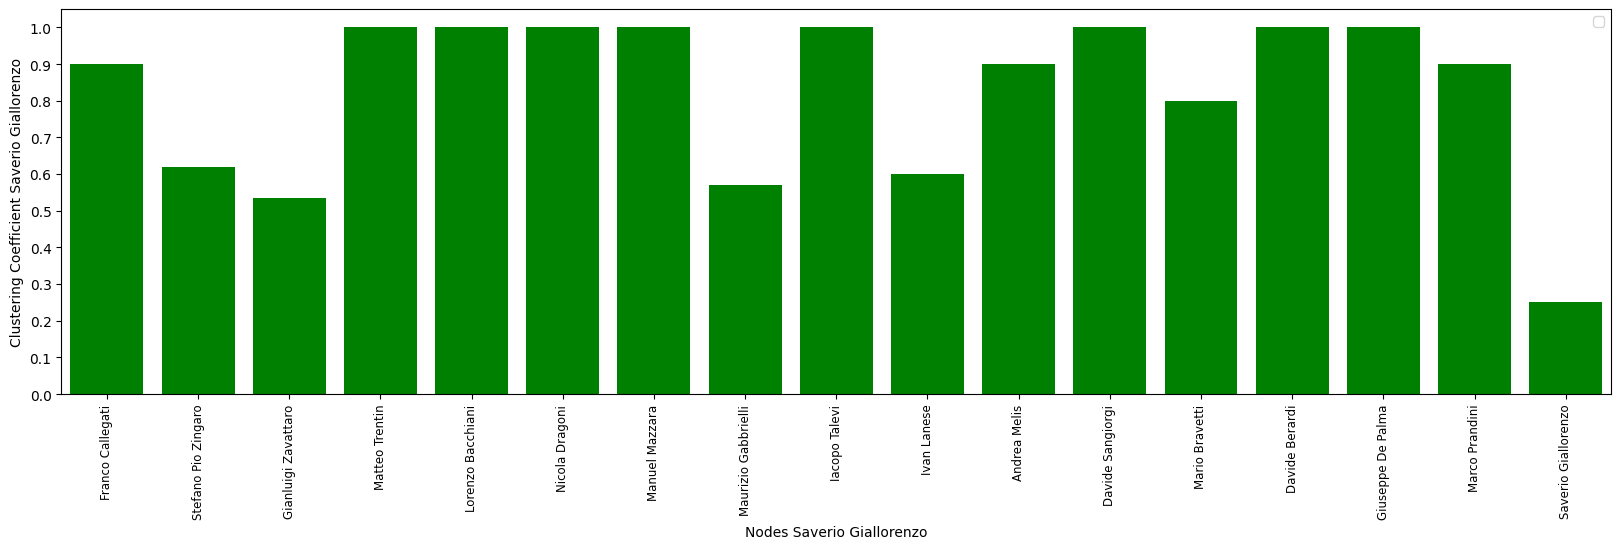

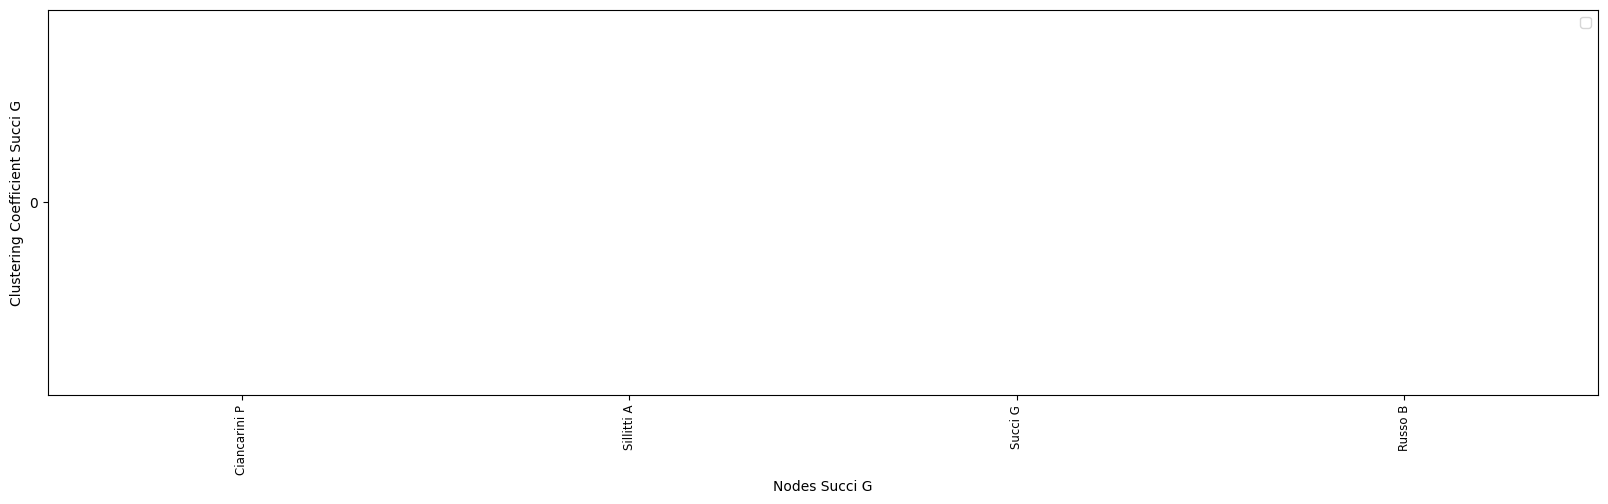

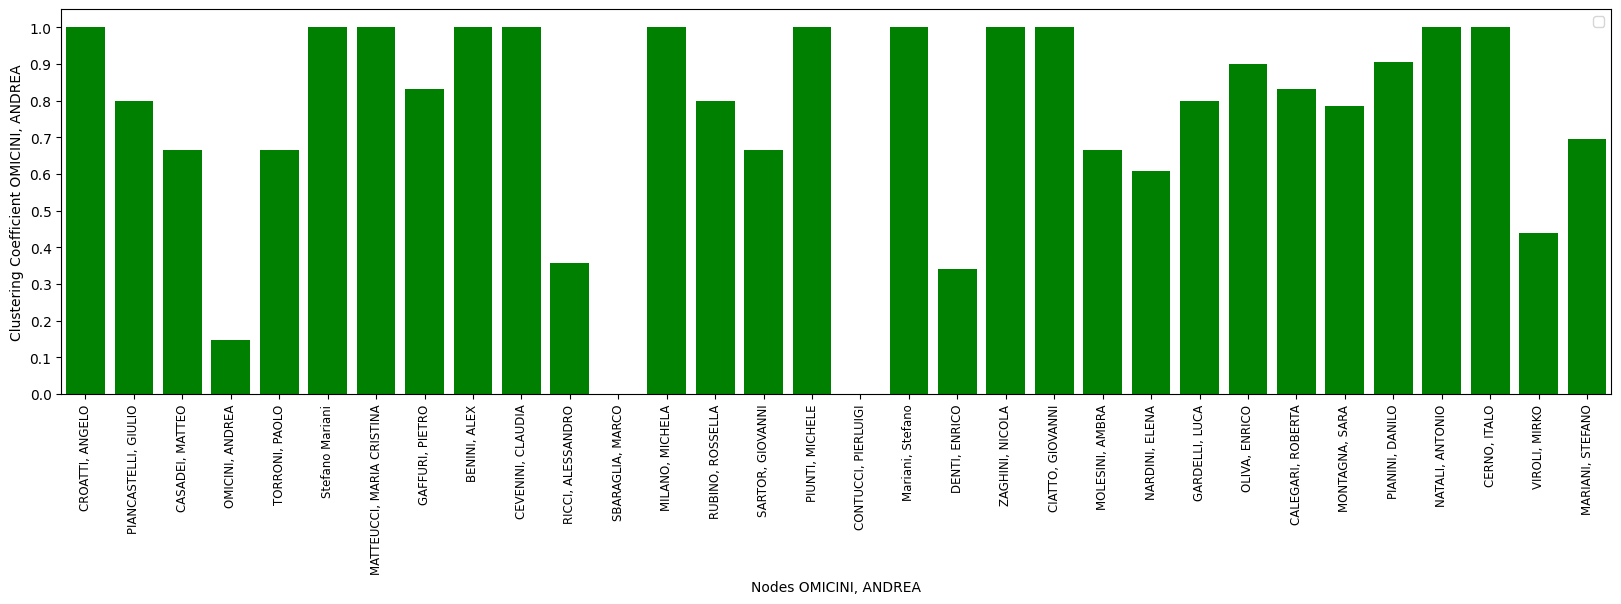

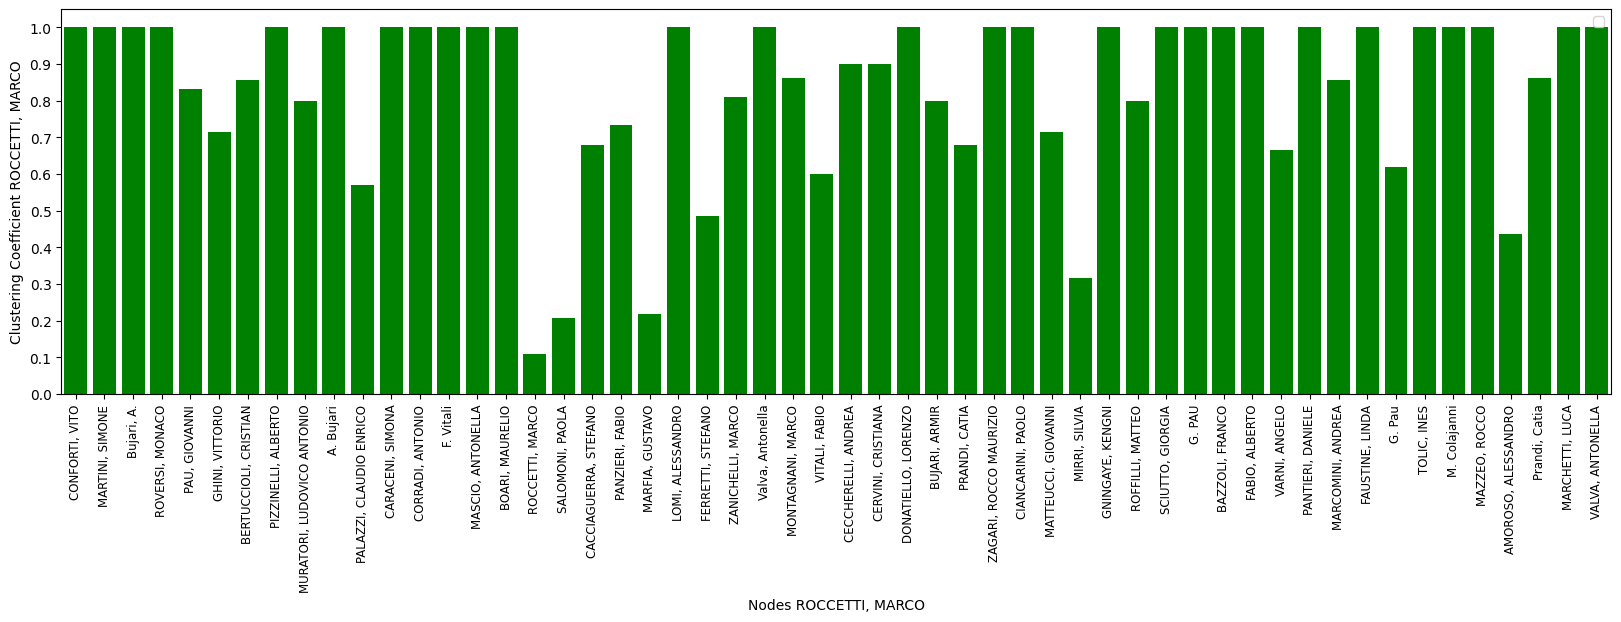

In [27]:
for author, centrality in clustering_coefficient_subgraphs.items():
    clustering_nodes_all = centrality.keys()
    clustering_values_all = centrality.values()

    plt.figure(figsize=(20,5))
    plt.bar(clustering_nodes_all, clustering_values_all, color='g')
    plt.xlabel(f'Nodes {author}')
    plt.ylabel(f'Clustering Coefficient {author}')
    plt.legend()
    plt.xticks(rotation=90, fontsize = 8.5)
    plt.yticks(np.arange(0, max(clustering_values_all)+ 0.05, 0.1))
    plt.xlim(-0.5, len(clustering_nodes_all)-0.5)
    plt.show()

#### Correlation between Local Clustering Coefficient C_i and Degree Centrality d
Grafico che esplora la relazione tra centralità di grado e coefficiente di clustering di ciascun nodo in ogni sottografo.

Il grafico a dispersione mostra come la centralità di grado di ciascun nodo (quanti collegamenti ha un nodo nel grafo) si relaziona con il suo coefficiente di clustering (quanto i suoi vicini sono connessi tra di loro). Ogni punto nel grafico rappresenta un nodo nel grafo. L'uso della scala logaritmica è particolarmente utile se i dati spaziano su un ampio intervallo, e questo è spesso il caso in grafi reali dove la distribuzione della centralità di grado e del coefficiente di clustering può variare drasticamente tra i nodi.

In generale, la centralità di grado misura quanto un nodo è "centrale" in termini di collegamenti diretti, mentre il coefficiente di clustering misura quanto il nodo sia "centrale" in termini di connessioni tra i suoi vicini. Un'alta centralità di grado potrebbe indicare un nodo con molte connessioni, mentre un alto coefficiente di clustering indica che quei vicini sono anche ben collegati tra di loro.

C:\Users\valde\AppData\Local\Temp\ipykernel_13908\3141969443.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


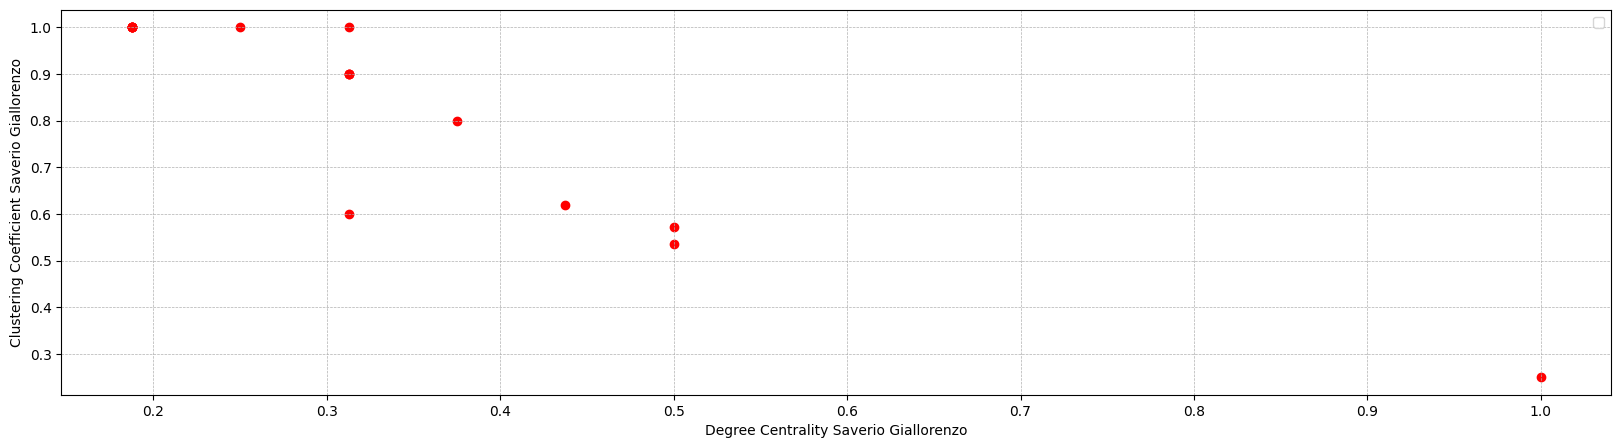

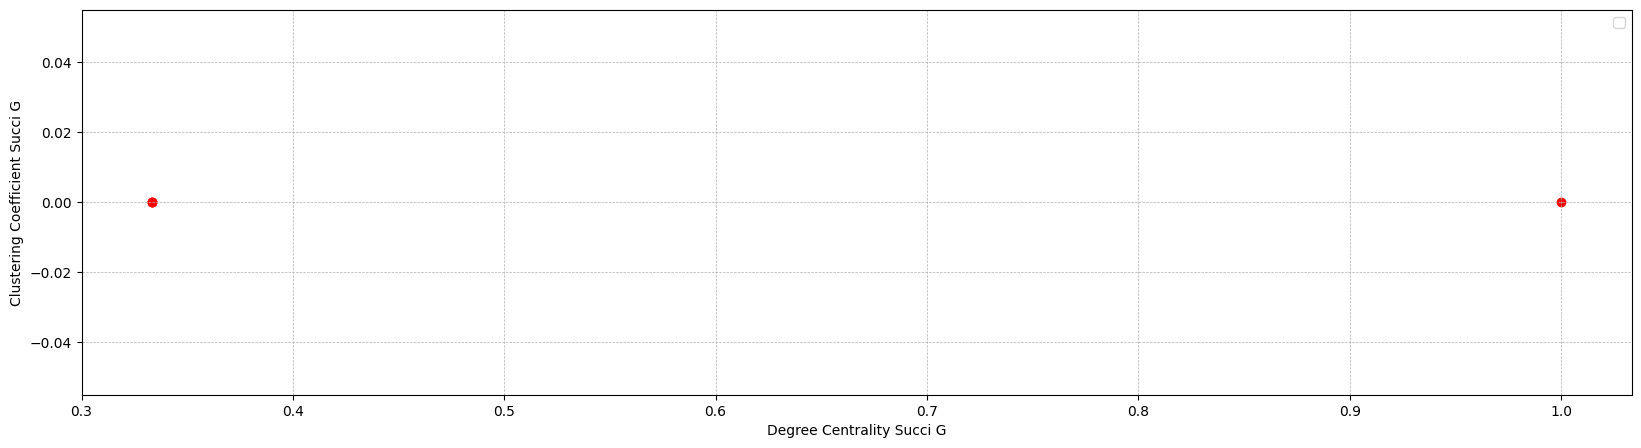

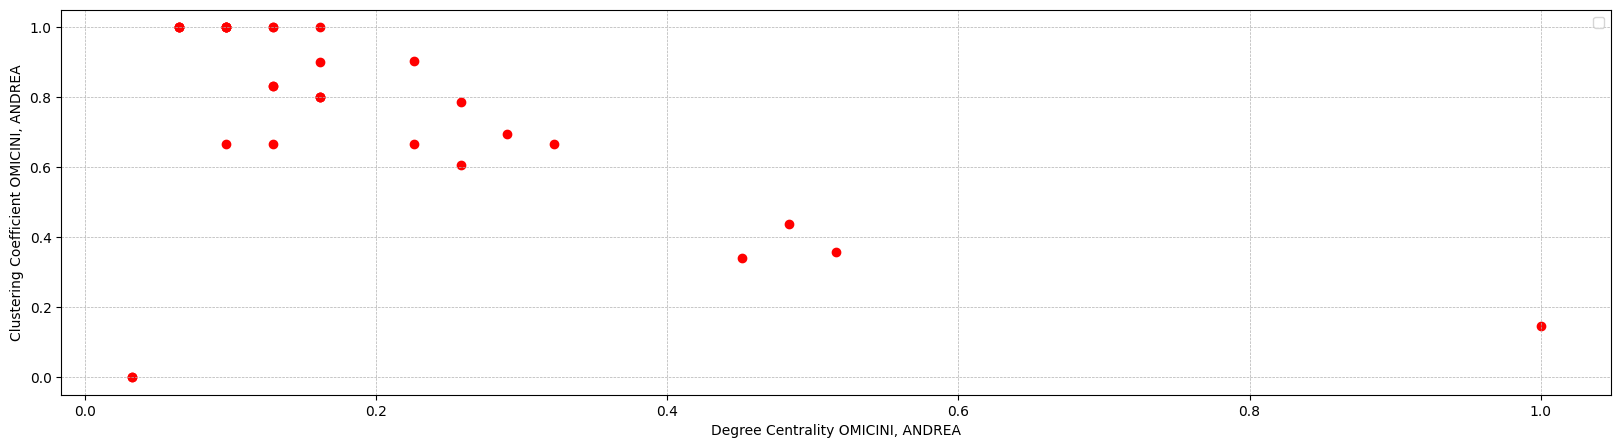

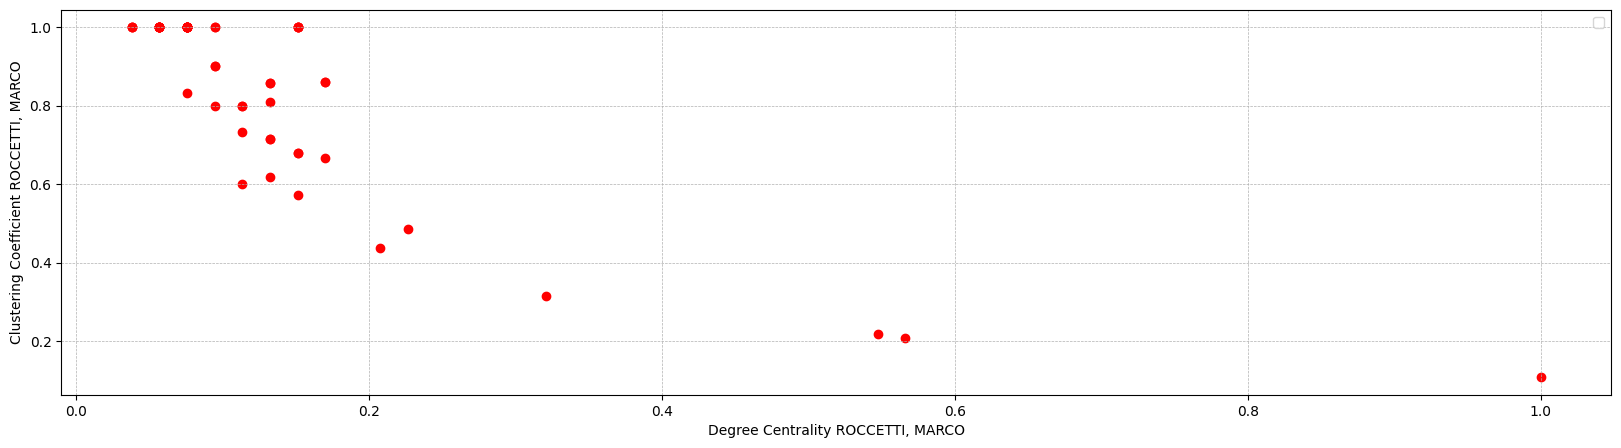

In [28]:
for degree_author, degree_centrality in degree_centrality_subgraphs.items():
    for clustering_author, clustering_centrality in clustering_coefficient_subgraphs.items():
        # Ensure that we only compare the centrality of the same author
        if clustering_author == degree_author:
            # Get the values of degree centrality and clustering coefficient
            degree_values_all = list(degree_centrality.values())
            clustering_values_all = list(clustering_centrality.values())

            # Create the plot
            plt.figure(figsize=(20,5))

            plt.scatter(degree_values_all, clustering_values_all, color='r')
            plt.xlabel(f'Degree Centrality {clustering_author}')
            plt.ylabel(f'Clustering Coefficient {degree_author}')
            plt.legend()
            plt.grid(True, ls="--", linewidth=0.5)

            # Show the plot
            plt.show()


### Cliques
Trovare **cliques** nei sottografi, cioè sottoinsiemi di nodi in cui ogni nodo è collegato a tutti gli altri nodi all'interno del sottoinsieme. 

In [29]:
os.makedirs("gephi_cliques", exist_ok=True)

# Iterate over each subgraph
for author, subgraph in subgraphs.items():
    # Find cliques in the current subgraph
    cliques = list(nx.find_cliques(subgraph))
    print(f"Found {len(cliques)} cliques in subgraph {author}")

    for i, clique in enumerate(cliques):
        clique_all = clique
        # Extract the nodes and edges for this clique from the subgraph_data dictionary
        df_nodes = subgraph_data[author]["nodes"]
        df_edges = subgraph_data[author]["edges"]

        # Filter the edges and nodes for this clique
        df_edge_clique_all = df_edges[df_edges['Source'].isin(clique_all) & df_edges['Target'].isin(clique_all)]
        df_node_clique_all = df_nodes[df_nodes['Nodes'].isin(clique_all)]
        
        # Save the clique's edges and nodes to CSV files
        df_edge_clique_all.to_csv(f'gephi_cliques/{author}_edge_clique_{i+1}.csv', index=False)
        df_node_clique_all.to_csv(f'gephi_cliques/{author}_node_clique_{i+1}.csv', index=False)


Found 7 cliques in subgraph Saverio Giallorenzo
Found 3 cliques in subgraph Succi G
Found 24 cliques in subgraph OMICINI, ANDREA
Found 40 cliques in subgraph ROCCETTI, MARCO


Calcolo del **coefficiente di assortatività del grado** nei sottografi.

Il **coefficiente di assortatività del grado** è una misura che indica se i nodi di un grafo tendono a connettersi a nodi di simile o dissimile grado (cioè, il numero di connessioni che ogni nodo ha). Esistono tre possibili scenari:

- **Assortativo**: Se i nodi ad alto grado tendono a connettersi con altri nodi ad alto grado (e quelli a basso grado con altri a basso grado), il coefficiente di assortatività sarà positivo.
- **Disassortativo**: Se i nodi ad alto grado tendono a connettersi con nodi a basso grado (e viceversa), il coefficiente sarà negativo.
- **Nullo o zero**: Se non c'è una preferenza particolare per il tipo di nodo con cui i nodi si connettono, il coefficiente sarà vicino a zero.

Questo coefficiente è calcolato in base alla correlazione tra i gradi dei nodi connessi. Viene determinato considerando tutte le coppie di nodi collegati nel grafo e analizzando la relazione tra i loro gradi.

- Se il risultato è **positivo**, significa che i nodi tendono a connettersi con altri nodi di simile grado, ossia nodi con alto grado sono collegati a nodi con alto grado, e nodi con basso grado sono collegati a nodi con basso grado (un comportamento **assortativo**).
- Se il risultato è **negativo**, significa che i nodi ad alto grado tendono a connettersi con nodi a basso grado, e viceversa, il che indica un comportamento **disassortativo**.
- Se il risultato è **vicino a zero**, indica che non c'è una preferenza evidente nella connessione tra nodi di diversi gradi (comportamento **casuale**).

Se il coefficiente di assortatività risulta essere negativo, significa che **i nodi con alto grado** (cioè quelli con molte connessioni) tendono a connettersi con **nodi a basso grado** (cioè quelli con poche connessioni). Questo comportamento potrebbe essere un indicatore di un sistema in cui i nodi principali (ad esempio, i più influenti o con maggiore capacità di connessione) sono più propensi a interagire con nodi più periferici o meno connessi, piuttosto che con altri nodi altamente connessi.

In [30]:
# Negative result -> high degree nodes interact more with low degree nodes
for author, subgraph in subgraphs.items():
    r_all = nx.degree_assortativity_coefficient(subgraph)
    print(f"Degree assortativity coefficient {author}:", r_all)

Degree assortativity coefficient Saverio Giallorenzo: -0.29600160136115683
Degree assortativity coefficient Succi G: -1.0
Degree assortativity coefficient OMICINI, ANDREA: -0.399689902989922
Degree assortativity coefficient ROCCETTI, MARCO: -0.34441360219824396


### Calcolo della **densità** dei sottografi
La **densità di un grafo** è una misura che indica quanto il grafo è "pieno" di connessioni, ossia quanto le connessioni effettive (gli **archi**) siano vicine al numero massimo di connessioni possibili. In altre parole, la densità misura la proporzione (rapporto) di archi presenti rispetto ai possibili archi che potrebbero esistere.

La formula per la densità di un grafo è la seguente:
Densità = Numero di archi / Numero massimo di archi possibili

- Il **numero di archi** è semplicemente il numero effettivo di connessioni tra i nodi nel grafo.
- Il **numero massimo di archi possibili** è il numero di connessioni che potrebbero esserci se ogni nodo fosse connesso con ogni altro nodo. Per un grafo non orientato, questo numero è dato da:

Numero massimo di archi possibili = n(n-1)/2

dove `n` è il numero di nodi nel grafo. Per un grafo orientato, il numero massimo di archi è:

Numero massimo di archi possibili = n(n-1)

### Interpretazione del risultato

- Se la densità è **vicina a 1**, significa che il grafo è **molto denso** e ha quasi il massimo possibile di connessioni tra i nodi.
- Se la densità è **bassa (vicina a 0)**, significa che il grafo è **scarso di connessioni** e ci sono molti nodi che non sono direttamente connessi tra loro.

Un valore elevato (vicino a 1) suggerisce un grafo altamente connesso, mentre un valore basso (vicino a 0) indica un grafo con poche connessioni rispetto a quelle possibili.

In [31]:
for author, subgraph in subgraphs.items():
    density = nx.density(subgraph)
    print(f"Density for {author}:", density)

Density for Saverio Giallorenzo: 0.3382352941176471
Density for Succi G: 0.5
Density for OMICINI, ANDREA: 0.19959677419354838
Density for ROCCETTI, MARCO: 0.14116002795248078


# Community detection

## Cosa sono le community in un grafo?
In una social network analysis o in un grafo, una community è un insieme di nodi che sono più fortemente collegati tra loro rispetto al resto del grafo. In altre parole, i nodi di una stessa comunità hanno un numero elevato di collegamenti interni e relativamente pochi collegamenti con i nodi al di fuori della comunità.

## Perché sono utili le community?
Le community sono importanti per analizzare le relazioni e la struttura di un grafo:
* Social Network: Identificare gruppi di persone con interessi simili o relazioni strette.
* Biologia: Studiare moduli in reti di interazioni proteiche o genomiche.
* Marketing: Segmentare clienti o utenti per campagne mirate.
* Ricerca: Scoprire gruppi collaborativi in un'analisi di co-autori.
* Sicurezza: Rilevare comportamenti anomali o cluster di attività dannose.


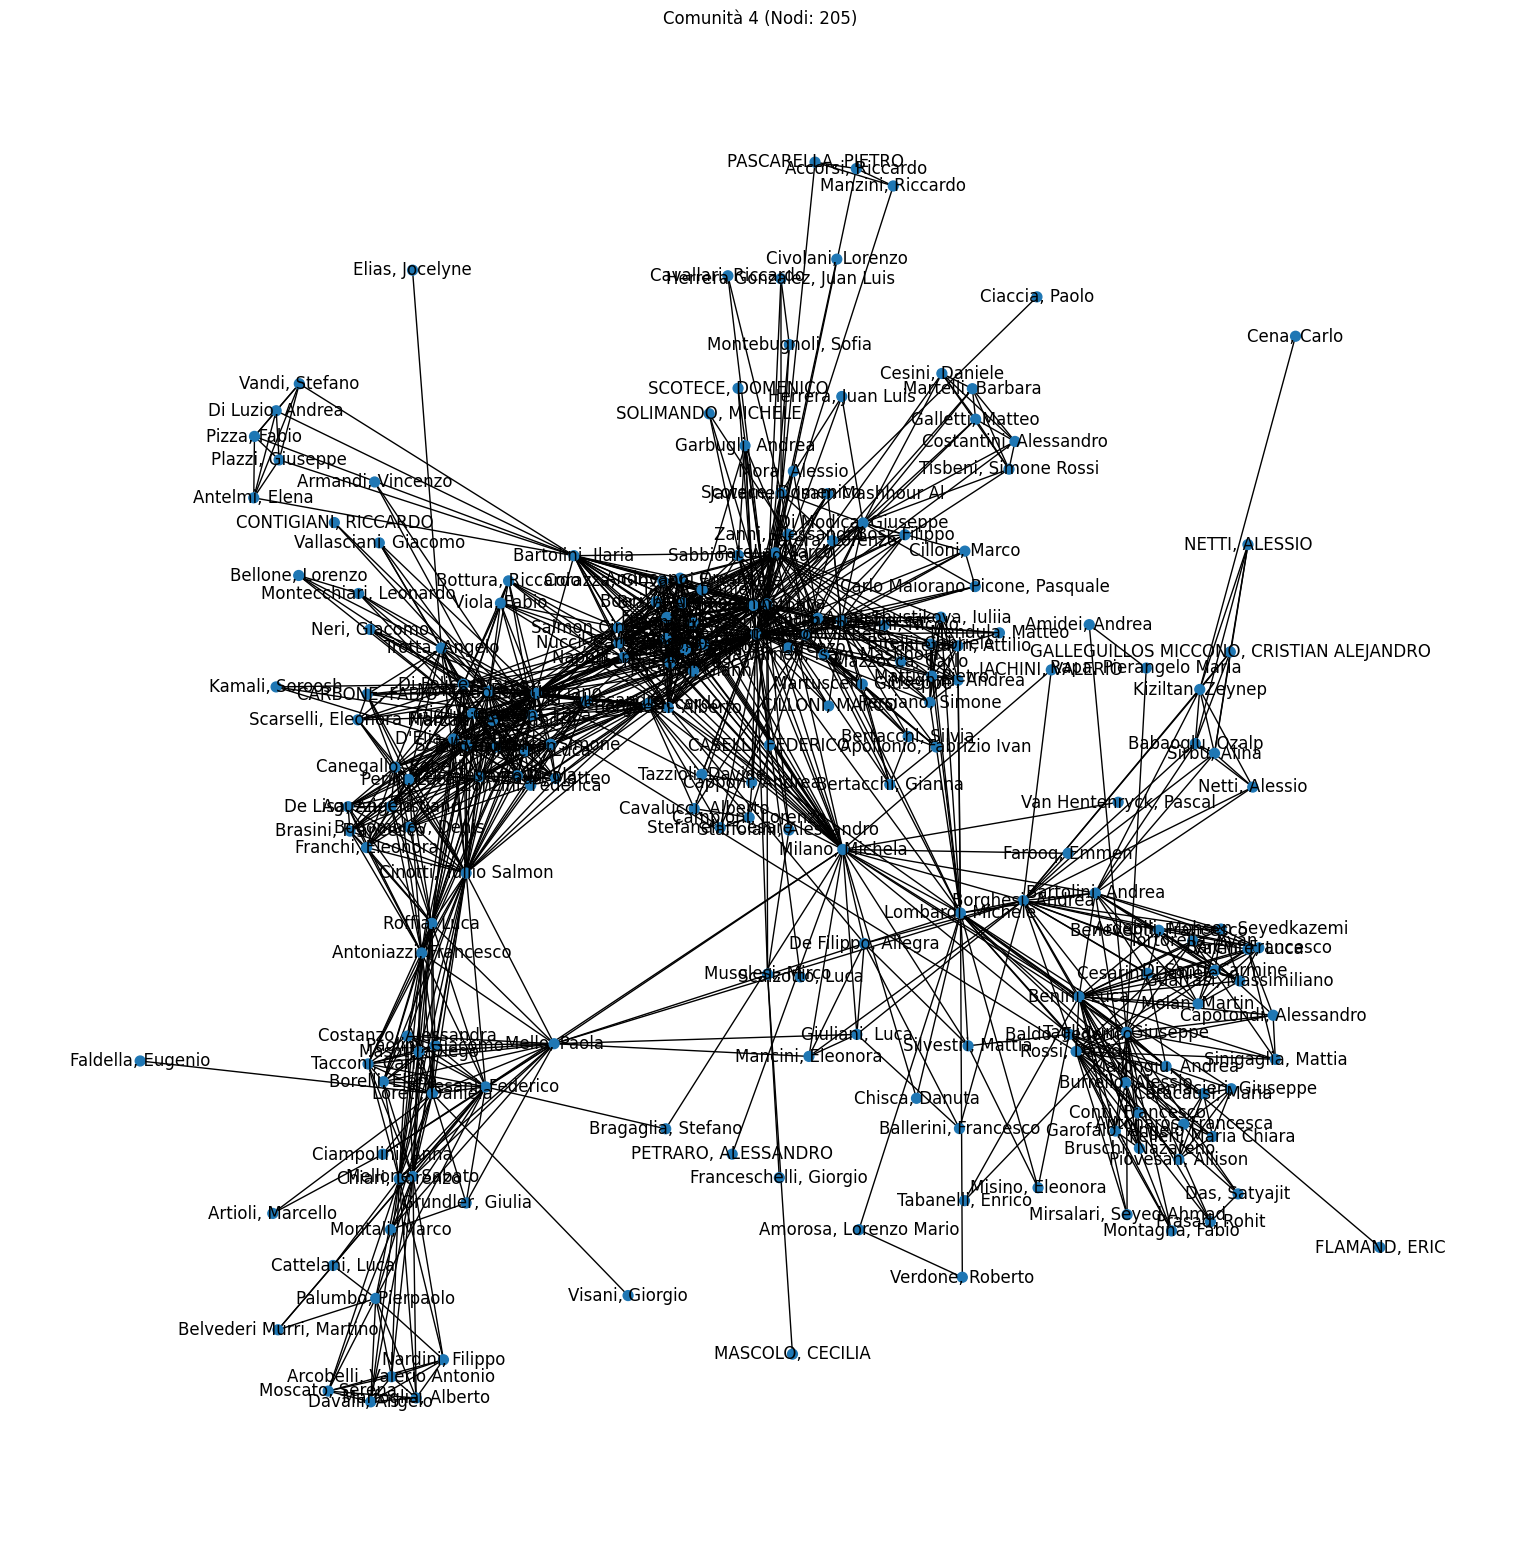

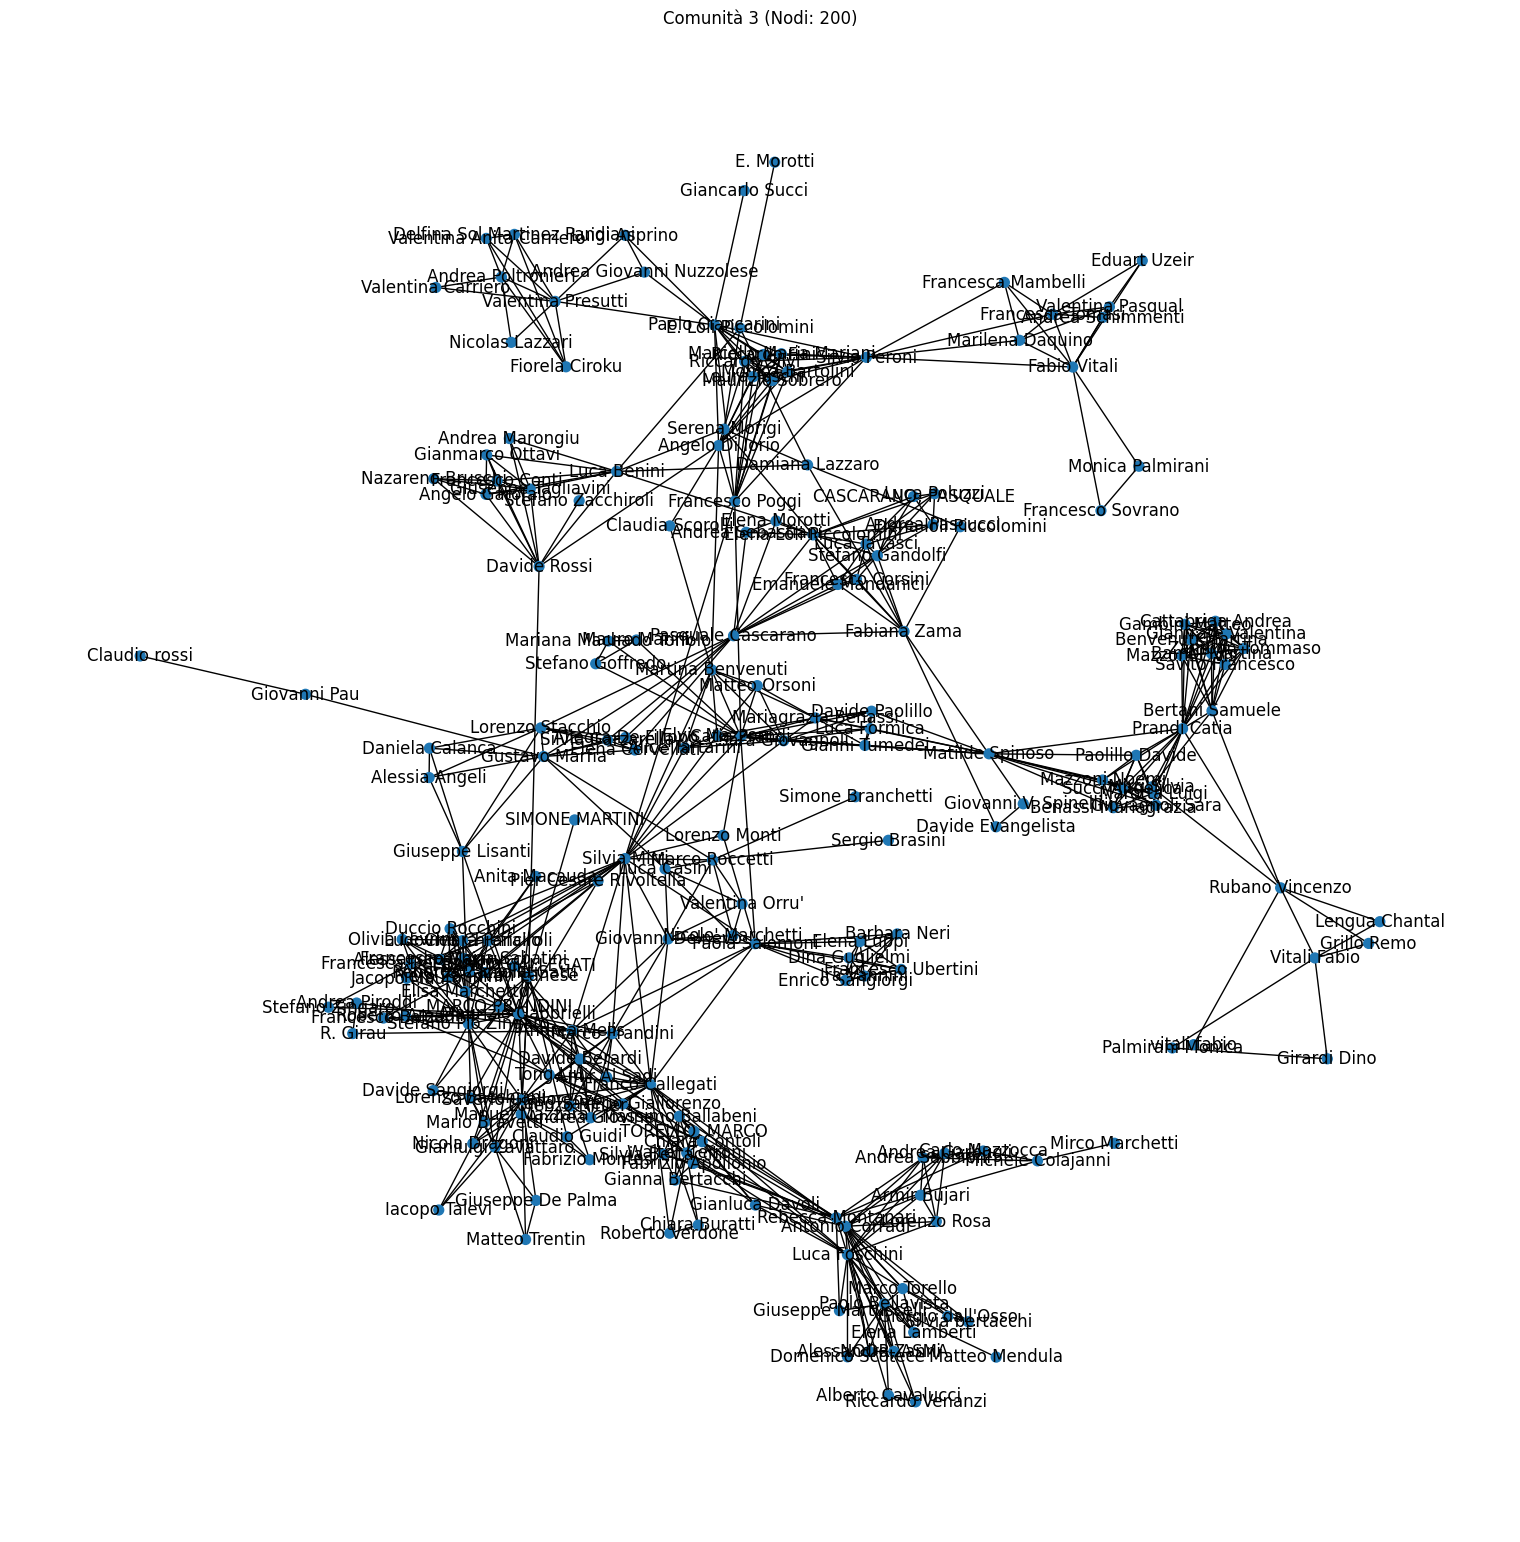

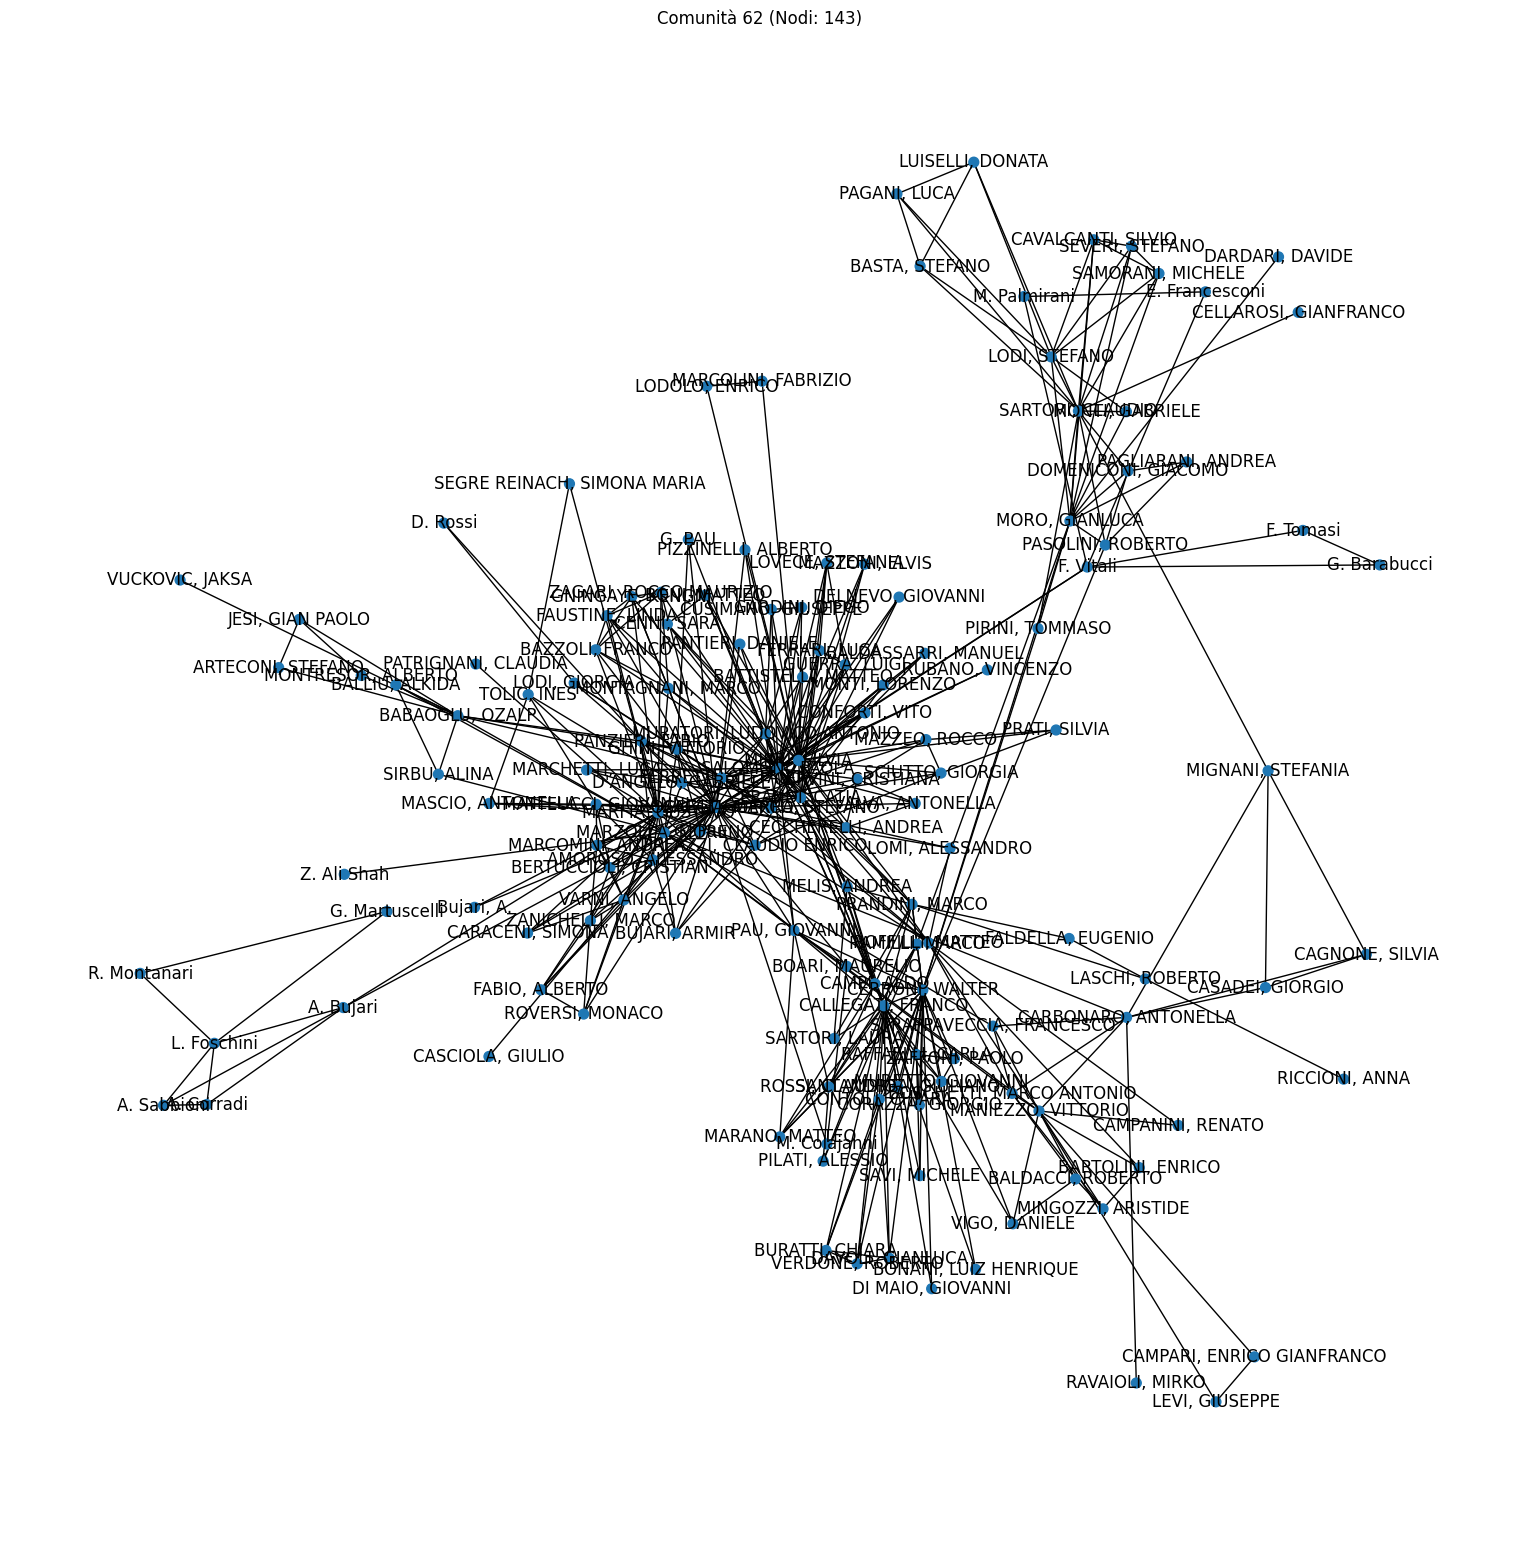

Nodi totali: 2831, Archi totali: 14048
Comunità 4: 205 nodi
Comunità 3: 200 nodi
Comunità 62: 143 nodi


In [ ]:
# Calcolo della partizione con l'algoritmo di Louvain
# Louvain assegna a ogni nodo un identificatore di comunità, cercando di massimizzare la modularità.
partition = community_louvain.best_partition(G)

# Raggruppa i nodi in base alla comunità
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

# Ordina le comunità in base al numero di nodi
# Identifica le comunità più grandi per visualizzarle separatamente.
sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)

# Visualizza le 3 comunità più grandi come sottografi separati
for i, (comm_id, nodes) in enumerate(sorted_communities[:3]):  # Solo le prime 3 comunità
    subgraph = G.subgraph(nodes)

    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(subgraph, seed=42) 
    nx.draw(
        subgraph, pos, with_labels=True, node_size=50,  
        node_color=[comm_id] * len(subgraph),          
        cmap=plt.cm.tab20                            
    )
    plt.title(f"Comunità {comm_id} (Nodi: {len(nodes)})")
    plt.show() 

print(f"Nodi totali: {G.number_of_nodes()}, Archi totali: {G.number_of_edges()}")

for comm_id, nodes in sorted_communities[:3]:
    print(f"Comunità {comm_id}: {len(nodes)} nodi")

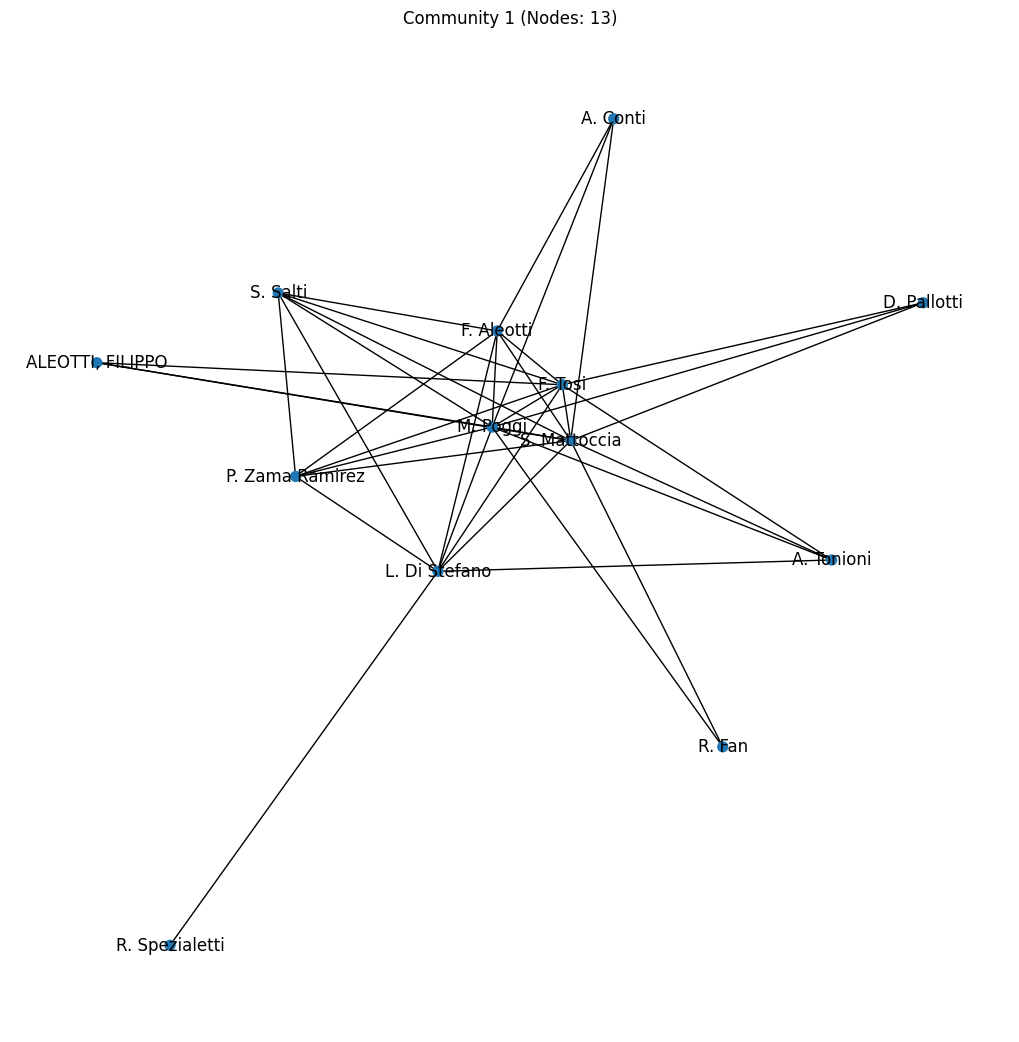

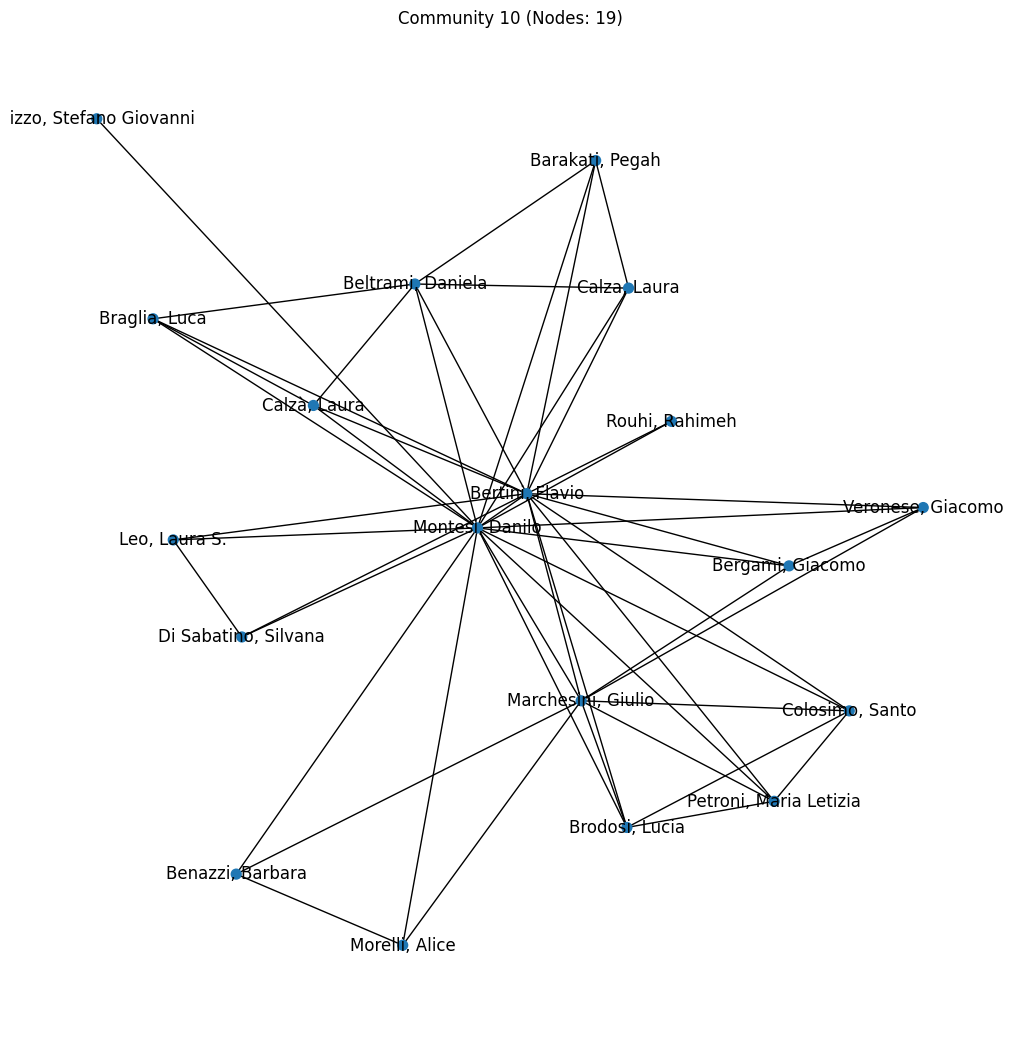

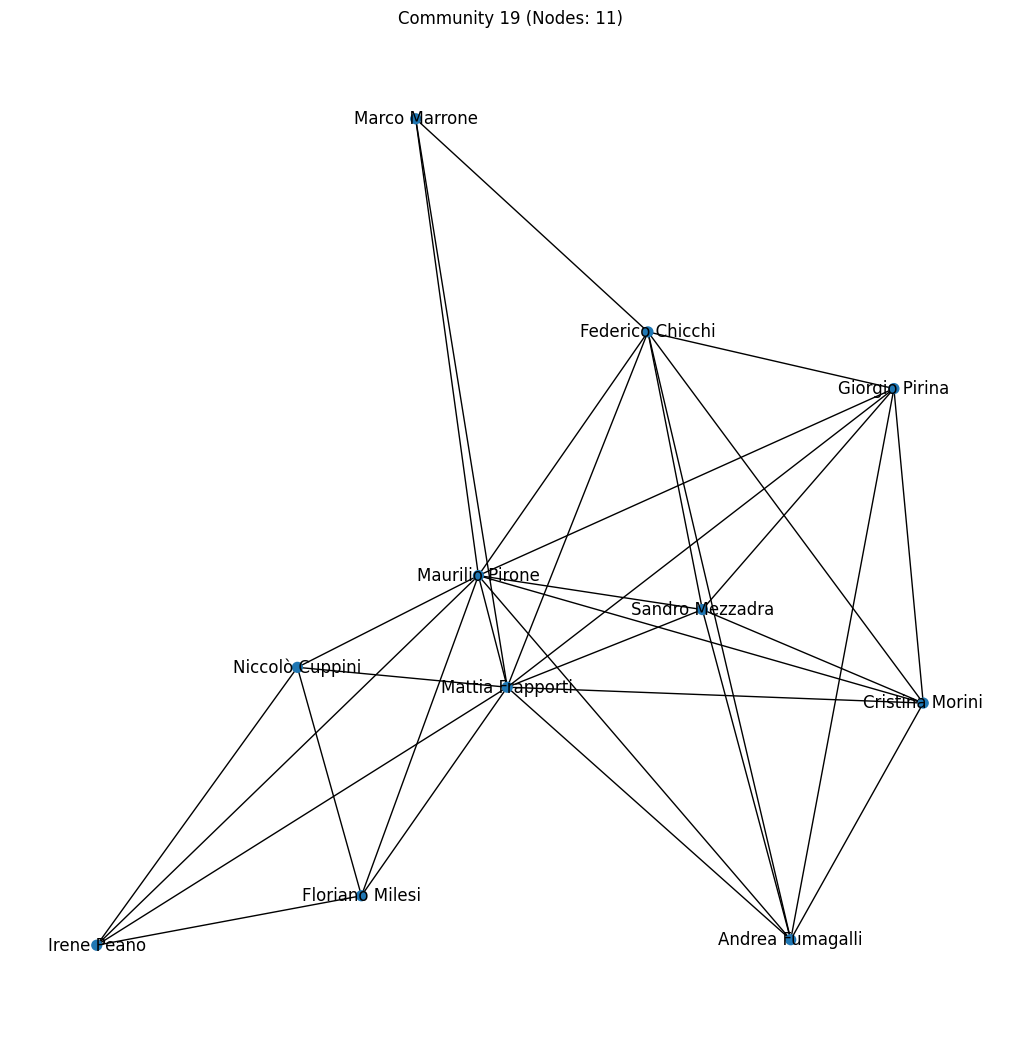

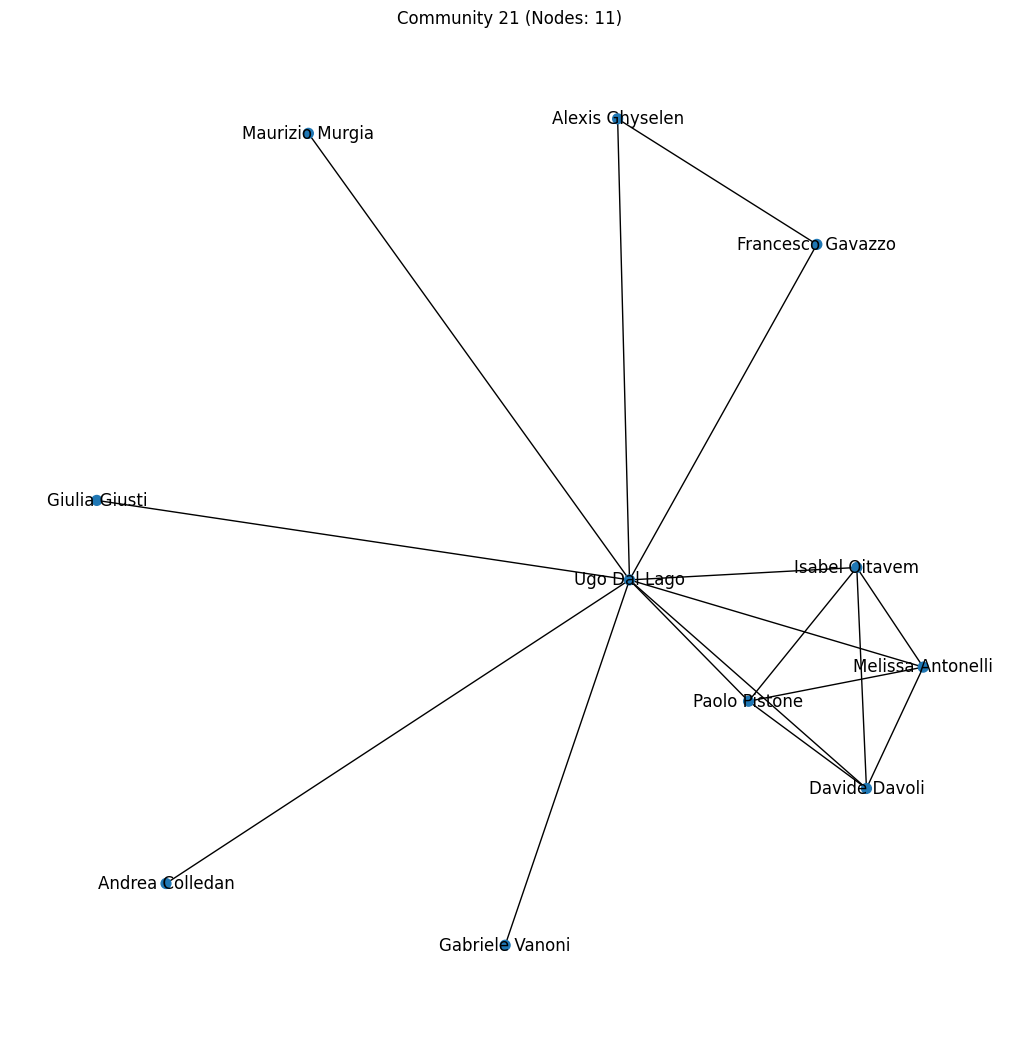

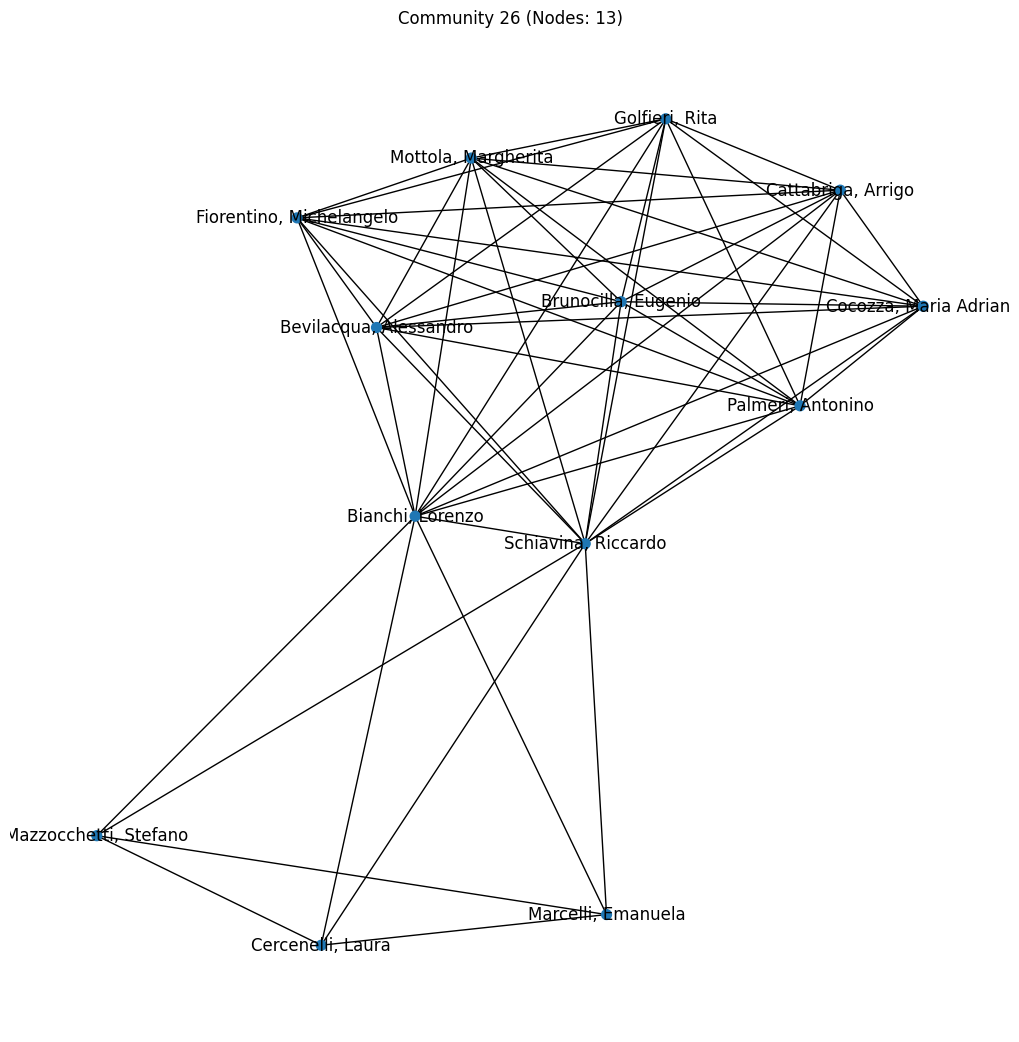

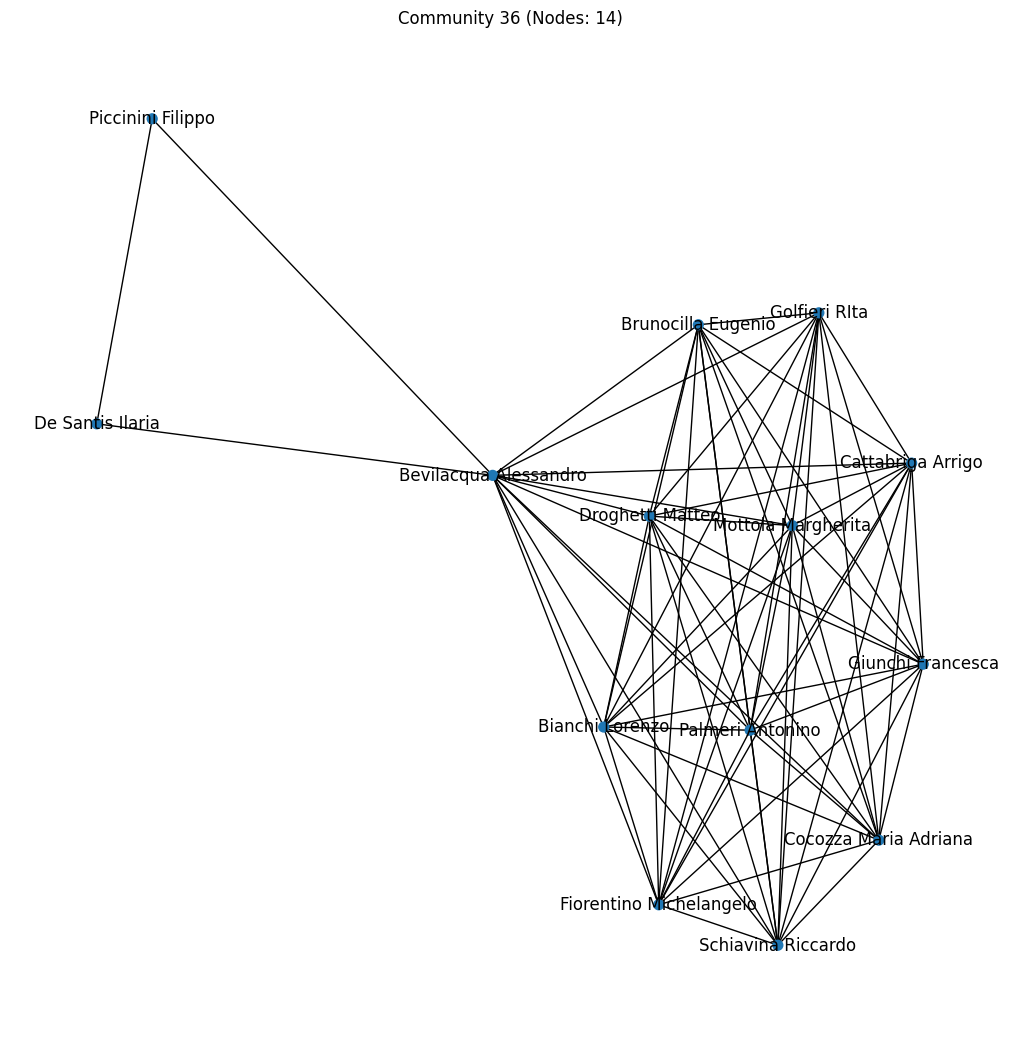

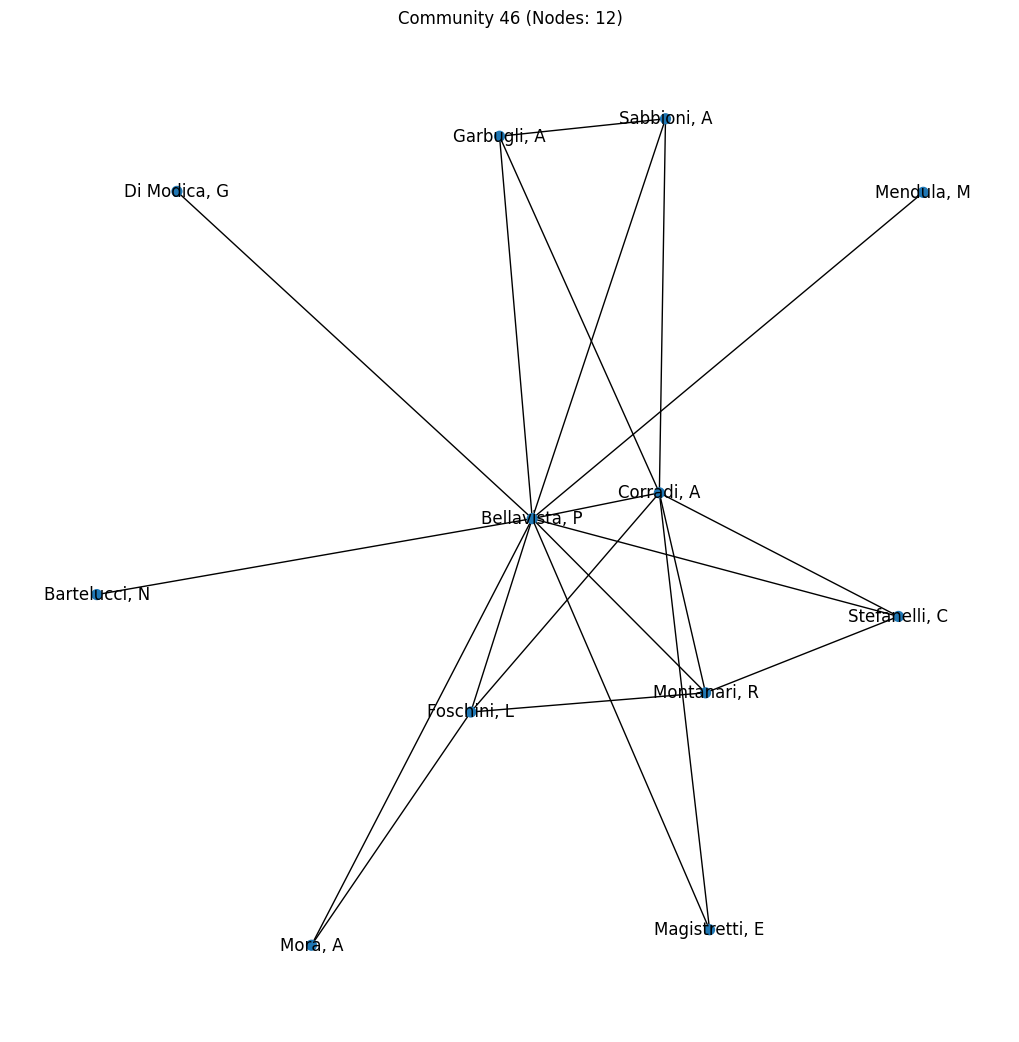

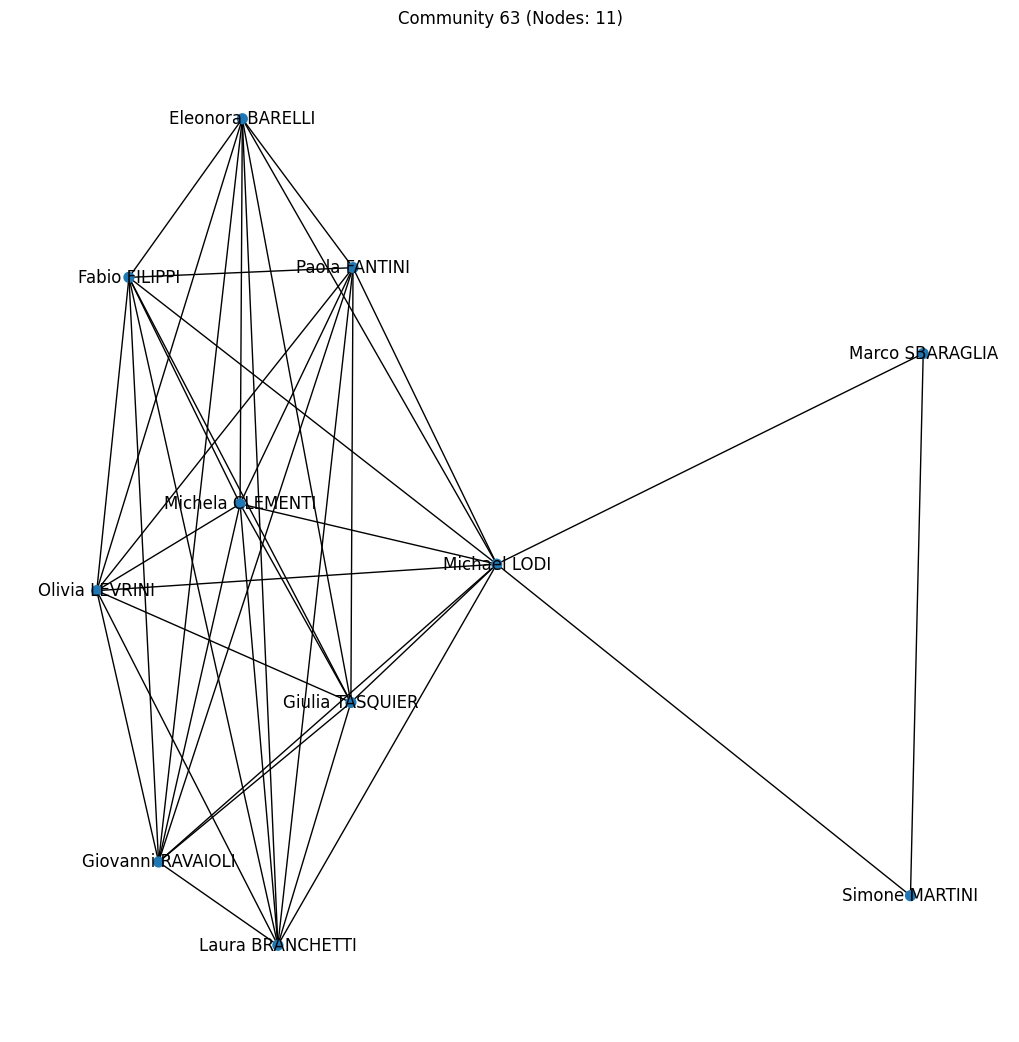

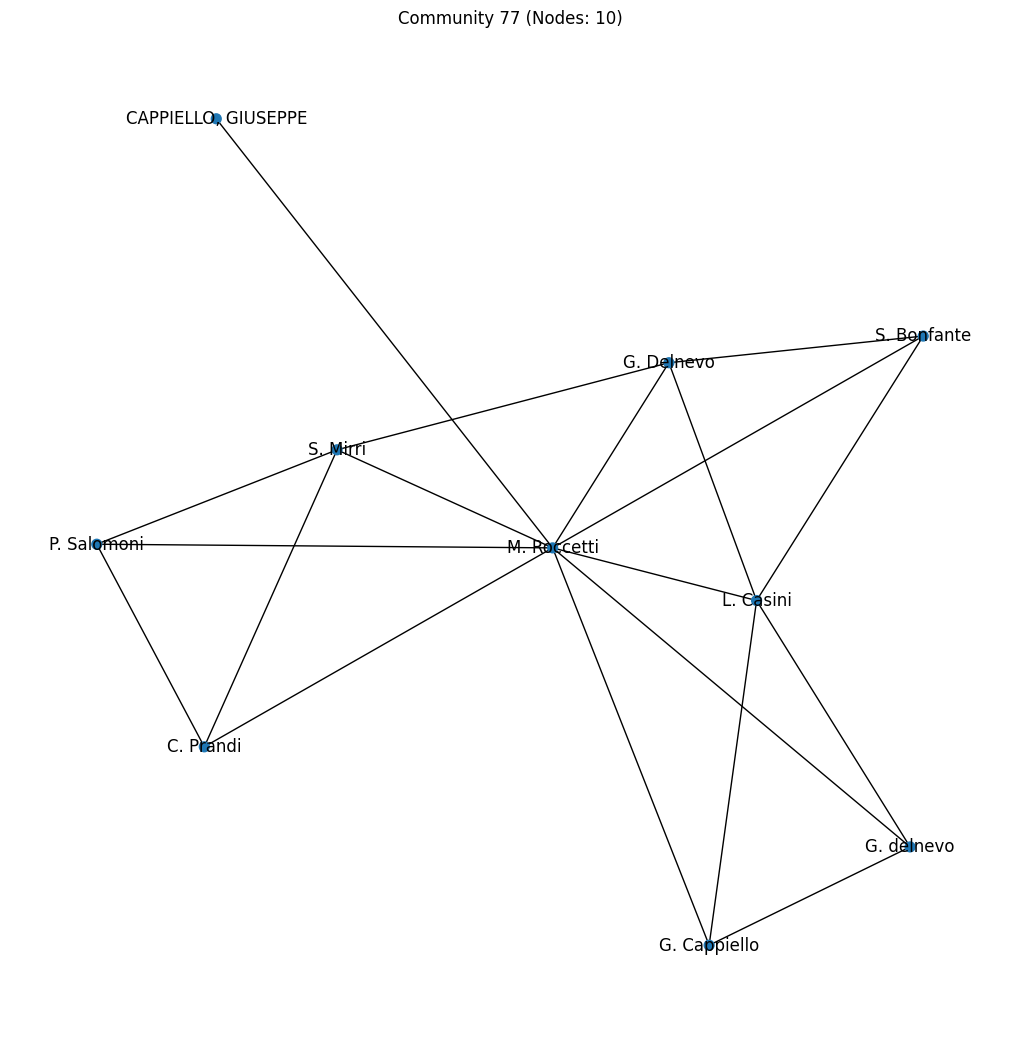

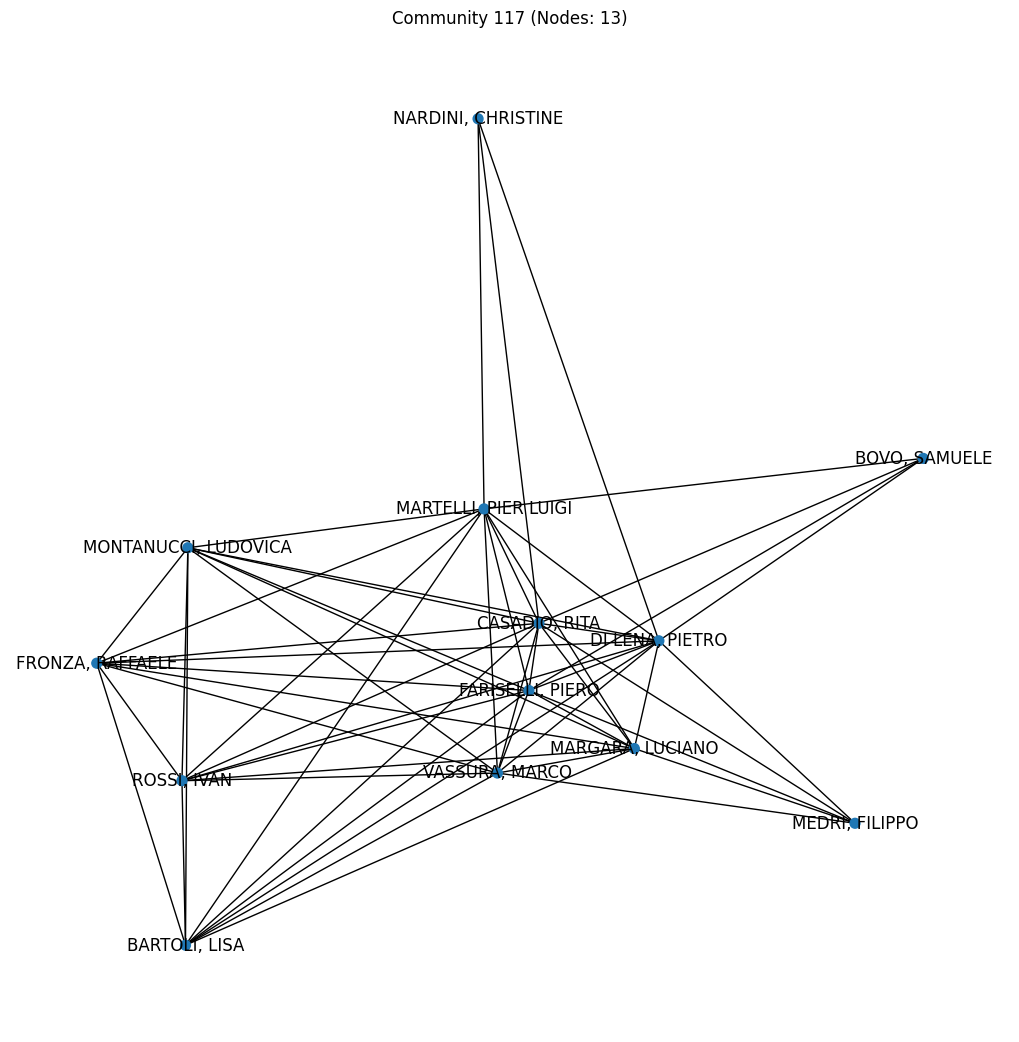

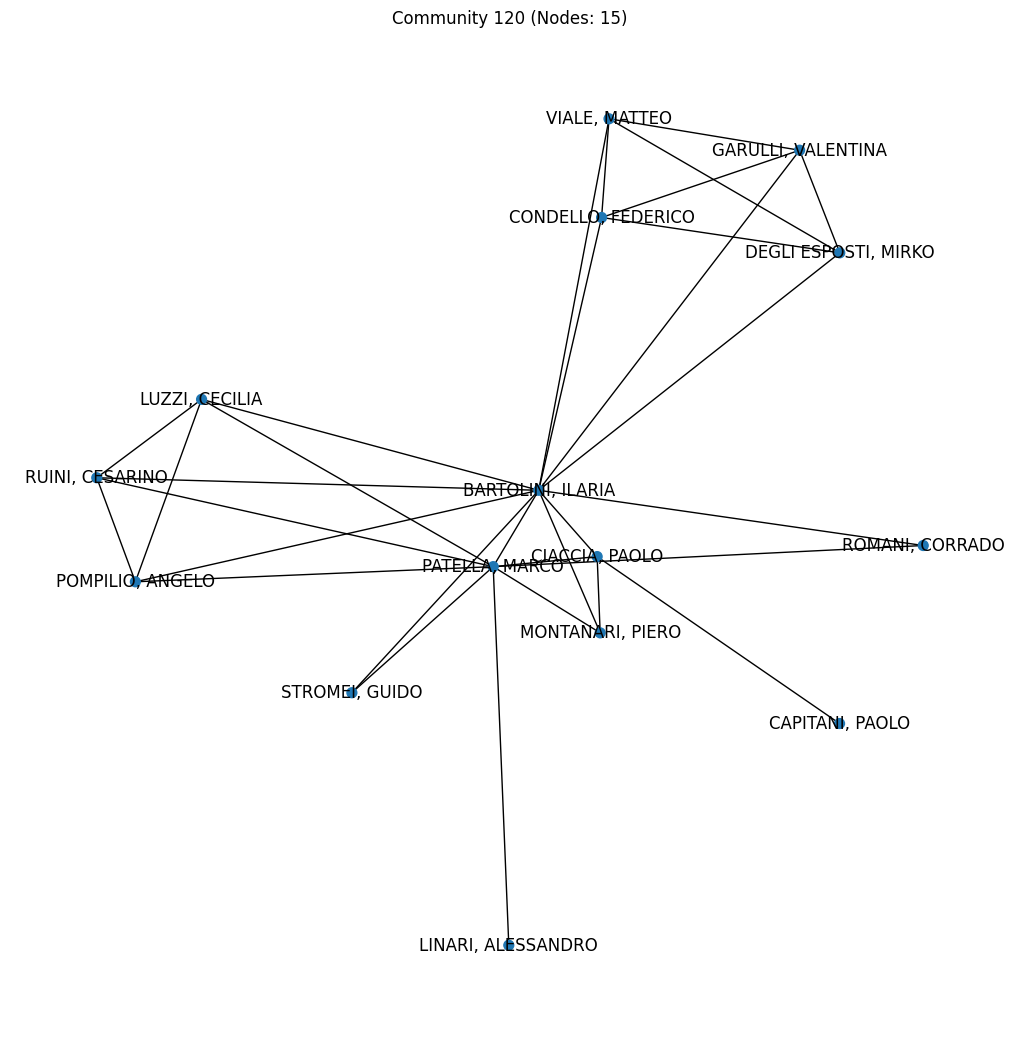

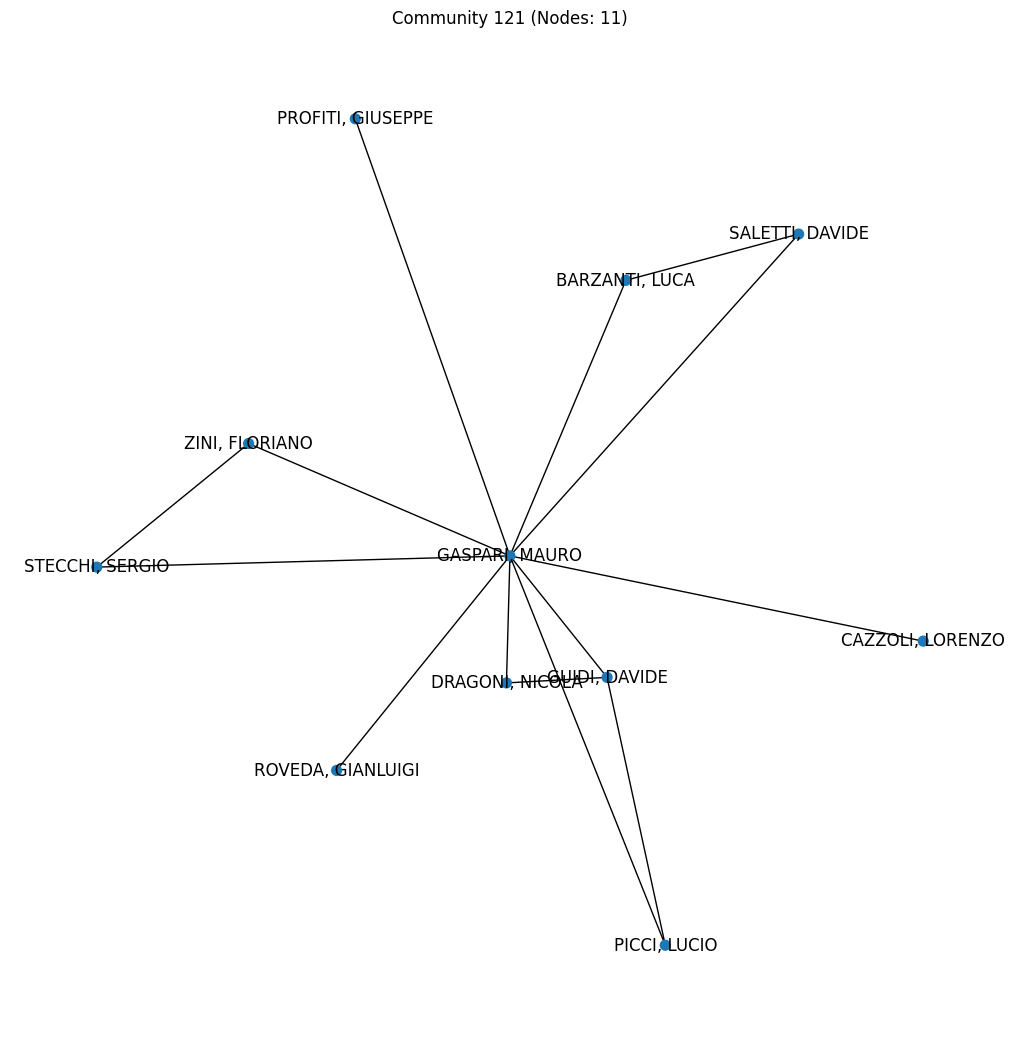

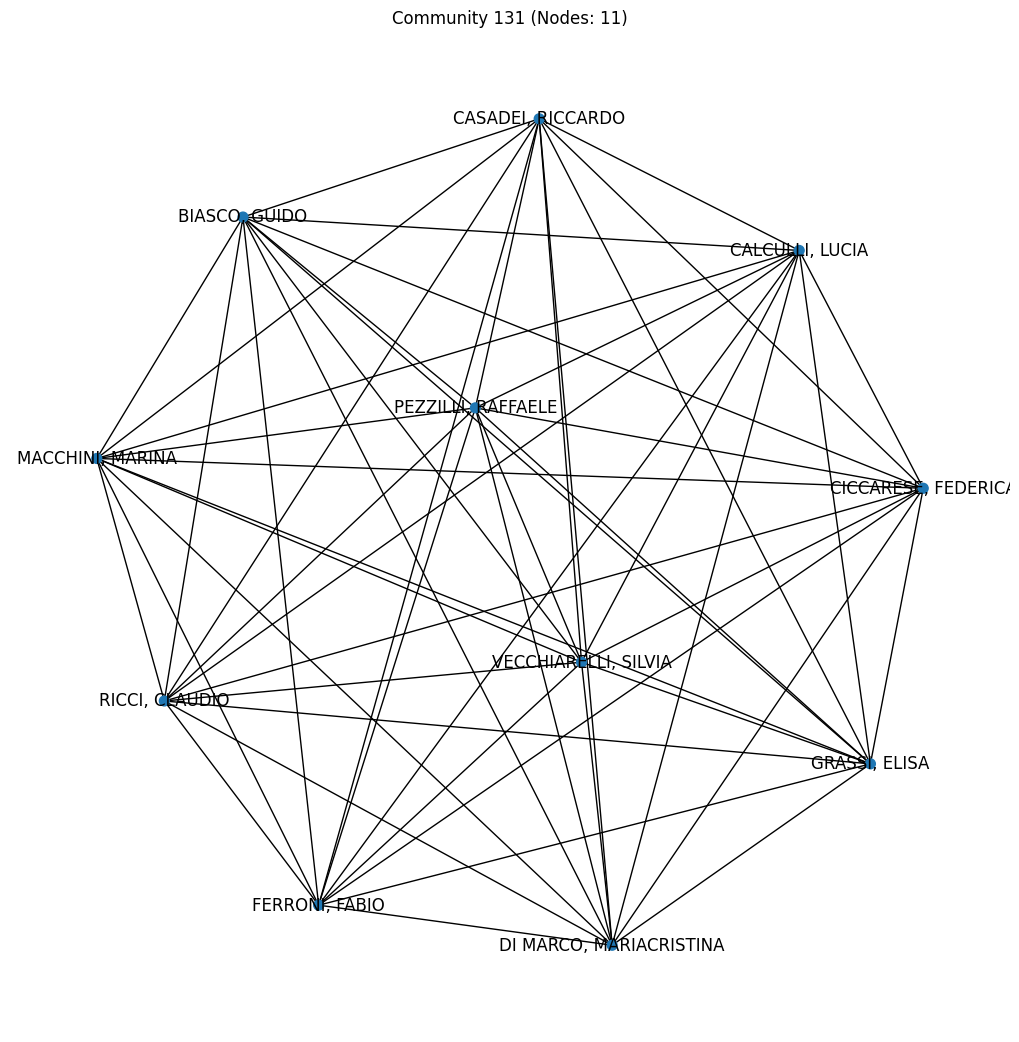

Nodi totali: 2831, Archi totali: 14048
Comunità 1: 13 nodi
Comunità 10: 19 nodi
Comunità 19: 11 nodi
Comunità 21: 11 nodi
Comunità 26: 13 nodi
Comunità 36: 14 nodi
Comunità 46: 12 nodi
Comunità 63: 11 nodi
Comunità 77: 10 nodi
Comunità 117: 13 nodi
Comunità 120: 15 nodi
Comunità 121: 11 nodi
Comunità 131: 11 nodi


In [45]:
# Calcolo della partizione con l'algoritmo di Louvain
# Louvain assegna a ogni nodo un identificatore di comunità, cercando di massimizzare la modularità.
partition = community_louvain.best_partition(G)

# Raggruppa i nodi in base alla comunità
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

# Filtra le comunità con esattamente 40 nodi
communities_with_40_nodes = {comm_id: nodes for comm_id, nodes in communities.items() if len(nodes) in range (10, 21)}

# Verifica se ci sono comunità con 40 nodi
if not communities_with_40_nodes:
    print("Non ci sono comunità con esattamente 40 nodi.")
else:
    # Visualizza le comunità con 40 nodi come sottografi separati
    for comm_id, nodes in communities_with_40_nodes.items():
        subgraph = G.subgraph(nodes)

        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(subgraph, seed=42) 
        nx.draw(
            subgraph, pos, with_labels=True, node_size=50,
            node_color=[comm_id] * len(subgraph),
            cmap=plt.cm.tab20
        )
        plt.title(f"Community {comm_id} (Nodes: {len(nodes)})")
        plt.show()

    # Stampa informazioni sulle comunità con 40 nodi
    print(f"Nodi totali: {G.number_of_nodes()}, Archi totali: {G.number_of_edges()}")
    for comm_id, nodes in communities_with_40_nodes.items():
        print(f"Comunità {comm_id}: {len(nodes)} nodi")

In [38]:
# Filtra i nodi e gli archi per le 3 comunità più grandi
top_communities_nodes = set()
for comm_id, nodes in sorted_communities[:3]:
    top_communities_nodes.update(nodes)

# Crea un sottografo con solo i nodi delle 3 comunità più grandi
subgraph = G.subgraph(top_communities_nodes)

# Esporta i nodi del sottografo
with open("top_nodes.csv", "w", newline="") as nodes_file:
    writer = csv.writer(nodes_file)
    writer.writerow(["Id", "Community"])
    for node in subgraph.nodes():
        writer.writerow([node, partition[node]])

# Esporta gli archi del sottografo
with open("top_edges.csv", "w", newline="") as edges_file:
    writer = csv.writer(edges_file)
    writer.writerow(["Source", "Target", "Weight"])
    for u, v, data in subgraph.edges(data=True):
        weight = data.get("weight", 1)
        writer.writerow([u, v, weight])

# Metriche Avanzate
## Resilienza della rete
Valutare quanto la rete è robusta rimuovendo nodi importanti (ad esempio, gli autori con la centralità più alta) e misurando l'impatto sulla connettività:

## Rimozione dei nodi chiave
Rimozione dei nodi con la centralità più alta e osservare come cambia il numero di componenti connesse o il diametro della rete.

In [34]:
components_before = nx.number_connected_components(G)

# Ordina i nodi per centralità di grado
degree_centrality = nx.degree_centrality(G)
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:5]

# Rimuovi nodi chiave
G_copy = G.copy()
for node in top_nodes:
    G_copy.remove_node(node)

# Valuta l'impatto
components = nx.number_connected_components(G_copy)
print(f"Numero di componenti connesse prima la rimozione: {components_before}")
print(f"Numero di componenti connesse dopo la rimozione: {components}")

Numero di componenti connesse prima la rimozione: 113
Numero di componenti connesse dopo la rimozione: 113


## Simulare attacchi casuali:
   - Rimuove un insieme casuale di nodi dalla rete.
   - Questo rappresenta un'analisi di scenario per capire cosa succede se alcuni nodi vengono eliminati (per esempio, fallimenti casuali o perdita di nodi).

### Valutare la connettività della rete
   - Dopo la rimozione, il codice calcola il numero di **componenti connesse** nel grafo rimanente.
   - Un aumento del numero di componenti connesse indica che il grafo sta diventando più frammentato e meno connesso.


### Applicazione nella SNA
1. **Analisi della Robustezza**:
   - In una rete sociale, l'eliminazione casuale di nodi può simulare eventi come l'abbandono di utenti o la perdita di connessioni.
   - Se il numero di componenti connesse aumenta rapidamente, la rete è **fragile** rispetto agli attacchi casuali.
   - Se la rete rimane connessa, è **robusta**.

2. **Identificazione di Vulnerabilità**:
   - Confrontando l'effetto degli attacchi casuali con attacchi mirati (ad esempio, rimuovendo i nodi più connessi o centrali), si possono individuare nodi critici o vulnerabilità strutturali.

3. **Simulazioni per Sistemi Complessi**:
   - La resilienza di una rete sociale, un'infrastruttura (come Internet) o una rete biologica può essere studiata simulando la rimozione di elementi casuali.

4. **Preparazione a Interruzioni**:
   - In scenari reali, come nei sistemi di comunicazione o nei social network, questa analisi aiuta a progettare reti più resilienti.

In [35]:
components_random_before = nx.number_connected_components(G)

# Crea una copia del grafo
G_random = G.copy()

# Converte G.nodes() in una lista e seleziona 5 nodi casuali
random_nodes = random.sample(list(G.nodes()), 5)

# Rimuovi i nodi casuali dal grafo
G_random.remove_nodes_from(random_nodes)

# Calcola il numero di componenti connesse nel grafo risultante
components_random = nx.number_connected_components(G_random)

print(f"Numero di componenti connesse prima attacchi casuali: {components_random_before}")
print(f"Numero di componenti connesse dopo attacchi casuali: {components_random}")

Numero di componenti connesse prima attacchi casuali: 113
Numero di componenti connesse dopo attacchi casuali: 114


Coefficiente di assortatività globale
L'assortatività misura se i nodi tendono a connettersi con altri nodi di grado simile:

In [36]:
assortativity = nx.degree_assortativity_coefficient(G)
print(f"Coefficiente di assortatività del grafo: {assortativity}")

Coefficiente di assortatività del grafo: 0.7487327525683094


Rappresentazione della densità
Calcola la densità della rete e dei sottografi, e osserva se differiscono significativamente.

In [37]:
density = nx.density(G)
print(f"Densità della rete: {density}")

# Densità dei sottografi
for author, subgraph in subgraphs.items():
    print(f"Densità del sottografo di {author}: {nx.density(subgraph)}")

Densità della rete: 0.003506858069355807
Densità del sottografo di Saverio Giallorenzo: 0.3382352941176471
Densità del sottografo di Succi G: 0.5
Densità del sottografo di OMICINI, ANDREA: 0.19959677419354838
Densità del sottografo di ROCCETTI, MARCO: 0.14116002795248078
